# Moses IS-EN EN-IS phrase þýðingarvél
Sjá `README.md` til þess að keyra þetta vélrit (e. notebook).

Í þessu vélriti eru gögn forunnin og Moses þýðingarkerfið notað til þess búa til tvö þýðingarkerfi, IS-EN og EN-IS.
Það er gert ráð fyrir því að öll gögn séu aðgengileg undir `/work/data`. Sjá leiðbeiningar í `README.md` um hvernig það er gert með `docker` eða `singularity`.

Í stuttu máli skiptist vélritið í eftirfarandi þætti:
1. Samhliða og einhliða gögn undirbúin.
1. Tungumála módel byggt fyrir EN og IS (KenLM).
1. Texta skipt í þrjá hluta; train/val/test, fjöldi setninga í val/test er 3000/2000.
1. Moses kerfið þjálfað með train hluta texta.
1. Moses kerfið fínpússað með val hluta texta.
1. Moses kerfið metið með BLEU mælingin á test hluta texta.

Allar skrár og líkön eru raðað í skrána "WORKING_DIR" (sjá `README.md`).

Safnið `corpus.py` skilgreinir föll og gagnategundir sem eru mikið nýttar hér.

In [1]:
from collections import defaultdict, Counter, OrderedDict
import os
import pathlib
from pathlib import Path
import re
from pprint import pprint
import importlib
from typing import List

import matplotlib.pyplot as plt
import numpy as np

import corpus.corpus as c

importlib.reload(c)

%matplotlib notebook

THREADS = 4
working_dir = pathlib.Path('/work')
data_dir = working_dir.joinpath('data')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's be sure that Moses is installed and the data is there.

In [2]:
print(os.getenv('MOSESDECODER'))
print(os.getenv('MOSESDECODER_TOOLS'))
print(os.getenv('THREADS'))
!ls {data_dir}

/opt/moses
/opt/moses_tools
4
parice	rmh  usenet


In [5]:
# List of stages in processing
CAT = 'cat'
SHUFFLE = 'shuffle'
REGEXP = 'regexp'
LOWER = 'lower'
TOKENIZE = 'tok'
PLACEHOLDERS = 'placeholders'
LENGTH = 'length'
LM = 'lm-blm'

parice_dir = data_dir.joinpath('parice')
rmh_dir = data_dir.joinpath('rmh')

is_rmh_pipeline = {}
# If we are not starting from scratch - we try to load all intermediary stages
en_parice_pipeline = c.pipeline_load(parice_dir, [CAT, LOWER, REGEXP, TOKENIZE], c.Lang.EN)
is_parice_pipeline = c.pipeline_load(parice_dir, [CAT, LOWER, REGEXP, TOKENIZE], c.Lang.IS)

In [6]:
pprint(en_parice_pipeline)
pprint(is_parice_pipeline)

{'cat': PosixPath('/work/data/parice/cat.en'),
 'lower': PosixPath('/work/data/parice/lower.en'),
 'regexp': PosixPath('/work/data/parice/regexp.en'),
 'tok': PosixPath('/work/data/parice/tok.en')}
{'cat': PosixPath('/work/data/parice/cat.is'),
 'lower': PosixPath('/work/data/parice/lower.is'),
 'regexp': PosixPath('/work/data/parice/regexp.is'),
 'tok': PosixPath('/work/data/parice/tok.is')}


### Einhliða málheild fyrir íslensku - RMH
Hér er unnið með risamálheildina þar sem búið er að sameina RMH1 og RMH2 í eina textaskrá með setningu í hverri línu. Þessi skrá er t.d. á Terra undir `/data/risamalheild/extras/rmh.txt` eða `/scratch/smt/data/rmh/rmh.txt`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/rmh/rmh.txt`.

In [26]:
rmh = data_dir.joinpath('rmh/rmh.txt')
!wc -l {rmh}
print(*c.corpus_peek(rmh))

71257907 /work/data/rmh/rmh.txt
Mini er ekkert nýtt nafn í bílaflota Íslands en upp úr 1960 var Garðar Gíslason stórkaupmaður á Hverfisgötu 4 6 með umboð fyrir bresku Austin-verksmiðjurnar
 Austin Mini var vinsæll og ódýr bíll hér á Íslandi fram undir 1970
 Fyrstu Mini-bílarnir voru með kraftlitla 850cc vél og á 10 tommu felgum sem hentuðu ekki vel fyrir íslenska vegi
 Fyrir vikið var það Bjallan frá Volkswagen sem hafði vinninginn í smábílasölunni
 Frá síðustu aldamótum hefur Mini verið í eigu BMW og náð töluverðum vinsældum
 Árið 2012 byrjaði vel fyrir Mini en þá varð Mini X-Raid í fyrsta og öðru sæti í hinu fræga Dakarralli
 Árið eftir var Mini í fjórum fyrstu sætunum í sömu keppni en allt frá því hefur mig langað til að prófa fjórhjóladrifinn Mini
 Fjórhjóladrifið er samspil tveggja véla
 Að keyra bílinn er nánast hljóðlaust í rólegum akstri byrjar bíllinn á að nota rafmagnsmótorinn sem hefur um 40 km drægni fullhlaðinn en ef farið er upp fyrir 80 km hraða kemur bensínmótorinn inn


### Einhliða málheild fyrir ensku - USENET
Hér er unnið með USENET málheildina. Þessi skrá er t.d. á Terra undir `/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt` eða `/scratch/smt/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt`.

Vísun í grein: Shaoul, C. & Westbury C. (2013) A reduced redundancy USENET corpus (2005-2011)  Edmonton, AB: University of Alberta (downloaded from http://www.psych.ualberta.ca/~westburylab/downloads/usenetcorpus.download.html)

In [29]:
usenet = data_dir.joinpath('usenet/WestburyLab.NonRedundant.UsenetCorpus.txt')
!wc -l {usenet}
print(*c.corpus_peek(usenet))

695885933 /work/data/usenet/WestburyLab.NonRedundant.UsenetCorpus.txt


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb9 in position 4581: invalid start byte

### Samhliðamálheild fyrir ensku og íslensku - ParIce
Hér er unnið með ParIce málheildina. Þessar skrár er t.d. á Terra undir `/data/parice/*.tmx` eða `/scratch/smt/data/parice/*.tmx`. Í kóðanum er gert ráð fyrir að þær séu aðgengilegar undir `/work/data/parice/*.tmx`. Fyrst þarf þó aðeins að lagfæra skrárnar svo þær séu allar með sama tungumála merki.

In [30]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

^C
/work/data/parice/ema.tmx:  <header adminlang="EN-US" creationdate="20170426T083707Z" creationtool="Moses-to-TMX-converer" creationtoolversion="1.0" datatype="plaintext" o-tmf="Moses plain text files" segtype="sentence" srclang="en">
/work/data/parice/hagstofan.tmx:  <header adminlang="en" creationdate="20170319T213035Z" creationtool="mALIGNa" creationtoolversion="2" datatype="plaintext" o-tmf="al" segtype="block" srclang="en">


In [12]:
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/ema.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/ema.tmx

In [13]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

data/ema.tmx:  <header adminlang="EN-US" creationdate="20170426T083707Z" creationtool="Moses-to-TMX-converer" creationtoolversion="1.0" datatype="plaintext" o-tmf="Moses plain text files" segtype="sentence" srclang="en">
data/hagstofan.tmx:  <header adminlang="en" creationdate="20170319T213035Z" creationtool="mALIGNa" creationtoolversion="2" datatype="plaintext" o-tmf="al" segtype="block" srclang="en">


In [38]:
tmx_files = !ls {data_dir}/parice/*.tmx
tmx_files = [Path(tmx_file) for tmx_file in tmx_files]
pprint(tmx_files)

[PosixPath('/work/data/parice/baekur.tmx'),
 PosixPath('/work/data/parice/biblian.tmx'),
 PosixPath('/work/data/parice/ees.tmx'),
 PosixPath('/work/data/parice/ema.tmx'),
 PosixPath('/work/data/parice/eso.tmx'),
 PosixPath('/work/data/parice/fornritin.tmx'),
 PosixPath('/work/data/parice/hagstofan.tmx'),
 PosixPath('/work/data/parice/kde4.tmx'),
 PosixPath('/work/data/parice/opensubtitles.tmx'),
 PosixPath('/work/data/parice/tatoeba.tmx'),
 PosixPath('/work/data/parice/ubuntu.tmx')]


Sækjum nú málheildirnar úr .tmx skjölunum.

In [41]:
parice = c.tmx_split_(tmx_files, 'EN-GB', 'IS-IS')
en_parice, is_parice = zip(*parice)

/work/data/parice/baekur.tmx -> /work/data/parice/baekur.en + /work/data/parice/baekur.is
/work/data/parice/biblian.tmx -> /work/data/parice/biblian.en + /work/data/parice/biblian.is
/work/data/parice/ees.tmx -> /work/data/parice/ees.en + /work/data/parice/ees.is
/work/data/parice/ema.tmx -> /work/data/parice/ema.en + /work/data/parice/ema.is
/work/data/parice/eso.tmx -> /work/data/parice/eso.en + /work/data/parice/eso.is
/work/data/parice/fornritin.tmx -> /work/data/parice/fornritin.en + /work/data/parice/fornritin.is
/work/data/parice/hagstofan.tmx -> /work/data/parice/hagstofan.en + /work/data/parice/hagstofan.is
/work/data/parice/kde4.tmx -> /work/data/parice/kde4.en + /work/data/parice/kde4.is
/work/data/parice/opensubtitles.tmx -> /work/data/parice/opensubtitles.en + /work/data/parice/opensubtitles.is
/work/data/parice/tatoeba.tmx -> /work/data/parice/tatoeba.en + /work/data/parice/tatoeba.is
/work/data/parice/ubuntu.tmx -> /work/data/parice/ubuntu.en + /work/data/parice/ubuntu.i

Athugum hvort allt líti rétt út.

In [44]:
for corpus in en_parice + is_parice:
    pprint(c.corpus_info_formatted(corpus))

'/work/data/parice/baekur.en                1007.5KiB        12416'
'/work/data/parice/biblian.en                4.2MiB          65241'
'/work/data/parice/ees.en                   162.8MiB       1701172'
'/work/data/parice/ema.en                    39.1MiB        404333'
'/work/data/parice/eso.en                    1.7MiB          12633'
'/work/data/parice/fornritin.en              1.6MiB          17597'
'/work/data/parice/hagstofan.en             209.8KiB          2288'
'/work/data/parice/kde4.en                   1.6MiB          49912'
'/work/data/parice/opensubtitles.en          38.5MiB       1261398'
'/work/data/parice/tatoeba.en               287.6KiB          8263'
'/work/data/parice/ubuntu.en                248.1KiB         10572'
'/work/data/parice/baekur.is                 1.2MiB          12416'
'/work/data/parice/biblian.is                4.2MiB          65241'
'/work/data/parice/ees.is                   171.5MiB       1701172'
'/work/data/parice/ema.is                    42.

Sameinum ParIce gögnin fyrir hvert mál.

In [43]:
en_parice_pipeline[CAT] = c.corpora_create_path(en_parice, CAT)
is_parice_pipeline[CAT] = c.corpora_create_path(is_parice, CAT)
c.corpora_combine(en_parice, en_parice_pipeline[CAT])
c.corpora_combine(is_parice, is_parice_pipeline[CAT])

True

In [45]:
pprint(c.corpus_info_formatted(en_parice_pipeline[CAT]))
pprint(c.corpus_info_formatted(is_parice_pipeline[CAT]))

'/work/data/parice/cat.en                   251.3MiB       3545825'
'/work/data/parice/cat.is                   265.8MiB       3545825'


### Setja öll orð í lágstafi og samhæfa unicode
Hér setjum við öll tákn í lágstafi og samhæfum unicode gildi stafa sem gætu notað fleiri en eina táknun.

Það er mjög vafasamt að setja öll tákn í lágstafi og það mun búa til tvíræðni í texta, sbr. "Ég er í Símanum" og "Ég er í símanum". Hástafir í byrjun orðs er ekki mikið vandamál og auðveldlega hægt að laga í eftirvinnslu þýðinga. Hástafir í nöfnum (e. named entities) væri hægt að vinna betur með aðkomu nafnaþekkjara (e. named-entity recognizer). Við komum því aftur að þessu vandamáli síðar.

In [46]:
en_parice_pipeline[LOWER] = c.corpus_create_path(en_parice_pipeline[CAT], LOWER)
is_parice_pipeline[LOWER] = c.corpus_create_path(is_parice_pipeline[CAT], LOWER)

c.corpus_lowercase_normalize(en_parice_pipeline[CAT], en_parice_pipeline[LOWER])
c.corpus_lowercase_normalize(is_parice_pipeline[CAT], is_parice_pipeline[LOWER])

True

### Tilreiðir
Núna notum við TokTok tilreiðarann fyrir ensku og tilreiðarann fyrir íslensku frá Miðeind.

In [32]:
en_parice_pipeline[TOKENIZE] = c.corpus_create_path(en_parice_pipeline[LOWER], TOKENIZE)
is_parice_pipeline[TOKENIZE] = c.corpus_create_path(is_parice_pipeline[LOWER], TOKENIZE)

c.corpus_tokenize(en_parice_pipeline[LOWER], en_parice_pipeline[TOKENIZE], 'toktok')
c.corpus_tokenize(is_parice_pipeline[LOWER], is_parice_pipeline[TOKENIZE], 'pass-through')

True

In [37]:
print(*c.corpus_peek(en_parice_pipeline[TOKENIZE]))

book i
 chapter i a fete at the new palace
 `` yes , sire , since yesterday . ''
 these words were exchanged about two hours after midnight , at the moment when the fete given at the new palace was at the height of its splendor .
 two or three of these astute politicians-physiognomists by virtue of their profession-failed not to detect on the countenance of their host symptoms of disquietude , the source of which eluded their penetration ;
 but none ventured to interrogate him on the subject .
 it was evidently the intention of the officer of chasseurs that his own anxieties should in no way cast a shade over the festivities ; and , as he was a personage whom almost the population of a world in itself was wont to obey , the gayety of the ball was not for a moment checked .
 nevertheless , general kissoff waited until the officer to whom he had just communicated the dispatch forwarded from tomsk should give him permission to withdraw ; but the latter still remained silent .
 he had take

In [38]:
print(*c.corpus_peek(is_parice_pipeline[TOKENIZE]))

fyrri þáttur
 i . veizlan í nýju höllinni .
 „ já , herra . var höggvinn í gær . “
 það var tveimur stundum eftir miðnætti að þessi orð voru töluð , einmitt þegar sem hæst stóð gleðin og glaumurinn í nýju höllinni , sem vígð var með veizlu þessari .
 tveir eða þrír af þessum erlendu , skarpskygnu , stjórnfræðingum þóttust greinilega merkja ókyrleik á svip hans , en hvað olli því , var nokkuð , sem þeir ekki gátu gruflað upp og enginn leyfði sér að spyrja hann hvað áhyggjuefnið væri .
 það var greinilega ætlun hans , að áhyggjur hans á engan hátt köstuðu skugga á gleðina .
 og þar sem hann var einn af heim fáu mönnum , sem margmenni , nærri nóg til að byggja heilan heim út af fyrir sig , var vant við að hlýða , var gleðin ekki takmörkuð hið allra minnsta .
 kissoff hershöfðingi hafði komið með annað skeyti frá tomsk , hafði fengið það öðrum hershöfðingja og beið svo eftir vísbendingu frá honum , að hann mætti fara .
 þessi þegjandalegi stóri maður tók við skeytinu án þess að mæla orð , 

### Fjarlægja slæm tákn
Hér fjarlægjum við vefslóðir/tölvupósta og fleira (URI) og tóma hornklofa og sviga (sem koma oft fram í gögnunum). Þar sem við notuðum TokTok og Miðeind sem tilreiðara, þá var ekki átt við URIs (Moses og NLTK brjóta URIs upp).

Til þess að búa til betra mállíkan setjum leppinn `@uri@` í stað strengins. Þetta hefur þær afleiðingar að fjöldi tákna í textanum fækkar umtalsvert, sem gerir þýðingar auðveldari. Þetta skref er hægt að lagfæra í eftirvinnslu þýðingar (en þarf þó betri útfærslu, ef t.d. tvær vefslóðir koma fyrir í setningu). Reglulega segðin sem er notuð er ekki fullkomin og mun hugsanlega grípa of mörg tákn.

Tómir hornklofar og svigar hafa enga merkingu og er í raun galli í gögnunum. Þeir eru fjarlægðir.

In [39]:
# Taken from https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url?noredirect=1&lq=1
regexps = [
    (re.compile(r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"), '@uri@'),
    (re.compile(r"[\[\(]\s*[\]\)]"), "")
]

In [41]:
en_parice_pipeline[REGEXP] = c.corpus_create_path(en_parice_pipeline[TOKENIZE], REGEXP)
is_parice_pipeline[REGEXP] = c.corpus_create_path(is_parice_pipeline[TOKENIZE], REGEXP)

c.parallel_process(en_parice_pipeline[TOKENIZE], 
                   en_parice_pipeline[REGEXP],
                   os.getenv('THREADS'),
                   c.sent_regexp,
                   **{"regexps": regexps})
c.parallel_process(is_parice_pipeline[TOKENIZE], 
                   is_parice_pipeline[REGEXP],
                   os.getenv('THREADS'),
                   c.sent_regexp,
                   **{"regexps": regexps})

AttributeError: module 'corpus.corpus' has no attribute 'parallel_process'

In [27]:
c.sent_tokenize("Til að unnt sé að reikna út magn losunar í þynntu útblásturslofti er nauðsynlegt að massastreymi þynnts útblásturslofts sé þekkt.Reikna skal heildarstreymi", c.Lang.IS)

'Til að unnt sé að reikna út magn losunar í þynntu útblásturslofti er nauðsynlegt að massastreymi þynnts útblásturslofts sé þekkt . Reikna skal heildarstreymi'

In [28]:
!grep -n -m 2 'massastreymi þynnts útblásturslofts sé' {is_parice_pipeline[CAT]}

82599:Til að unnt sé að reikna út magn losunar í þynntu útblásturslofti er nauðsynlegt að massastreymi þynnts útblásturslofts sé þekkt.Reikna skal heildarstreymi þynnts útblásturslofts í allri lotunni (kg/prófun) út frá mæligildum í allri lotunni og samsvarandi kvörðunargögnum streymismælisins (V0 fyrir ruðningsdælu (PDP), KV fyrir þrengsli með markstreymi (CFV) eða Cd fyrir þrengsli með hljóðseinu loftstreymi (SSV):
83197:Til að unnt sé að reikna út magn losunar í þynntu útblásturslofti er nauðsynlegt að massastreymi þynnts útblásturslofts sé þekkt.


In [30]:
!sed -n '82599,82599p;82600q' {en_parice_pipeline[CAT]}

For calculation of the emissions in the diluted exhaust gas, it is necessary to know the diluted exhaust gas mass flow rate. The total diluted exhaust gas flow over the cycle (kg/test) shall be calculated from the measurement values over the cycle and the corresponding calibration data of the flow measurement device (V0 for PDP, KV for CFV, Cd for SSV):


In [13]:
!grep -m 100 @ {is_parice_pipeline[TOKENIZE]}

( 3 ) þessum flokki tilheyrir sérstaklega starfsemi verkfræðinga , arkitekta , eðlisfræðinga , efnafræðinga , jarðfræðinga @ uri @ sem starfa sjálfstætt .
fylgilitarefnum ( myndbrigðum , samsvarandi efnum @ uri @ ) ; f ) súlfóneruð lífræn litarefni mega ekki innihalda meira en 0.2 %
100 m 3 rúmmál eða meira merkir , að því er varðar skip sem ætlað er til nota á skipgengum vatnaleiðum , rúmmál þess reiknað samkvæmt formúlunni l ∙ b ∙ t , þar sem „ l “ er hámarkslengd bols , að frátöldu stýri og bugspjóti , „ b “ er hámarksbreidd bols í metrum , mæld að ytri mörkum byrðings ( að frátöldum spaðahjólum , núningslistum @ uri @ ) og „ t “ er lóðrétt fjarlægð frá lægsta mótaða punkti bols eða kjalar að hámarks djúpristulínu .
greiningartæki fyrir vetniskolefni skal vera hitaður logajónunarnemi með nema , lokum , pípum @ uri @ , hitaður þannig að hitastig lofttegundarinnar haldist við 463 k ( 190° c ) ± 10 k .
til að unnt sé að reikna út magn losunar í þynntu útblásturslofti er nauðsynlegt að 

### Skoða tölfræði
Skoðum nú hversu langar setningarnar eru til þess að fá hugmynd um gagnasafnið.

In [51]:
def draw_bar_plot(title, counter):
    labels, values = zip(*sorted(counter.items()))

    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(9,9))
    plt.bar(indexes, values, width)
    plt.title(title)
    plt.rc('xtick', labelsize=4)
    plt.rc('ytick', labelsize=4) 
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

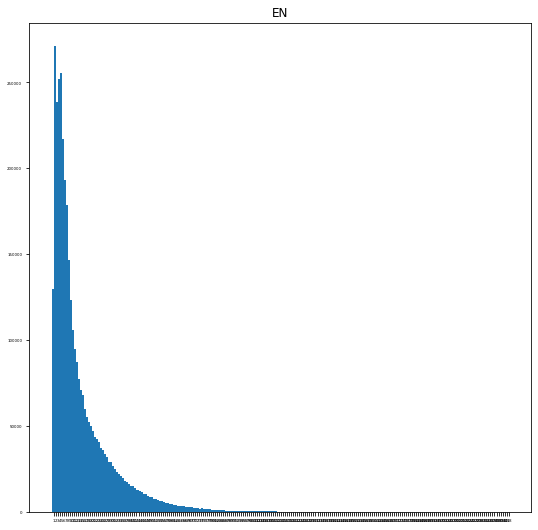

In [52]:
draw_bar_plot("EN", c.corpus_sentence_counter(pipeline[TOKENIZE].EN))
    

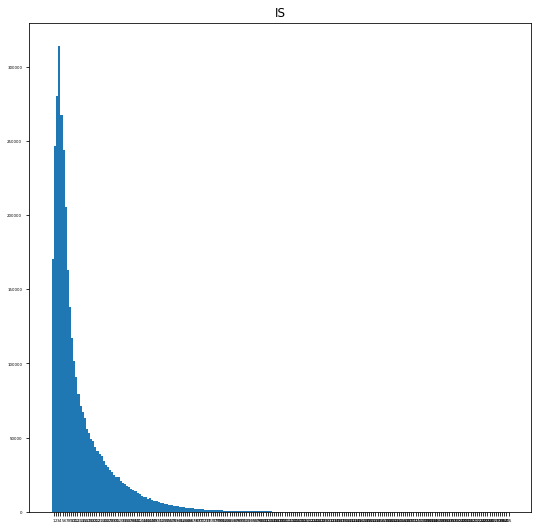

In [53]:
draw_bar_plot("IS", c.corpus_sentence_counter(pipeline[TOKENIZE].IS))
    

### Fjöldi tákna og tíðni

In [22]:
importlib.reload(c)
en_counter = c.corpus_token_counter(pipeline[TOKENIZE].EN)
is_counter = c.corpus_token_counter(pipeline[TOKENIZE].IS)
mim_is_counter = c.corpus_token_counter(mim_pipeline[TOKENIZE])

Fjöldi mismunandi orða.

In [23]:
pprint(len(en_counter))
pprint(len(is_counter))
pprint(len(mim_is_counter))

216511
633387
684243


Fjöldi orða.

In [34]:
pprint(f"{'Ensk orð: ':<20}{sum(value for key, value in en_counter.items()):>15}")
pprint(f"{'Íslensk orð: ':<20}{sum(value for key, value in is_counter.items()):>15}")
pprint(f"{'Íslensk MÍM orð: ':<20}{sum(value for key, value in mim_is_counter.items()):>15}")

'Ensk orð:                  51200311'
'Íslensk orð:               46782668'
'Íslensk MÍM orð:           27938715'


### Slæmar línur
Sumar línur innihalda ekki góð gögn. Dæmi um slæmar línur eru línur sem innihalda hvorki íslensk né enskar orð, íslenskar setningar innihalda mörg ensk orð, setningar sem innihalda mikið af texta úr öðru máli
3542841, 3543522, 3544806, 108198, 841961, 1926329, 694806, 2414852, 3543522, 1064877, 1138771, 1143444

In [ ]:
IS:('timing', 1),
 ('entering', 1),
 ('purchaser', 1),
    reductions
    лоза
    symptomatic
EN: Ψuχάρη
    Níκαια
    rūgušpiens
    Георги

In [56]:
word = "timing".casefold()
is_file = pipeline[TOKENIZE].IS.get_filepath()
en_file = pipeline[TOKENIZE].EN.get_filepath()
!grep -n -C 2 {word} {is_file}
!grep -n -C 2 {word} {en_file}

2215208-um breyttar skilgreiningar á undirvísitölum : commission regulation ( ec ) no 1749 / 1999 of 23 july 1999 amending regulation ( ec ) no 2214 / 96 , concerning the sub - indices of the harmonized indices of consumer prices ( oj l 214 , 13.8.1999 , p . 1 )
2215209-um reglur við að taka menntun og heilsugæslu inn í vísitöluna : council regulation ( ec ) no 2166 / 1999 of 8 october 1999 laying down detailed rules for the implementation of regulation ( ec ) no 2494 / 95 as regards minimum standards for the treatment of products in the health , education and social protection sectors in the harmonized index of consumer prices ( oj l 266 , 14.10.1999 , p . 1 )
2215210:um hvenær taka á verð með í útreikninginn : commision regulation ( ec ) no 2601 / 2000 of 17 november 2000 laying down detailed rules for the implementation of regulation ( ec ) no 2494 / 95 as regards the timing of entering purchaser prices into the harmonized index of consumer prices ( oj l 300 , 29.11.2000 , p . 14 )


--
454233-the assessment shall cover the phases and characteristics as indicated in table ii . 5 of annex ii to this tsi .
454234-• implementing the maintenance tsi
454235:• implementation procedure and timing
454236-• procedure
454237-the implementation of the specifications on maintenance equipment are based on the following general steps :
--
454240-step 2 :
454241-an economic study is carried out by both the infrastructure manager and the railway undertaking , on the basis of which the initial roster may be modified .
454242:• timing
454243-because of :
454244-• the time needed to build or modify the fixed installations , and to put into place the mobile toilet discharge trolleys ,
454245-• the principle by which compliance with interoperability requirements of the already existing fixed installations is only possible if incorporated into long - term renewal and repair schedules ,
454246:the timing of implementation will have to be negotiated between the infrastructure manager and 

--
912276-body weight may be the best indicator of physical development .
912277-measure ment of developmental landmarks is , therefore , recommended only when there is prior evidence that these endpoints will provide additional information .
912278:timing for the assessment of these parameters is indicated in table 1. depending on the anticipated effects , and the results of the initial measurements , it may be advisable to add ad ditional time points or to perform the measurements in other developmental stages .
912279-• it is advisable to use post - coital age instead of postnatal age when assessing physical development ( 33 ) .
912280-if pups are tested on the day of weaning , it is recommended that this testing be carried out prior to actual weaning to avoid a confounding effect by the stress associated with weaning .
912281-in addition , any post - weaning testing of pups should not occur during the two days after weaning .
912282-table 1
912283:timing of the assessment of physic

--
1376680-however , self - review threats can arise if , for example , there is not a clear separation between the management and control of the internal audit and the internal audit activities themselves , or if the statutory auditor's evaluation of his audit client's internal control system determines the kind and volume of his subsequent statutory audit procedures .
1376681-to avoid such threats , the statutory auditor , the audit firm or its network member must be able to show that it is not involved in management and control of the internal audit .
1376682:furthermore , in his capacity as the statutory auditor of the client's financial statements the statutory auditor must be able to demonstrate that he has taken appropriate steps to have the results of the internal audit work reviewed and has not placed undue reliance on these results in establishing the nature , timing and extent of his statutory audit work .
1376683-in order to ensure that the audit firm's statutory audit work

--
1932812-if you are not ovulating and have irregular or no periods
1932813-if you are not ovulating and have irregular or no periods .
1932814:if you are not ovulating and if the recommended dose and timing are followed , the occurrence of ohss is less likely .
1932815-if you are not ovulating , have no periods and have been diagnosed with very low levels of fsh and lh hormones
1932816-if you are not ovulating , having no periods and have been diagnosed with very low levels of fsh and lh hormones
--
1944478-immunogenicity and safety of ixiaro in children and adolescents from a jev - endemic country
1944479-immunogenicity and safety of prevenar 13 has been demonstrated in adults aged 18 years and older including those previously vaccinated with a pneumococcal polysaccharide vaccine .
1944480:immunogenicity assay results are highly dependent on several factors including assay sensitivity and specificity , assay methodology , assay robustness to quantities of gazyvaro / antibody in the 

2487683-i ain't gonna ask you again .
2487684-shut up , doris .
2487685:keep timing .
2487686-hey , mae , how long ?
2487687-boy , that was some good peeing .
--
2489599-if i leave it on the stock too long , it rots on the way to market .
2489600-too much rain turns it mouldy , too little and it's hog - feed .
2489601:timing's everything .
2489602-same as in my business .
2489603-you gotta pick'em while they're ripe .
--
2510883-good day , sir .
2510884-it's turning the eggs .
2510885:perfect timing .
2510886-i ‚ d hoped they ‚ d hatch before i had to go to the boat .
2510887-henry , why didn't you tell me ?
--
2513710-i started making notes about what he meant to me : surrogate father , mentor , you know .
2513711-i started to get very thirsty .
2513712:not the greatest timing .
2513713-you're here to study law , not keep me sober .
2513714-it's alice .
--
2522230-scar ?
2522231-drop him .
2522232:impeccable timing , your majesty .
2522233-why , if it isn't my big brother descending f

--
3408438-yes .
3408439-but she changed .
3408440:it's about timing .
3408441-and the first time around , we weren't ready to work at it and now we are .
3408442-and besides , caroline is way hotter than that voice in my head who sounds like tom waits and tells me i'm a failure and i look bad in hats .
--
3408483-take off your skis and wait for your family in the lodge , jessica day .
3408484-look , this could be good .
3408485:paul and i had bad timing before .
3408486-and maybe i should just give it another shot .
3408487-such an ugly crier .
--
3408793-and it made me realize something .
3408794-you're wrong .
3408795:all the stuff you said about caroline being about timing and it just making sense ?
3408796-because if you really love someone , it's simple .
3408797-i understand what you're saying , but - you deserve something amazing .
--
3424749-william is better looking .
3424750-and he's a great guy .
3424751:and she's here being a two - timing …
3424752-whore . montana . taylor

In [22]:
import random
pprint(random.sample(is_counter.most_common(), 100))

[('innlausnarmöguleiki', 4),
 ('asnareður', 1),
 ('30,77', 1),
 ('rík', 123),
 ('upphafssnertingu', 2),
 ('útblástursrásinni', 2),
 ('stöðustofnunarkerfis', 1),
 ('meðferðarlok', 54),
 ('sorlini', 2),
 ('knúningsaflsflokkur', 6),
 ('stuðningsáætlunin', 3),
 ('04837959', 1),
 ('levetirasetam', 1),
 ('ripstinker', 1),
 ('fullmótaðs', 1),
 ('ceftarólín', 47),
 ('vectra', 21),
 ('þjarmi', 1),
 ('meinaru', 1),
 ('múrarnir', 3),
 ('kórónusjáar', 1),
 ('fitufleyti', 1),
 ('kelið', 2),
 ('dansstaður', 1),
 ('mip', 11),
 ('reglusetningarkerfis', 1),
 ("gibbon'", 1),
 ('eftirlitsstjórnum', 5),
 ('skammtabúnaði', 1),
 ('rotnaði', 2),
 ('bokinni', 2),
 ('ráðabruggi', 7),
 ('þerrði', 3),
 ('húskytrunni', 1),
 ('þjóðlagasamkoma', 1),
 ('danskan', 4),
 ('2130', 4),
 ('óheillavænlegra', 1),
 ('kolefnisdísúlfíð', 2),
 ('lokaprófanir', 1),
 ('polymorphism', 2),
 ('hniklaði', 1),
 ('burutu', 1),
 ('saxa', 28),
 ('6.106', 1),
 ('beez', 14),
 ('00230', 1),
 ('skemmtun', 226),
 ('sýnatökunema', 39),
 ('resí

### Stokka gögn
Svo ruglum við línunum, en pössum að rugla textunum með sömu línum.

In [33]:
# the corpus_shuffle reads some bytes from the seed file and uses as a seed.
seed_file = pipeline[CAT].EN.get_filepath()
pipeline[SHUFFLE] = c.ParaCorpus(
    c.corpus_shuffle(pipeline[CAT].EN, seed_file=seed_file, stage=SHUFFLE),
    c.corpus_shuffle(pipeline[CAT].IS, seed_file=seed_file, stage=SHUFFLE)
)

In [34]:
print(*c.p_corpus_peek(pipeline[SHUFFLE]))

EN: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 IS: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 EN: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;
 IS: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 EN: Repeated-dose toxicity studies revealed vacuolation of the tubular cells of the kidneys, with strong evidence for reversibility of the effect.
 IS: Rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg.
 EN: Concomitant treatment with moderate CYP3A4 inhibitors (e.g., diltiazem, verapamil, clarithromycin, erythromycin, aprepitant, amiodarone) should only be administered with cauti

### Bæta við leppum
Við bætum við leppum í stað sumra stafa sem Moses skilur öðruvísi (og síðar í stað annarra sérstakra gilda eins og talna og nafna). Leppirnir eru markaðir með @-merki í byrjun og enda, t.d. @pipe@.

In [60]:
# u'\u007c' - |
pipe_reg = re.compile(r"\u007c")
# u'\u003c', u'\u003e' - <, >
lt_reg = re.compile(r"\u003c")
gt_reg = re.compile(r"\u003e")

# u'\u005b', u'\u005d' - [, ]
bracket_open_reg = re.compile(r"\u005b")
bracket_close_reg = re.compile(r"\u005d")

# We map these special characters to placeholders
regular_expressions = [
    (pipe_reg, '@pipe@'),
    (lt_reg, '@lt@'),
    (gt_reg, '@gt@'),
    (bracket_open_reg, '@brac_open@'),
    (bracket_close_reg, '@brac_close@')
]
pipeline[PLACEHOLDERS] = c.ParaCorpus(
    c.corpus_regexp(pipeline[TRUECASE].EN, regexps=regular_expressions, stage=PLACEHOLDERS),
    c.corpus_regexp(pipeline[TRUECASE].IS, regexps=regular_expressions, stage=PLACEHOLDERS)
)
print(*c.p_corpus_peek(pipeline[PLACEHOLDERS]))

EN: in these cases , smaller bilge wells to cover a reasonable period of time may be permitted .
 IS: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma .
 EN: • hazard classes 3.1 to 3.6 , 3.7 adverse effects on sexual function and fertility or on development , 3.8 effects other than narcotic effects , 3.9 and 3.10 ;
 IS: • hættuflokka 3.1 til 3.6 , 3.7 , skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun , 3.8 , áhrif önnur en sljóleiki , 3.9 og 3.10 ,
 EN: repeated - dose toxicity studies revealed vacuolation of the tubular cells of the kidneys , with strong evidence for reversibility of the effect .
 IS: rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg .
 EN: concomitant treatment with moderate CYP 3 A 4 inhibitors ( e.g. , diltiazem , verapamil , clarithromycin , erythromycin , aprepitant , amiodarone ) should on

In [63]:
corpus = pipeline[PLACEHOLDERS].EN.get_filepath()
!grep '@' -m 10 {corpus}

discontinue Revolade if ALT levels increase ( ≥ 3 x the upper limit of normal @brac_open@ ULN @brac_close@ in patients with normal liver function , or ≥ 3 x baseline or @gt@ 5 x ULN , whichever is the lower , in patients with pre - treatment elevations in transaminases ) and are :
moderate elevations in transaminase ( AST or ALT @gt@ 5 to ≤ 8 x ULN ) or total bilirubin ( @gt@ 3 to ≤ 5 x ULN ) levels
@brac_open@ gaseous / liquid @brac_close@
the dose may be increased after 4 weeks to 40 IU / kg , 3 times per week , if the increase in haemoglobin is not adequate ( @lt@ 1 g / dl @brac_open@ 0.62 mmol / l @brac_close@ within 4 weeks ) .
tol 1 - primary tolerance for the vehicle CO 2 characteristic curve @brac_open@ % @brac_close@ tol 2 - secondary tolerance for the vehicle CO 2 characteristic curve @brac_open@ % @brac_close@ tt - duration of a test @brac_open@ s @brac_close@
rivastigmine HEXAL 1.5 mg @brac_open@ folding box only @brac_close@
VI - instantaneous vehicle speed @brac_open@ km 

### Tungumála módel
Við notum svo KenLM tungumála módelið til þess að gefa okkur líkindi setninga. Til að flýta uppflettingum þá tungumála módelið samtímis kjörsniðið.

In [81]:
importlib.reload(c)
en_lm_model = c.kenlm_create(pipeline[PLACEHOLDERS].EN, stage=LM, order=3)
is_lm_model = c.kenlm_create(pipeline[PLACEHOLDERS].IS, stage=LM, order=3)

Prófa tungumála módel

In [8]:
print(c.kenlm_eval(is_lm_model, "þetta er flott íslensk setning , er það ekki ?"))
print(c.kenlm_eval(en_lm_model, "this is a nice English sentence , right ?"))

þetta=230 2 -1.9089104	er=4 3 -0.25080082	flott=642 3 -2.480758	íslensk=101858 1 -7.8264427	setning=25397 1 -5.0621104	,=14 2 -1.7306166	er=4 2 -2.1021233	það=137 3 -0.98709315	ekki=3 3 -0.76174337	?=165 3 -0.82030237	</s>=2 3 -0.010218243	Total: -23.94112 OOV: 0
Perplexity including OOVs:	150.12930288004378
Perplexity excluding OOVs:	150.12930288004378
OOVs:	0
Tokens:	11
Name:query	VmPeak:421144 kB	VmRSS:3888 kB	RSSMax:403756 kB	user:0	sys:0.056	CPU:0.056	real:0.0575499
this=133 2 -1.8217136	is=58 3 -0.66188765	a=24 3 -1.0184718	nice=3416 3 -2.860039	English=7099 1 -4.527742	sentence=5984 1 -5.0636005	,=33 2 -1.1142942	right=252 2 -3.7716594	?=160 3 -0.14599161	</s>=2 3 -0.034494855	Total: -21.019896 OOV: 0
Perplexity including OOVs:	126.47059313388736
Perplexity excluding OOVs:	126.47059313388736
OOVs:	0
Tokens:	10
Name:query	VmPeak:332148 kB	VmRSS:4096 kB	RSSMax:314968 kB	user:0	sys:0.048	CPU:0.048	real:0.047921


### Stytta/Hreinsa gögn
Við þurfum að stytta langar setningar, eyða tómum línum, fjarlægja óleyfilega unicode chars og pör af setningum sem eru of langar miðað við samhliða setningu. Við höldum setningum á milli 1 og 100 orð (til og með).

In [84]:
pipeline[LENGTH] = c.corpus_length_fix(pipeline[PLACEHOLDERS], stage=LENGTH, min_length=1, max_length=100),
print(*c.p_corpus_peek(pipeline[LENGTH]))

KeyboardInterrupt: 

### Skipta gögnum
Núna skiptum við gögnunum í train/val/test. Við reynum að hafa um 2000 setningar í val og 3000 setningar í test. Þessir hlutar eru skilgreindir í kóðanum, subbulega. 

Train gögnin eru nýtt í þjálfun á Moses, val í fínpússun og loks test til þess að meta þýðingarnar. Til þess að ná fram þessari skiptingu þá tökum við fyrstu línurnar fyrir train gögnin, svo val gögnin og síðustu línurnar fara í test gögnin. Þess vegna er mikilvægt að það sé búið að stokka gögnin á þessum tímapunkti.

In [11]:
def split_corpus_by_fraction(corpus, fraction, lang_id):
    first_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{fraction}', lang_id)
    second_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{1-fraction}', lang_id)
    sentence_count = !wc -l {corpus}
    sentence_count = int((sentence_count.get_nlstr().split(' ')[0]))
    print(sentence_count)
    
    first, second = int(fraction * sentence_count), int((1 - fraction) * sentence_count)
    print(first, second, first + second)
    
    !head -n {first} {corpus} > {first_part}
    !tail -n {second} {corpus} > {second_part}
    return (first_part, second_part)

def split_corpus_by_count(corpus, count, lang_id):
    sentence_count = !wc -l {corpus}
    sentence_count = int((sentence_count.get_nlstr().split(' ')[0]))
    print(sentence_count)
    first = sentence_count - count
    second = count
    print(first, second)
    
    first_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{first}', lang_id)
    second_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{second}', lang_id)
    
    !head -n {first} {corpus} > {first_part}
    !tail -n {second} {corpus} > {second_part}
    return (first_part, second_part)

def move(file_from, file_to):
    !mv {file_from} {file_to}
    return file_to

def split_corpora(corpora, val_count=2000, test_count=3000):
    result = defaultdict(dict)
    
    for lang_id, corpus in corpora.items():
        train, tmp = split_corpus_by_count(corpus, val_count + test_count, lang_id)
        val, test = split_corpus_by_count(tmp, test_count, lang_id)
        !rm {tmp}
        train = move(train, get_name(DATA_DIR, CORPUS_PREFIX, 'train', lang_id))
        val = move(val, get_name(DATA_DIR, CORPUS_PREFIX, 'val', lang_id))
        test = move(test, get_name(DATA_DIR, CORPUS_PREFIX, 'test', lang_id))
        result[lang_id]['train'] = train
        result[lang_id]['val'] = val
        result[lang_id]['test'] = test
    return result
        

In [12]:
split_para_corpus = split_corpora(place_para_corpus)

3543296
3538296 5000
5000
2000 3000
3543296
3538296 5000
5000
2000 3000


In [15]:
for lang_id, step_dict in split_para_corpus.items():
    for step in step_dict.keys():
        print_file_stats(split_para_corpus[lang_id][step])

/mnt/scratch/smt/data/full-para-train.en:		257M,		3538296
/mnt/scratch/smt/data/full-para-val.en:		152K,		2000
/mnt/scratch/smt/data/full-para-test.en:		216K,		3000
/mnt/scratch/smt/data/full-para-train.is:		278M,		3538296
/mnt/scratch/smt/data/full-para-val.is:		164K,		2000
/mnt/scratch/smt/data/full-para-test.is:		232K,		3000


In [16]:
for lang_id, step_dict in split_para_corpus.items():
    for step in step_dict.keys():
        !head -n 1 {split_para_corpus[lang_id][step]}
        !tail -n 1 {split_para_corpus[lang_id][step]}

they must not be performed on other fluids or secretions such as the aqueous or vitreous humour unless specifically justified clinically using a validated test for such a fluid .
diltiazem ( 180 to 360 mg once daily ) , a moderately potent CYP3A4 inhibitor , causes dose-dependent increases in average ranolazine steady-state concentrations of 1.5- to 2.4-fold .
E 920 L-CYSTEINE
• The examination procedure should be used for the adoption of implementing acts : determining whether certain categories of electrical or electronic products meet the definition of ‘ radio equipment ; laying down the opera tional rules for making the information on compliance available ; laying down the operational rules for registra tion and the operational rules for affixing the registration number on radio equipment ;
if you are male and your partner is pregnant or capable of becoming pregnant , you must use condoms during sexual intercourse while taking bexarotene and for at least one month after the last do

In [45]:
def get_sentence_number(corpora, sentence_number):
    import linecache
    return (linecache.getline(corpora[EN], sentence_number), linecache.getline(corpora[IS], sentence_number))

In [46]:
get_sentence_number(place_para_corpus, 2743447)

('additional object ( s ) @brac_open@ @brac_close@ @brac_open@ @brac_close@ . @brac_open@ @brac_close@ @brac_open@ @brac_close@ . @brac_open@ @brac_close@ @brac_open@ @brac_close@ . @brac_open@ @brac_close@ @brac_open@\n',
 'önnur viðfangsefni\n')

In [41]:
!grep -n "\[ \] \[ \]" {DATA_DIR}/full-para-cat.en

1239691:NUTS code [ ] [ ] [ ] [ ] [ ] NUTS code [ ] [ ] [ ] [ ] [ ]
1239692:NUTS code [ ] [ ] [ ] [ ] [ ] NUTS code [ ] [ ] [ ] [ ] [ ]
1239696:(if known, give figures only) Estimated cost excluding VAT: [ ] Currency: [ ] [ ] [ ]
1239699:between [ ] and [ ] Currency: [ ] [ ] [ ]
1239721:Service category No: [ ] [ ]
1239724:NUTS code [ ] [ ] [ ] [ ] [ ]
1239725:NUTS code [ ] [ ] [ ] [ ] [ ]
1239726:NUTS code [ NUTS code [ ] [ ] [ ] [ ] [ ] [
1239732:(if known, give figures only) Estimated cost excluding VAT: [ ] Currency: [ ] [ ] [ ]
1239735:between [ ] and [ ] Currency: [ ] [ ] [ ]
1239804:between [ ] and [ ] Currency: [ ] [ ] [ ] ]
1239910:NUTS code [ ] [ ] [ ] [ ] [ ]
1239911:NUTS code [ ] [ ] [ ] [ ] [ ]
1239912:NUTS code [ ] [ ] [ ] [ ] [ ]
1239913:NUTS code [ ] [ ] [ ] [ ] [ ]
1239919:O Framework agreement with several operators O Framework agreement with a single operator Number [ ] [ ] [ ]
1239921:(if applicable) maximum number [ ] [ ] [ ] of participants to the framework agreem

In [43]:
!grep -n "( )" {DATA_DIR}/full-para-cat.is

180140:„1. Skráin yfir verndaðar upprunatáknanir og verndaðar, landfræðilegar merkingar, sem framkvæmdastjórnin við- heldur eins og kveðið er á um í 118. gr. n í reglugerð ráðsins (EB) nr. ( ), hér á eftir nefnd „skráin“, er í rafræna gagnasafninu E-Bacchus.“
189249:Unnt er að greiða fyrir þessu ferli með því að taka mið af almennum eiginleikum fyrir 1. flokk, sem eru settir fram í 4. lið í III. viðauka, og viðeigandi, uppfærðum flokkunarkerfum, innlendum og alþjóðlegum (þar með talin tilskipun 90/679/EBE ( ) með áorðnum breytingum).
208139:Liðum sem varða ekki þessa tilskipun er sleppt. p(15mm)p( )
284927:með hliðsjón af reglugerð ráðsins (EB) nr. frá 22. október 2007 um sameiginlegt markaðskerfi í landbúnaði og um sértæk ákvæði varðandi tilteknar landbúnaðarvörur (reglugerðin um eitt sameiginlegt markaðskerfi) ( ), einkum þriðju málsgrein 121. gr.,
374454:• Í tilskipun Evrópuþingsins og ráðsins 96/57/EB frá 3. september 1996 um kröfur um orkunýtni rafknúinna kæliskápa, frystiskápa og

In [35]:
corpus = place_para_corpus[EN]
!grep "@brac_open@ @brac_close@ @brac_open@" {corpus}

duration in months : @brac_open@ @brac_close@ @brac_open@ @brac_close@ or in days : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ ( from the award of the contract )
duration in months : @brac_open@ @brac_close@ @brac_open@ @brac_close@ or in days : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ ( from the award of the contract )
number of offers received : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@
completion @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ ( ddlmm/yyyy )
Vl.4 ) Date of dispatch of this notice : @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_ope

until : @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ ( ddlmm/yyyy ) or
currency : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@
nuts code @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ NUTS code @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@
currency : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ Excluding VAT
( if yes , give figures only ) Price : @brac_open@ @brac_close@ Currency : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ Terms and method of payment :
contract No : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ Lot No : @brac_open@ @brac_close@ @brac_open@

( if applicable ) maximum number @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ of participants to the framework agreement envisaged
minimum number @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ and maximum number @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@
until : @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ / @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ ( ddlmm/yyyy ) or
notice number in the OJEU : @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ / $ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ - @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ @brac_open@ @brac_close@ of @brac_open@ @brac_close@ @brac_open@ @brac_close@ /

In [50]:
get_sentence_number(place_para_corpus, 2743447)

('additional object ( s ) @brac_open@ @brac_close@ @brac_open@ @brac_close@ . @brac_open@ @brac_close@ @brac_open@ @brac_close@ . @brac_open@ @brac_close@ @brac_open@ @brac_close@ . @brac_open@ @brac_close@ @brac_open@\n',
 'önnur viðfangsefni\n')

In [ ]:
354, 352 oft endurtekin,
2743447 - 2 (3?) vs 23
alignment issue
2497429 - 1 vs 10
1582050
771881

## Moses þjálfunar föll
Næstu föll snúa að þjálfun Moses og annarra atriða sem þarf að hafa í huga. Síðasta skrefið metur þýðingar Moses.

In [101]:
def train_moses(model_dir, corpus, lang_from, lang_to, lang_to_lm):
    result = !{MOSESDECODER}/scripts/training/train-model.perl -root-dir {model_dir} \
        -corpus {corpus} \
        -f {lang_from} -e {lang_to} \
        -alignment grow-diag-final-and -reordering msd-bidirectional-fe \
        -lm 0:3:{lang_to_lm}:8 \
        -mgiza -mgiza-cpus {THREADS} \
        -cores {THREADS} \
        -external-bin-dir {MOSESDECODER_TOOLS} &> {model_dir}/training.out
    return model_dir

In [102]:
def tune_moses(model_dir, corpus_val_from, corpus_val_to):
    tuned_dir = f'{model_dir}/tuned_model'
    !mkdir -p {tuned_dir}
    result = !{MOSESDECODER}/scripts/training/mert-moses.pl \
        {corpus_val_from} \
        {corpus_val_to} \
        {MOSESDECODER}/bin/moses {model_dir}/model/moses.ini \
        --mertdir {MOSESDECODER}/bin \
        --working-dir {tuned_dir} \
        --decoder-flags="-threads {THREADS}" &> {model_dir}/tune.out
    return tuned_dir

In [103]:
def prepare_binarisation(model_dir, moses_ini):
    binarised_dir = f'{model_dir}/binarised_model'
    !mkdir -p {binarised_dir}
    !cp {moses_ini} {binarised_dir}
    return binarised_dir
    
def binarise_phrase_table(model_dir, binarised_dir):
    binarised_phrase_table = f'{binarised_dir}/phrase-table'
    
    #Create the table
    !{MOSESDECODER}/bin/processPhraseTableMin \
        -in {model_dir}/model/phrase-table.gz \
        -nscores 4 \
        -out {binarised_phrase_table}
    
    # Adjust the path in the moses.ini file
    escaped_path = binarised_phrase_table.replace(r'/', '\/')
    !sed -i 's/PhraseDictionaryMemory/PhraseDictionaryCompact/' {binarised_dir}/moses.ini
    !sed -i 's/4 path=.*\.gz input-factor/4 path={escaped_path} input-factor/' {binarised_dir}/moses.ini

def binarise_reordering_table(model_dir, binarised_dir):
    binarised_reordering_table = f'{binarised_dir}/reordering-table'
    
    #Create the table
    !{MOSESDECODER}/bin/processLexicalTableMin \
        -in {model_dir}/model/reordering-table.wbe-msd-bidirectional-fe.gz \
        -out {binarised_reordering_table}
    
    # Adjust the path in the moses.ini file
    escaped_path = binarised_reordering_table.replace(r'/', '\/')
    !sed -i 's/0 path=.*\.gz$/0 path={escaped_path}/' {binarised_dir}/moses.ini


In [104]:
# It only makes sense to filter the model when you know what text the system needs to translate.
def filter_model(out_dir, moses_ini, corpus):
    !{MOSESDECODER}/scripts/training/filter-model-given-input.pl {out_dir} {moses_ini} {corpus}

def translate_corpus(moses_ini, corpus, corpus_translated):
    !{MOSESDECODER}/bin/moses \
        -f {moses_ini} < {corpus} > {corpus_translated}
    
def eval_translation(corpus_gold, corpus_translated):
    result = !{MOSESDECODER}/scripts/generic/multi-bleu.perl -lc {corpus_gold} < {corpus_translated}
    return result 

### Þjálfun EN-IS

In [21]:
for lang_id, step_dict in split_para_corpus.items():
    for step in step_dict.keys():
        print_file_stats(split_para_corpus[lang_id][step])
pprint(LM)

/mnt/scratch/smt/data/full-para-train.en:		257M,		3538296
/mnt/scratch/smt/data/full-para-val.en:		152K,		2000
/mnt/scratch/smt/data/full-para-test.en:		216K,		3000
/mnt/scratch/smt/data/full-para-train.is:		278M,		3538296
/mnt/scratch/smt/data/full-para-val.is:		164K,		2000
/mnt/scratch/smt/data/full-para-test.is:		232K,		3000
{'en': '/mnt/scratch/smt/data/full-para-lm_blm.en',
 'is': '/mnt/scratch/smt/data/full-para-lm_blm.is'}


In [58]:
# without the lang extension
model_dir = f'{MODEL_DIR}/{CORPUS_PREFIX}_{EN}-{IS}'
!mkdir -p {model_dir}

In [ ]:
print(f'tail -f {model_dir}/training.out')
train_moses(model_dir, f'{DATA_DIR}/full-para-train', EN, IS, f'{DATA_DIR}/full-para-lm_blm.is')

tail -f /home/staff/haukurpj/SMT/full-para_en-is/training.out


Þjálfunin tekur um 12 klst.
Til þess að sjá framgang þjálfunar - sjá útprent að ofan

### Fínpússun EN-IS

In [81]:
print(f'tail -f {model_dir}/tune.out')
tuned_dir = tune_moses(model_dir, f'{DATA_DIR}/full-para-val.en', f'{DATA_DIR}/full-para-val.is')
print(tuned_dir)

tail -f /home/staff/haukurpj/SMT/full-para_en-is/tune.out
/home/staff/haukurpj/SMT/full-para_en-is/tuned_model


Fínpússun getur tekið talsverðan tíma, allt frá 60 mín og meira.

### Pakka EN-IS
Við þjöppum töflunum sem við höfum lært. Við pössum okkur að vísa í fínpússuðu stillingarnar.

In [82]:
moses_ini = f'{model_dir}/tuned_model/moses.ini'
binarised_dir = prepare_binarisation(model_dir, moses_ini)
binarise_phrase_table(model_dir, binarised_dir)
binarise_reordering_table(model_dir, binarised_dir)
!ls {binarised_dir}

Used options:
	Text phrase table will be read from: /home/staff/haukurpj/SMT/full-para_en-is/model/phrase-table.gz
	Output phrase table will be written to: /home/staff/haukurpj/SMT/full-para_en-is/binarised_model/phrase-table.minphr
	Step size for source landmark phrases: 2^10=1024
	Source phrase fingerprint size: 16 bits / P(fp)=1.52588e-05
	Selected target phrase encoding: Huffman + PREnc
	Maxiumum allowed rank for PREnc: 100
	Number of score components in phrase table: 4
	Single Huffman code set for score components: no
	Using score quantization: no
	Explicitly included alignment information: yes
	Running with 32 threads

Pass 1/3: Creating hash function for rank assignment
..................................................[5000000]
..................................................[10000000]
..................................................[15000000]
..................................................[20000000]
..................................................[25000000]
..........

### Þýða texta og meta

In [85]:
#filter_model('out/filtered', 'out/model/run10.moses.ini', 'out/corpus.true.test.is')
translate_corpus(f'{binarised_dir}/moses.ini',  f'{DATA_DIR}/full-para-test.en', f'{model_dir}/test-translated.is')
print(eval_translation(f'{DATA_DIR}/full-para-test.is', f'{model_dir}/test-translated.is'))


Defined parameters (per moses.ini or switch):
	config: /home/staff/haukurpj/SMT/full-para_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.102077 0.0647167 0.0812548 0.0447185 0.00408817 0.0781141 Distortion0= 0.022406 LM0= 0.156338 WordPenalty0= -0.163195 PhrasePenalty0= -0.0546366 TranslationModel0= 0.0961962 0.0472685 0.0825315 -0.00245854 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
Fea

Line 29: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 29: Search took 0.003 seconds
Line 29: Decision rule took 0.000 seconds total
Line 29: Additional reporting took 0.000 seconds total
Line 29: Translation took 0.054 seconds total
Translating: establishment , maintenance and publication of trusted lists 
Line 30: Initialize search took 0.000 seconds total
Line 25: Collecting options took 0.612 seconds at moses/Manager.cpp Line 141
Line 25: Search took 0.049 seconds
Line 25: Decision rule took 0.000 seconds total
Line 25: Additional reporting took 0.000 seconds total
Line 25: Translation took 0.661 seconds total
Translating: that 's for shit , man ! 
Line 31: Initialize search took 0.000 seconds total
Line 2: Collecting options took 5.092 seconds at moses/Manager.cpp Line 141
Line 2: Search took 0.016 seconds
Line 2: Decision rule took 0.000 seconds total
Line 2: Additional reporting took 0.000 seconds total
Line 2: Translation took 5.109 seconds total
Tran

Line 31: Search took 0.250 seconds
Line 31: Decision rule took 0.000 seconds total
Line 31: Additional reporting took 0.000 seconds total
Line 31: Translation took 6.355 seconds total
Translating: acid reflux disease ( heartburn , pain or difficulty swallowing ) , flatulence/passing wind 
Line 52: Initialize search took 0.000 seconds total
Line 36: Collecting options took 4.943 seconds at moses/Manager.cpp Line 141
Line 36: Search took 0.702 seconds
Line 36: Decision rule took 0.000 seconds total
Line 36: Additional reporting took 0.000 seconds total
Line 36: Translation took 5.645 seconds total
Translating: United STATES 
Line 53: Initialize search took 0.000 seconds total
Line 53: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 53: Search took 0.002 seconds
Line 53: Decision rule took 0.000 seconds total
Line 53: Additional reporting took 0.000 seconds total
Line 53: Translation took 0.010 seconds total
Translating: note on p r o c e d u r e 
Line 54: Initial

Line 64: Collecting options took 1.361 seconds at moses/Manager.cpp Line 141
Line 42: Search took 0.494 seconds
Line 42: Decision rule took 0.000 seconds total
Line 42: Additional reporting took 0.000 seconds total
Line 42: Translation took 8.544 seconds total
Translating: ( b ) the name of the seller or supplier , if available ; 
Line 72: Initialize search took 0.000 seconds total
Line 64: Search took 0.656 seconds
Line 64: Decision rule took 0.000 seconds total
Line 64: Additional reporting took 0.000 seconds total
Line 64: Translation took 2.018 seconds total
Translating: this Decision shall be applicable from 1 January 1993 . 
Line 73: Initialize search took 0.000 seconds total
Line 69: Collecting options took 0.821 seconds at moses/Manager.cpp Line 141
Line 10: Collecting options took 16.570 seconds at moses/Manager.cpp Line 141
Line 13: Collecting options took 16.571 seconds at moses/Manager.cpp Line 141
Line 69: Search took 0.204 seconds
Line 69: Decision rule took 0.000 seconds

Line 92: Collecting options took 0.696 seconds at moses/Manager.cpp Line 141
Line 92: Search took 0.295 seconds
Line 92: Decision rule took 0.000 seconds total
Line 92: Additional reporting took 0.000 seconds total
Line 92: Translation took 0.991 seconds total
Translating: our town is drying up . 
Line 93: Initialize search took 0.000 seconds total
Line 89: Collecting options took 1.434 seconds at moses/Manager.cpp Line 141
Line 90: Collecting options took 1.798 seconds at moses/Manager.cpp Line 141
Line 0: Collecting options took 22.608 seconds at moses/Manager.cpp Line 141
Line 90: Search took 0.117 seconds
Line 90: Decision rule took 0.000 seconds total
Line 90: Additional reporting took 0.000 seconds total
Line 90: Translation took 1.915 seconds total
Translating: E 203 additional page No 3 ITEM 12 ( 12.8 ) ADDITIONAL INFORMATION FOR THE PURPOSES OF PORTUGUESE INSTITUTIONS 
Line 94: Initialize search took 0.000 seconds total
Line 89: Search took 0.715 seconds
Line 89: Decision rule

Line 108: Search took 0.261 seconds
Line 108: Decision rule took 0.000 seconds total
Line 108: Additional reporting took 0.000 seconds total
Line 108: Translation took 1.140 seconds total
Translating: shells and their service equipment intended for the carriage of substances of 1o b ) and c ) of marginal 2501 shall be so designed as to prevent the entry of foreign matter , leakage of liquid or any building up of dangerous excess pressure inside the shell due to the decomposition of the substances carried ' . 
Line 109: Initialize search took 0.002 seconds total
Line 8: Collecting options took 27.782 seconds at moses/Manager.cpp Line 141
Line 81: Collecting options took 8.473 seconds at moses/Manager.cpp Line 141
Line 59: Search took 1.926 seconds
Line 59: Decision rule took 0.000 seconds total
Line 59: Additional reporting took 0.000 seconds total
Line 59: Translation took 14.664 seconds total
Translating: as there is no directly observable price or quantity that is truly representativ

Line 122: Search took 0.209 seconds
Line 122: Decision rule took 0.000 seconds total
Line 122: Additional reporting took 0.000 seconds total
Line 122: Translation took 0.402 seconds total
Translating: am I a go to retrieve ? 
Line 126: Initialize search took 0.000 seconds total
Line 123: Collecting options took 0.262 seconds at moses/Manager.cpp Line 141
Line 123: Search took 0.018 seconds
Line 123: Decision rule took 0.000 seconds total
Line 123: Additional reporting took 0.000 seconds total
Line 123: Translation took 0.280 seconds total
Translating: the current estimate of the median survival of the previously untreated and treated patients was 7.7 and 4.7 months , respectively . 
Line 127: Initialize search took 0.000 seconds total
Line 34: Search took 3.036 seconds
BEST TRANSLATION: • Til að tryggja samræmi við núgildandi færslu 12 í V viðauka við reglugerð ( Reglugerð Evrópuþingsins og ráðsins ) númer 1107 / 2009 , skal ráðlögðum hámarksstyrk , 0,19% sem esterar fyrir efnin sem ta

Line 134: Collecting options took 0.108 seconds at moses/Manager.cpp Line 141
Line 132: Collecting options took 0.297 seconds at moses/Manager.cpp Line 141
Line 134: Search took 0.154 seconds
Line 134: Decision rule took 0.000 seconds total
Line 134: Additional reporting took 0.000 seconds total
Line 134: Translation took 0.262 seconds total
Translating: red Draw , Regular Group . 
Line 135: Initialize search took 0.000 seconds total
Line 120: Collecting options took 2.262 seconds at moses/Manager.cpp Line 141
Line 135: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 115: Collecting options took 3.585 seconds at moses/Manager.cpp Line 141
Line 126: Collecting options took 1.888 seconds at moses/Manager.cpp Line 141
Line 135: Search took 0.089 seconds
Line 135: Decision rule took 0.000 seconds total
Line 135: Additional reporting took 0.000 seconds total
Line 135: Translation took 0.096 seconds total
Translating: • When the test chemical is administered by gavag

Line 143: Collecting options took 0.135 seconds at moses/Manager.cpp Line 141
Line 143: Search took 0.067 seconds
Line 143: Decision rule took 0.000 seconds total
Line 143: Additional reporting took 0.000 seconds total
Line 143: Translation took 0.202 seconds total
Translating: implementing measures 
Line 145: Initialize search took 0.000 seconds total
Line 145: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 131: Collecting options took 2.236 seconds at moses/Manager.cpp Line 141
Line 145: Search took 0.003 seconds
Line 145: Decision rule took 0.000 seconds total
Line 145: Additional reporting took 0.000 seconds total
Line 145: Translation took 0.050 seconds total
Translating: No truck or vehicle which has been used for the transport of pigs may leave the zone without being cleaned and disinfected and then inspected and re-authorised for transport by the competent authority ; 
Line 146: Initialize search took 0.001 seconds total
Line 140: Search took 0.329 sec

Line 162: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 162: Search took 0.026 seconds
Line 162: Decision rule took 0.000 seconds total
Line 162: Additional reporting took 0.000 seconds total
Line 162: Translation took 0.045 seconds total
Translating: enough , enough . all right ? 
Line 163: Initialize search took 0.000 seconds total
Line 159: Search took 0.211 seconds
Line 159: Decision rule took 0.000 seconds total
Line 159: Additional reporting took 0.000 seconds total
Line 159: Translation took 0.336 seconds total
Translating: ye can not serve God and mammon . 
Line 164: Initialize search took 0.000 seconds total
Line 128: Search took 2.344 seconds
Line 128: Decision rule took 0.000 seconds total
Line 128: Additional reporting took 0.000 seconds total
Line 128: Translation took 5.374 seconds total
Translating: • As regards fosthiazate , the Scientific Committee was asked to comment on the potential for leaching to groundwater , on the risk to soil dwellin

Line 115: Search took 4.435 seconds
Line 115: Decision rule took 0.000 seconds total
Line 115: Additional reporting took 0.000 seconds total
Line 115: Translation took 8.023 seconds total
Translating: bananas Dates Figs Kiwis 
Line 185: Initialize search took 0.000 seconds total
Line 185: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 185: Search took 0.006 seconds
Line 185: Decision rule took 0.000 seconds total
Line 185: Additional reporting took 0.000 seconds total
Line 185: Translation took 0.008 seconds total
Translating: 10 01 13* fly ash from emulsified hydrocarbons used as fuel 
Line 186: Initialize search took 0.000 seconds total
Line 152: Search took 0.715 seconds
Line 152: Decision rule took 0.000 seconds total
Line 152: Additional reporting took 0.000 seconds total
Line 152: Translation took 2.074 seconds total
Translating: • shall each expire as soon as the endorsed certificate of competency or certificate of proficiency issued to masters and offi

Line 196: Collecting options took 0.813 seconds at moses/Manager.cpp Line 141
Line 189: Collecting options took 1.303 seconds at moses/Manager.cpp Line 141
Line 203: Collecting options took 0.387 seconds at moses/Manager.cpp Line 141
Line 194: Collecting options took 1.034 seconds at moses/Manager.cpp Line 141
Line 160: Search took 2.054 seconds
Line 160: Decision rule took 0.000 seconds total
Line 160: Additional reporting took 0.000 seconds total
Line 160: Translation took 2.893 seconds total
Translating: the whole thing was a plot ! 
Line 205: Initialize search took 0.000 seconds total
Line 180: Search took 0.743 seconds
Line 180: Decision rule took 0.000 seconds total
Line 180: Additional reporting took 0.000 seconds total
Line 180: Translation took 1.974 seconds total
Translating: for this purpose , Member States shall consider , for example , the setting of targets for the purchasing of products meeting the criteria specified in that Manual . 
Line 206: Initialize search took 0.0

Line 118: Search took 4.293 seconds
BEST TRANSLATION: • Umsækjandi sem sækir um undanþágu samkvæmt 4. málsgrein 11. grein reglugerðar ( Reglugerð Evrópuþingsins og ráðsins ) númer 1107 / 2009 , skal leggja fram gögnin sem um getur í b - lið 1. málsgrein þessarar greinar , einungis fyrir almanaksárið á undan umsóknardeginum . [111111111111111111111111111111111111111111111111]  [total=-14.585] core=(0.000,-46.000,13.000,-9.771,-60.282,-16.932,-93.961,-3.107,0.000,0.000,-7.021,0.000,0.000,0.000,-101.029)  
BEST TRANSLATION: dýrarannsóknir benda til þess að frjósemi karla og kvenna geti orðið fyrir áhrifum af meðferð með pazópaníbi stendur ( sjá kafla 5.3 ) . [111111111111111111111]  [total=-8.522] core=(0.000,-24.000,6.000,-5.199,-26.332,-8.486,-44.988,-1.456,0.000,0.000,-1.941,0.000,0.000,0.000,-61.025)  
BEST TRANSLATION: sjá kafla 4.4 fyrir nánari upplýsingar um eftirlit með sjúklingi ef grunur leikur á ofnæmisviðbrögðum við Triumeq . [111111111111111111111]  [total=-10.938] core=(0.00

Translating: • Basic studies 
Line 221: Initialize search took 0.000 seconds total
Line 218: Collecting options took 0.173 seconds at moses/Manager.cpp Line 141
Line 218: Search took 0.003 seconds
Line 218: Decision rule took 0.000 seconds total
Line 218: Additional reporting took 0.000 seconds total
Line 218: Translation took 0.176 seconds total
Translating: I was in the other car . 
Line 222: Initialize search took 0.000 seconds total
Line 201: Collecting options took 1.743 seconds at moses/Manager.cpp Line 141
Line 221: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 221: Search took 0.020 seconds
Line 221: Decision rule took 0.000 seconds total
Line 221: Additional reporting took 0.000 seconds total
Line 221: Translation took 0.045 seconds total
Translating: we 're going to nail him . 
Line 223: Initialize search took 0.000 seconds total
Line 222: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 212: Collecting options took 0.884 sec

Line 240: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 206: Search took 1.781 seconds
Line 206: Decision rule took 0.000 seconds total
Line 206: Additional reporting took 0.000 seconds total
Line 206: Translation took 2.792 seconds total
Line 201: Search took 1.672 seconds
Line 201: Decision rule took 0.000 seconds total
Line 201: Additional reporting took 0.000 seconds total
Line 201: Translation took 3.416 seconds total
Translating: Member States shall submit to the Commission in aggregated form , the information referred to in the first subparagraph . 
Line 242: Initialize search took 0.001 seconds total
Line 200: Search took 2.650 seconds
Line 200: Decision rule took 0.000 seconds total
Line 200: Additional reporting took 0.000 seconds total
Line 200: Translation took 3.500 seconds total
Translating: okay . 
Line 243: Initialize search took 0.000 seconds total
Translating: I wish she 'd kept it . 
Line 244: Initialize search took 0.000 seconds total
Line

Line 256: Collecting options took 0.319 seconds at moses/Manager.cpp Line 141
Line 255: Collecting options took 0.558 seconds at moses/Manager.cpp Line 141
Line 261: Collecting options took 0.195 seconds at moses/Manager.cpp Line 141
Line 260: Collecting options took 0.346 seconds at moses/Manager.cpp Line 141
Line 246: Search took 0.631 seconds
Line 246: Decision rule took 0.000 seconds total
Line 246: Additional reporting took 0.000 seconds total
Line 246: Translation took 1.096 seconds total
Translating: • This Regulation respects the fundamental rights and observes the principles recognised in particular by the Charter , notably the protection of personal data , the freedom of expression and information , the freedom to conduct a business , non-discrimination and consumer protection . 
Line 263: Initialize search took 0.001 seconds total
Line 261: Search took 0.163 seconds
Line 261: Decision rule took 0.000 seconds total
Line 261: Additional reporting took 0.000 seconds total
Line 

Line 278: Search took 0.229 seconds
Line 278: Decision rule took 0.000 seconds total
Line 278: Additional reporting took 0.000 seconds total
Line 278: Translation took 0.341 seconds total
Translating: No , nothing that I ca n't cancel . okay . 
Line 284: Initialize search took 0.000 seconds total
Line 268: Search took 0.341 seconds
Line 268: Decision rule took 0.000 seconds total
Line 268: Additional reporting took 0.000 seconds total
Line 268: Translation took 0.601 seconds total
Line 283: Search took 0.015 seconds
Line 283: Decision rule took 0.000 seconds total
Line 283: Additional reporting took 0.000 seconds total
Line 283: Translation took 0.017 seconds total
Translating: EXO.25.28 
Line 285: Initialize search took 0.000 seconds total
Line 285: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 285: Search took 0.000 seconds
Line 285: Decision rule took 0.000 seconds total
Line 285: Additional reporting took 0.000 seconds total
Line 285: Translation took 0.0

Line 248: Search took 1.928 seconds
Line 248: Decision rule took 0.000 seconds total
Line 248: Additional reporting took 0.000 seconds total
Line 248: Translation took 3.089 seconds total
Translating: yet his meat in his bowels is turned , it is the gall of asps within him . 
Line 304: Initialize search took 0.000 seconds total
Line 287: Collecting options took 0.846 seconds at moses/Manager.cpp Line 141
Line 270: Search took 0.393 seconds
Line 270: Decision rule took 0.000 seconds total
Line 270: Additional reporting took 0.000 seconds total
Line 270: Translation took 1.403 seconds total
Translating: if the lamp glass ( or glasses ) extend ( s ) over part only of the full aperture of the reflector , then the projection of that part only is taken into account . 
Line 305: Initialize search took 0.001 seconds total
Line 297: Search took 0.171 seconds
Line 297: Decision rule took 0.000 seconds total
Line 297: Additional reporting took 0.000 seconds total
Line 297: Translation took 0.214 

Line 310: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 310: Search took 0.053 seconds
Line 310: Decision rule took 0.000 seconds total
Line 310: Additional reporting took 0.000 seconds total
Line 310: Translation took 0.081 seconds total
Translating: chemical name 7,8-Dimethyl-10- ( D-ribo-2,3,4,5-tetrahydroxypentyl ) benzo ( g ) pteridine- 2,4 ( 3H,10H ) -dione ; 7,8-dimethyl-10- ( 1′-D-ribityl ) isoalloxazine 
Line 311: Initialize search took 0.000 seconds total
Line 298: Search took 0.407 seconds
Line 298: Decision rule took 0.000 seconds total
Line 298: Additional reporting took 0.000 seconds total
Line 298: Translation took 0.499 seconds total
Translating: God . - l 'll drag your ass out of here . 
Line 312: Initialize search took 0.000 seconds total
Line 309: Collecting options took 0.163 seconds at moses/Manager.cpp Line 141
Line 309: Search took 0.003 seconds
Line 309: Decision rule took 0.000 seconds total
Line 309: Additional reporting took 0.000 s

Line 305: Collecting options took 0.699 seconds at moses/Manager.cpp Line 141
Translating: semantic interoperability implies that the electronic invoice contains a certain amount of required information , and that the precise meaning of the exchanged infor mation is preserved and understood in an unambiguous manner , independently of the way in which it is physi cally represented or transmitted . 
Line 319: Initialize search took 0.003 seconds total
Line 318: Collecting options took 0.077 seconds at moses/Manager.cpp Line 141
Line 317: Collecting options took 0.150 seconds at moses/Manager.cpp Line 141
Line 299: Search took 0.394 seconds
Line 299: Decision rule took 0.000 seconds total
Line 299: Additional reporting took 0.000 seconds total
Line 299: Translation took 0.890 seconds total
Translating: • This Directive lays down limited exceptions for certain correlation trading activities , in accordance with which an institution may be permitted by its supervisor to calculate a comprehe

Line 311: Collecting options took 1.065 seconds at moses/Manager.cpp Line 141
Line 328: Search took 0.057 seconds
Line 328: Decision rule took 0.000 seconds total
Line 328: Additional reporting took 0.000 seconds total
Line 328: Translation took 0.160 seconds total
Translating: the solution obtained contains about 1,5 g of diazomethane in 100 ml of diethyl ether . 
Line 331: Initialize search took 0.000 seconds total
Line 327: Collecting options took 0.241 seconds at moses/Manager.cpp Line 141
Line 324: Search took 0.206 seconds
Line 324: Decision rule took 0.000 seconds total
Line 324: Additional reporting took 0.000 seconds total
Line 324: Translation took 0.299 seconds total
Translating: fight ! fight ! 
Line 332: Initialize search took 0.000 seconds total
Line 332: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 331: Collecting options took 0.083 seconds at moses/Manager.cpp Line 141
Line 332: Search took 0.051 seconds
Line 332: Decision rule took 0.000 sec

Translating: leave him alone . 
Line 342: Initialize search took 0.000 seconds total
Line 290: Search took 1.886 seconds
Line 290: Decision rule took 0.000 seconds total
Line 290: Additional reporting took 0.000 seconds total
Line 290: Translation took 2.536 seconds total
Translating: in a product as referred to in Article 1 ( 1 ) , an ingredient obtained according to the rules laid down in Article 6 shall not be present together with the same ingredient not obtained according to those rules . 
Line 343: Initialize search took 0.001 seconds total
Line 329: Collecting options took 0.577 seconds at moses/Manager.cpp Line 141
Line 336: Search took 0.110 seconds
Line 336: Decision rule took 0.000 seconds total
Line 336: Additional reporting took 0.000 seconds total
Line 336: Translation took 0.225 seconds total
Translating: I am calm . 
Line 344: Initialize search took 0.000 seconds total
Line 344: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 342: Collecting opt

Translating: the maximum volume which can be withdrawn at one time is 5 ml ( equivalent to 500 mg tipranavir ) , which is the maximum single dose for a child with BSA @gt@ 1.33 m2 . 
Line 357: Initialize search took 0.002 seconds total
Line 327: Search took 1.193 seconds
Line 327: Decision rule took 0.000 seconds total
Line 327: Additional reporting took 0.000 seconds total
Line 327: Translation took 1.434 seconds total
Translating: GreRinse-off products 
Line 358: Initialize search took 0.000 seconds total
Line 348: Collecting options took 0.699 seconds at moses/Manager.cpp Line 141
Line 353: Search took 0.371 seconds
Line 353: Decision rule took 0.000 seconds total
Line 353: Additional reporting took 0.000 seconds total
Line 353: Translation took 0.458 seconds total
Translating: and this will we do , if God permit . 
Line 359: Initialize search took 0.000 seconds total
Line 358: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 358: Search took 0.000 seconds
Li

Line 334: Search took 1.005 seconds
Line 334: Decision rule took 0.000 seconds total
Line 334: Additional reporting took 0.000 seconds total
Line 334: Translation took 1.530 seconds total
Translating: • survivors ' benefits ; 
Line 373: Initialize search took 0.000 seconds total
Line 371: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 359: Search took 0.376 seconds
Line 359: Decision rule took 0.000 seconds total
Line 359: Additional reporting took 0.000 seconds total
Line 359: Translation took 0.478 seconds total
Translating: code 
Line 374: Initialize search took 0.000 seconds total
Line 374: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 374: Search took 0.000 seconds
Line 374: Decision rule took 0.000 seconds total
Line 374: Additional reporting took 0.000 seconds total
Line 374: Translation took 0.006 seconds total
Translating: hold on . 
Line 375: Initialize search took 0.000 seconds total
Line 354: Collecting options took 0.863

Translating: • Protection against electromagnetic disturbance requires obligations to be imposed on the various economic oper ators . 
Line 393: Initialize search took 0.000 seconds total
Line 388: Search took 0.154 seconds
Line 388: Decision rule took 0.000 seconds total
Line 388: Additional reporting took 0.000 seconds total
Line 388: Translation took 0.251 seconds total
Translating: ORA.GEN.130 Changes to organisations 
Line 394: Initialize search took 0.000 seconds total
Line 394: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 391: Collecting options took 0.126 seconds at moses/Manager.cpp Line 141
Line 376: Search took 0.693 seconds
Line 376: Decision rule took 0.000 seconds total
Line 376: Additional reporting took 0.000 seconds total
Line 376: Translation took 1.157 seconds total
Line 394: Search took 0.030 seconds
Line 394: Decision rule took 0.000 seconds total
Line 394: Additional reporting took 0.000 seconds total
Line 394: Translation took 0.039 se

Translating: the additional adverse reactions listed by system organ class and ranked by frequency in Table 2 were reported at incidence rates greater than placebo for subjects treated with celecoxib 400 mg to 800 mg daily in long-term polyp prevention trials of duration up to 3 years ( the APC and PreSAP trials ; 
Line 411: Initialize search took 0.004 seconds total
Line 383: Search took 1.085 seconds
Line 383: Decision rule took 0.000 seconds total
Line 383: Additional reporting took 0.000 seconds total
Line 383: Translation took 1.452 seconds total
Line 391: Search took 0.601 seconds
Line 391: Decision rule took 0.000 seconds total
Line 391: Additional reporting took 0.000 seconds total
Line 391: Translation took 0.728 seconds total
Translating: Annex : VI 
Line 412: Initialize search took 0.000 seconds total
Line 412: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Translating: • If the results referred to in point 2 ( a ) or ( b ) are not achieved , the model a

Line 429: Collecting options took 0.109 seconds at moses/Manager.cpp Line 141
Line 416: Search took 0.368 seconds
Line 416: Decision rule took 0.000 seconds total
Line 416: Additional reporting took 0.000 seconds total
Line 416: Translation took 0.769 seconds total
Translating: these samples may also be used to evaluate the rate of false-non- compliant results . 
Line 434: Initialize search took 0.000 seconds total
Line 413: Collecting options took 1.189 seconds at moses/Manager.cpp Line 141
Line 410: Collecting options took 1.345 seconds at moses/Manager.cpp Line 141
Line 428: Search took 0.173 seconds
Line 428: Decision rule took 0.000 seconds total
Line 428: Additional reporting took 0.000 seconds total
Line 428: Translation took 0.268 seconds total
Translating: ( c ) take steps to facilitate equal opportunities , in particular by raising awareness among all relevant actors ; 
Line 435: Initialize search took 0.000 seconds total
Line 429: Search took 0.113 seconds
Line 429: Decision

Translating: who are you ? 
Line 445: Initialize search took 0.000 seconds total
Line 432: Collecting options took 0.969 seconds at moses/Manager.cpp Line 141
Line 435: Collecting options took 0.820 seconds at moses/Manager.cpp Line 141
Line 445: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Line 443: Collecting options took 0.220 seconds at moses/Manager.cpp Line 141
Line 445: Search took 0.056 seconds
Line 445: Decision rule took 0.000 seconds total
Line 445: Additional reporting took 0.000 seconds total
Line 445: Translation took 0.117 seconds total
Translating: well , you already risked theirs . 
Line 446: Initialize search took 0.000 seconds total
Line 434: Search took 0.686 seconds
Line 434: Decision rule took 0.000 seconds total
Line 434: Additional reporting took 0.000 seconds total
Line 434: Translation took 1.013 seconds total
Translating: there he met Grim the red , Flosi 's kinsman , and as soon as ever they met , Thorhall thrust at him with the spear 

Line 460: Collecting options took 0.359 seconds at moses/Manager.cpp Line 141
Line 461: Search took 0.216 seconds
Line 461: Decision rule took 0.000 seconds total
Line 461: Additional reporting took 0.000 seconds total
Line 461: Translation took 0.333 seconds total
Translating: boot this kernel/ OS if the user does not make a different choice 
Line 465: Initialize search took 0.000 seconds total
Line 385: Search took 3.743 seconds
BEST TRANSLATION: hreinsistöðina skal taka mið af þeim gögnum sem tengjast hráefnum ( sú tegund samlokueldisstöðvum , á landsvæði þess microbe|UNK|UNK|UNK efni og svo framvegis ) ef nauðsynlegt er að framlengja tímabil nægi til að tryggja að lifandi samlokur ( tvískelja lindýr ) , TIL BAKTERÍUFRÆÐILEGRA GREININGA fullnægja kröfum V kafla þessa viðauka . [11111111111111111111111111111111111111111111111111111111111111]  [total=-143.282] core=(-100.000,-52.000,20.000,-41.386,-118.042,-33.926,-129.529,-3.882,-8.026,-6.097,-4.430,-6.217,-5.715,-22.000,-230.651)  


Line 465: Collecting options took 0.283 seconds at moses/Manager.cpp Line 141
Line 456: Search took 0.731 seconds
Line 456: Decision rule took 0.000 seconds total
Line 456: Additional reporting took 0.000 seconds total
Line 456: Translation took 0.865 seconds total
Line 463: Collecting options took 0.506 seconds at moses/Manager.cpp Line 141
Translating: • The Commission shall manage a European Central Repository to store all occurrence reports collected in the Union . 
Line 473: Initialize search took 0.000 seconds total
Line 464: Collecting options took 0.483 seconds at moses/Manager.cpp Line 141
Line 410: Search took 2.503 seconds
BEST TRANSLATION: í þessari skilgreiningu verður skipt út fyrir að til séu samhæfðir á vettvangi Bandalagsins , sem veitir heimaríkinu markað ábyrgð í málum sem þessi tilskipun á umbreytingartímabili vátryggingafélagsins , sem veitir heimaríkinu ; [11111111111111111111111111111111111111111]  [total=-31.036] core=(0.000,-33.000,13.000,-30.561,-108.783,-23.4

Line 489: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 488: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 490: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 480: Collecting options took 0.348 seconds at moses/Manager.cpp Line 141
Line 490: Search took 0.121 seconds
Line 490: Decision rule took 0.000 seconds total
Line 490: Additional reporting took 0.000 seconds total
Line 490: Translation took 0.167 seconds total
Line 479: Search took 0.314 seconds
Line 479: Decision rule took 0.000 seconds total
Line 479: Additional reporting took 0.000 seconds total
Line 479: Translation took 0.535 seconds total
Translating: 11 ( b ) Components made of polyester shall comply with Textile fibre criteria 7 ( a ) and 7 ( c ) regarding antimony content and the emission of VOCs during polymerisation . 
Line 491: Initialize search took 0.001 seconds total
Translating: thy terribleness hath deceived thee , and the pride of th

Line 502: Collecting options took 0.178 seconds at moses/Manager.cpp Line 141
Line 507: Collecting options took 0.110 seconds at moses/Manager.cpp Line 141
Line 504: Search took 0.105 seconds
Line 504: Decision rule took 0.000 seconds total
Line 504: Additional reporting took 0.000 seconds total
Line 504: Translation took 0.147 seconds total
Line 505: Collecting options took 0.145 seconds at moses/Manager.cpp Line 141
Translating: I 'll be doing this every day . 
Line 508: Initialize search took 0.000 seconds total
Line 502: Search took 0.139 seconds
Line 502: Decision rule took 0.000 seconds total
Line 502: Additional reporting took 0.000 seconds total
Line 502: Translation took 0.317 seconds total
Translating: Bradbury Apartments , Ninth Sector , N.F . 46751 . 
Line 509: Initialize search took 0.000 seconds total
Line 509: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 500: Search took 0.319 seconds
Line 500: Decision rule took 0.000 seconds total
Line 500: 

Line 523: Collecting options took 0.227 seconds at moses/Manager.cpp Line 141
Line 525: Search took 0.071 seconds
Line 525: Decision rule took 0.000 seconds total
Line 525: Additional reporting took 0.000 seconds total
Line 525: Translation took 0.117 seconds total
Translating: the lactic acid content must not exceed 1 000 mg/kg of egg product dry matter ( applicable only to the untreated product ) , 
Line 528: Initialize search took 0.000 seconds total
Line 522: Collecting options took 0.311 seconds at moses/Manager.cpp Line 141
Line 471: Search took 1.879 seconds
Line 471: Decision rule took 0.000 seconds total
Line 471: Additional reporting took 0.000 seconds total
Line 471: Translation took 2.503 seconds total
Translating: want to come ? 
Line 529: Initialize search took 0.000 seconds total
Line 513: Search took 0.673 seconds
Line 513: Decision rule took 0.000 seconds total
Line 513: Additional reporting took 0.000 seconds total
Line 513: Translation took 0.732 seconds total
Line 4

Line 545: Search took 0.005 seconds
Line 545: Decision rule took 0.000 seconds total
Line 545: Additional reporting took 0.000 seconds total
Line 545: Translation took 0.006 seconds total
Translating: help , Mr. Warbucks ! 
Line 546: Initialize search took 0.000 seconds total
Line 546: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 540: Collecting options took 0.175 seconds at moses/Manager.cpp Line 141
Line 546: Search took 0.068 seconds
Line 546: Decision rule took 0.000 seconds total
Line 546: Additional reporting took 0.000 seconds total
Line 546: Translation took 0.084 seconds total
Translating: ‘ ( d ) data relating to clinical investigations referred to in Article 15 ; ; 
Line 547: Initialize search took 0.000 seconds total
Line 544: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 519: Collecting options took 1.202 seconds at moses/Manager.cpp Line 141
Line 538: Search took 0.396 seconds
Line 538: Decision rule took 0.000 second

Line 540: Search took 0.460 seconds
Line 540: Decision rule took 0.000 seconds total
Line 540: Additional reporting took 0.000 seconds total
Line 540: Translation took 0.636 seconds total
Translating: the relations between the members of the consortium should be defined by contract between them . 
Line 556: Initialize search took 0.000 seconds total
Line 548: Collecting options took 0.330 seconds at moses/Manager.cpp Line 141
Line 550: Collecting options took 0.152 seconds at moses/Manager.cpp Line 141
Line 551: Collecting options took 0.163 seconds at moses/Manager.cpp Line 141
Line 541: Search took 0.606 seconds
Line 541: Decision rule took 0.000 seconds total
Line 541: Additional reporting took 0.000 seconds total
Line 541: Translation took 0.709 seconds total
Translating: ( 36 ) The operation of waste facilities existing at the moment of transposition of this Directive should be regulated in order to take the necessary measures , within a specified period of time , for their adapta

Line 576: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 576: Search took 0.019 seconds
Line 576: Decision rule took 0.000 seconds total
Line 576: Additional reporting took 0.000 seconds total
Line 576: Translation took 0.079 seconds total
Line 563: Search took 0.528 seconds
Line 563: Decision rule took 0.000 seconds total
Line 563: Additional reporting took 0.000 seconds total
Line 563: Translation took 0.663 seconds total
Translating: those implementing acts shall be adopted without applying the procedure referred to in Article 229 ( 2 ) or ( 3 ) of this Regulation . 
Line 578: Initialize search took 0.000 seconds total
Translating: you hear it ? 
Line 579: Initialize search took 0.000 seconds total
Line 561: Search took 0.640 seconds
Line 561: Decision rule took 0.000 seconds total
Line 561: Additional reporting took 0.000 seconds total
Line 561: Translation took 0.687 seconds total
Translating: the forest is no place for an unarmed adventurer . 
Line 580: 

Line 582: Collecting options took 0.521 seconds at moses/Manager.cpp Line 141
Line 592: Collecting options took 0.163 seconds at moses/Manager.cpp Line 141
Line 595: Collecting options took 0.087 seconds at moses/Manager.cpp Line 141
Line 591: Search took 0.182 seconds
Line 591: Decision rule took 0.000 seconds total
Line 591: Additional reporting took 0.000 seconds total
Line 591: Translation took 0.269 seconds total
Translating: they found Rosenberg around 1 A.M. His nurse was also murdered . 
Line 598: Initialize search took 0.000 seconds total
Line 534: Search took 2.515 seconds
Line 534: Decision rule took 0.000 seconds total
Line 534: Additional reporting took 0.000 seconds total
Line 534: Translation took 2.628 seconds total
Translating: • a part of an airport through which screened departing hold baggage may pass or in which it may be held , unless it concerns secured baggage ; and 
Line 599: Initialize search took 0.001 seconds total
Line 572: Search took 0.772 seconds
Line 57

Translating: now , which way did they go ? 
Line 617: Initialize search took 0.000 seconds total
Line 617: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 610: Search took 0.269 seconds
Line 610: Decision rule took 0.000 seconds total
Line 610: Additional reporting took 0.000 seconds total
Line 610: Translation took 0.516 seconds total
Translating: the target factor is the sum of the applicable target factor values as defined withim the framework of the MOU . 
Line 618: Initialize search took 0.000 seconds total
Line 612: Search took 0.225 seconds
Line 612: Decision rule took 0.000 seconds total
Line 612: Additional reporting took 0.000 seconds total
Line 612: Translation took 0.297 seconds total
Translating: I took a wrong turn . 
Line 619: Initialize search took 0.000 seconds total
Line 615: Collecting options took 0.201 seconds at moses/Manager.cpp Line 141
Line 619: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 555: Search took 2.

Line 623: Collecting options took 0.552 seconds at moses/Manager.cpp Line 141
Translating: description of selected adverse reactions for adjuvant therapy with Taxotere 75 mg/m2 in combination with doxorubicin and cyclophosphamide in patients with node-positive ( TAX 316 ) and node-negative ( GEICAM 9805 ) breast cancer 
Line 639: Initialize search took 0.001 seconds total
Line 637: Collecting options took 0.105 seconds at moses/Manager.cpp Line 141
Line 634: Collecting options took 0.224 seconds at moses/Manager.cpp Line 141
Line 616: Collecting options took 0.980 seconds at moses/Manager.cpp Line 141
Line 636: Collecting options took 0.198 seconds at moses/Manager.cpp Line 141
Line 606: Search took 1.484 seconds
Line 606: Decision rule took 0.000 seconds total
Line 606: Additional reporting took 0.000 seconds total
Line 606: Translation took 1.689 seconds total
Line 628: Collecting options took 0.569 seconds at moses/Manager.cpp Line 141
Translating: I saw her wear one at the Oscars a

Line 650: Search took 0.093 seconds
Line 650: Decision rule took 0.000 seconds total
Line 650: Additional reporting took 0.000 seconds total
Line 650: Translation took 0.153 seconds total
Translating: do you believe that ? 
Line 653: Initialize search took 0.000 seconds total
Line 634: Search took 0.851 seconds
Line 634: Decision rule took 0.000 seconds total
Line 634: Additional reporting took 0.000 seconds total
Line 634: Translation took 1.076 seconds total
Translating: ( a ) in ‘ C . Germany : 
Line 654: Initialize search took 0.000 seconds total
Line 653: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 647: Collecting options took 0.490 seconds at moses/Manager.cpp Line 141
Line 654: Collecting options took 0.094 seconds at moses/Manager.cpp Line 141
Line 652: Collecting options took 0.132 seconds at moses/Manager.cpp Line 141
Line 642: Search took 0.666 seconds
Line 642: Decision rule took 0.000 seconds total
Line 642: Additional reporting took 0.000 seco

Line 674: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 672: Collecting options took 0.166 seconds at moses/Manager.cpp Line 141
Line 641: Search took 1.073 seconds
Line 641: Decision rule took 0.000 seconds total
Line 641: Additional reporting took 0.000 seconds total
Line 641: Translation took 1.300 seconds total
Translating: my brave boy . 
Line 675: Initialize search took 0.000 seconds total
Line 675: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 673: Search took 0.188 seconds
Line 673: Decision rule took 0.000 seconds total
Line 673: Additional reporting took 0.000 seconds total
Line 673: Translation took 0.221 seconds total
Line 670: Search took 0.244 seconds
Line 670: Decision rule took 0.000 seconds total
Line 670: Additional reporting took 0.000 seconds total
Line 670: Translation took 0.283 seconds total
Line 675: Search took 0.043 seconds
Line 675: Decision rule took 0.000 seconds total
Line 675: Additional reporting took

Line 652: Search took 1.078 seconds
Line 652: Decision rule took 0.000 seconds total
Line 652: Additional reporting took 0.000 seconds total
Line 652: Translation took 1.211 seconds total
Line 698: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Translating: identification no . 
Line 700: Initialize search took 0.000 seconds total
Line 659: Search took 0.931 seconds
Line 659: Decision rule took 0.000 seconds total
Line 659: Additional reporting took 0.000 seconds total
Line 659: Translation took 1.043 seconds total
Translating: No screenshot available 
Line 701: Initialize search took 0.000 seconds total
Line 674: Search took 0.684 seconds
Line 674: Decision rule took 0.000 seconds total
Line 674: Additional reporting took 0.000 seconds total
Line 674: Translation took 0.791 seconds total
Translating: I sent your family flowers . 
Line 702: Initialize search took 0.000 seconds total
Line 696: Collecting options took 0.142 seconds at moses/Manager.cpp Line 141
Line 6

Line 689: Search took 0.254 seconds
Line 689: Decision rule took 0.000 seconds total
Line 689: Additional reporting took 0.000 seconds total
Line 689: Translation took 0.345 seconds total
Translating: controls . 
Line 705: Initialize search took 0.000 seconds total
Line 705: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Translating: K. HANSCH 
Line 706: Initialize search took 0.000 seconds total
Line 706: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 706: Search took 0.000 seconds
Line 706: Decision rule took 0.000 seconds total
Line 706: Additional reporting took 0.000 seconds total
Line 706: Translation took 0.001 seconds total
Translating: • Positive test for sodium 
Line 707: Initialize search took 0.000 seconds total
Line 705: Search took 0.003 seconds
Line 705: Decision rule took 0.000 seconds total
Line 705: Additional reporting took 0.000 seconds total
Line 705: Translation took 0.011 seconds total
Translating: we ca n't go again

Line 704: Search took 0.345 seconds
Line 704: Decision rule took 0.000 seconds total
Line 704: Additional reporting took 0.000 seconds total
Line 704: Translation took 0.581 seconds total
Translating: wording of con- ditions of use and warnings 
Line 729: Initialize search took 0.000 seconds total
Line 726: Collecting options took 0.072 seconds at moses/Manager.cpp Line 141
Line 724: Search took 0.093 seconds
Line 724: Decision rule took 0.000 seconds total
Line 724: Additional reporting took 0.000 seconds total
Line 724: Translation took 0.111 seconds total
Translating: let 's just go . 
Line 730: Initialize search took 0.000 seconds total
Line 721: Search took 0.154 seconds
Line 721: Decision rule took 0.000 seconds total
Line 721: Additional reporting took 0.000 seconds total
Line 721: Translation took 0.171 seconds total
Translating: would you like all of these out , sir ? 
Line 731: Initialize search took 0.000 seconds total
Line 681: Search took 0.903 seconds
Line 681: Decision r

Line 752: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 750: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 695: Search took 1.400 seconds
Line 695: Decision rule took 0.000 seconds total
Line 695: Additional reporting took 0.000 seconds total
Line 695: Translation took 1.882 seconds total
Translating: • Cadmium 
Line 753: Initialize search took 0.000 seconds total
Line 753: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 753: Search took 0.001 seconds
Line 753: Decision rule took 0.000 seconds total
Line 753: Additional reporting took 0.000 seconds total
Line 753: Translation took 0.002 seconds total
Translating: serial number 
Line 754: Initialize search took 0.000 seconds total
Line 754: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 754: Search took 0.002 seconds
Line 754: Decision rule took 0.000 seconds total
Line 754: Additional reporting took 0.000 seconds total
Line 754: Tra

Line 760: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 735: Search took 1.295 seconds
Line 735: Decision rule took 0.000 seconds total
Line 735: Additional reporting took 0.000 seconds total
Line 735: Translation took 1.496 seconds total
Translating: the cathedral , all Vienna sitting there . 
Line 761: Initialize search took 0.000 seconds total
Line 761: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 719: Search took 1.640 seconds
Line 719: Decision rule took 0.000 seconds total
Line 719: Additional reporting took 0.000 seconds total
Line 719: Translation took 2.002 seconds total
Translating: but I hope there 's still time for you . 
Line 762: Initialize search took 0.000 seconds total
Line 691: Search took 2.160 seconds
Line 691: Decision rule took 0.000 seconds total
Line 691: Additional reporting took 0.000 seconds total
Line 691: Translation took 2.538 seconds total
Translating: does your mother know you 're here ? 
Line 763: I

Translating: ARA.GEN.350 Findings and corrective actions – organisations 
Line 772: Initialize search took 0.000 seconds total
Line 772: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 763: Search took 0.306 seconds
Line 763: Decision rule took 0.000 seconds total
Line 763: Additional reporting took 0.000 seconds total
Line 763: Translation took 0.449 seconds total
Line 770: Search took 0.124 seconds
Line 770: Decision rule took 0.000 seconds total
Line 770: Additional reporting took 0.000 seconds total
Line 770: Translation took 0.131 seconds total
Translating: FTP Code ) 
Line 773: Initialize search took 0.000 seconds total
Translating: the Dwarves ? 
Line 774: Initialize search took 0.000 seconds total
Line 774: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 773: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 774: Search took 0.010 seconds
Line 774: Decision rule took 0.000 seconds total
Line 774: Additiona

Line 782: Search took 0.109 seconds
Line 782: Decision rule took 0.000 seconds total
Line 782: Additional reporting took 0.000 seconds total
Line 782: Translation took 0.217 seconds total
Translating: because of the potential for serious adverse reactions in breast-fed infants , breast-feeding should be discontinued during treatment with Bortezomib Hospira . 
Line 787: Initialize search took 0.000 seconds total
Line 783: Search took 0.060 seconds
Line 783: Decision rule took 0.000 seconds total
Line 783: Additional reporting took 0.000 seconds total
Line 783: Translation took 0.078 seconds total
Translating: print it up . 
Line 788: Initialize search took 0.000 seconds total
Line 785: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 779: Search took 0.229 seconds
Line 779: Decision rule took 0.000 seconds total
Line 779: Additional reporting took 0.000 seconds total
Line 779: Translation took 0.248 seconds total
Translating: observations using ESOs Very Large Te

Line 802: Search took 0.203 seconds
Line 802: Decision rule took 0.000 seconds total
Line 802: Additional reporting took 0.000 seconds total
Line 802: Translation took 0.222 seconds total
Translating: all right ! maybe a nice tree to put it under . 
Line 807: Initialize search took 0.000 seconds total
Line 799: Collecting options took 0.316 seconds at moses/Manager.cpp Line 141
Line 796: Search took 0.509 seconds
Line 796: Decision rule took 0.000 seconds total
Line 796: Additional reporting took 0.000 seconds total
Line 796: Translation took 0.555 seconds total
Translating: hey Dad ? 
Line 808: Initialize search took 0.000 seconds total
Line 798: Search took 0.274 seconds
Line 798: Decision rule took 0.000 seconds total
Line 798: Additional reporting took 0.000 seconds total
Line 798: Translation took 0.359 seconds total
Line 808: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Translating: now , if you screw up or , more importantly , if you make me look bad , the

Translating: • A reasonable period should be allowed to elapse before the modified MRLs become applicable in order to permit Member States , third countries and food business operators to prepare themselves to meet the new requirements which will result from the modification of the MRLs . 
Line 827: Initialize search took 0.002 seconds total
Line 826: Search took 0.050 seconds
Line 826: Decision rule took 0.000 seconds total
Line 826: Additional reporting took 0.000 seconds total
Line 826: Translation took 0.057 seconds total
Translating: the CHAIRMAN SHALL NOT VOTE . 3 . 
Line 828: Initialize search took 0.000 seconds total
Line 795: Search took 1.492 seconds
Line 795: Decision rule took 0.000 seconds total
Line 795: Additional reporting took 0.000 seconds total
Line 795: Translation took 1.658 seconds total
Translating: • the technical documentation , as set out in point 3 of Annex V , is provided on request to the authorities of the Member States and to the Commission . 
Line 829: I

Line 829: Collecting options took 0.627 seconds at moses/Manager.cpp Line 141
Line 827: Collecting options took Line 831: Search took 0.508 seconds
0.707 seconds at moses/Manager.cpp Line 141Line 831: Decision rule took 0.000 seconds total

Line 831: Additional reporting took 0.000 seconds total
Line 831: Translation took 0.649 seconds total
Line 842: Search took 0.181 seconds
Line 842: Decision rule took 0.000 seconds total
Line 842: Additional reporting took 0.000 seconds total
Line 842: Translation took 0.227 seconds total
Translating: yeah , me too . 
Line 848: Initialize search took 0.000 seconds total
Translating: in exceptional circumstances , the competent authorities of the home Member State of the AIFM may decide that the proposed measure takes effect within the period referred to in the first sentence . 
Line 849: Initialize search took 0.001 seconds total
Line 844: Collecting options took 0.216 seconds at moses/Manager.cpp Line 141
Line 848: Collecting options took 0.036 se

Line 864: Search took 0.202 seconds
Line 864: Decision rule took 0.000 seconds total
Line 864: Additional reporting took 0.000 seconds total
Line 864: Translation took 0.227 seconds total
Translating: I sure did . 
Line 867: Initialize search took 0.000 seconds total
Line 866: Search took 0.046 seconds
Line 866: Decision rule took 0.000 seconds total
Line 866: Additional reporting took 0.000 seconds total
Line 866: Translation took 0.076 seconds total
Translating: CRCO 
Line 868: Initialize search took 0.000 seconds total
Line 868: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 868: Search took 0.000 seconds
Line 868: Decision rule took 0.000 seconds total
Line 868: Additional reporting took 0.000 seconds total
Line 868: Translation took 0.000 seconds total
Translating: code number ( 1 ) Groups to which the MRLs apply 
Line 869: Initialize search took 0.000 seconds total
Line 867: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 869: Co

Line 727: Search took 5.963 seconds
BEST TRANSLATION: með hliðsjón af reglugerð Evrópuþingsins og ráðsins ( Reglugerð Evrópuþingsins og ráðsins ) númer 767 / Reglugerð Evrópuþingsins og ráðsins frá 23. febrúar 2005 um hámarksgildi fyrir varnarefnaleifar í eða á matvælum og fóðri úr plöntu- og dýraríkinu og um breytingu á tilskipun ráðsins 91 / 414 / EBE ( 1 ) , einkum 14. grein ( a - lið 1. málsgrein og 2. málsgrein 49. grein , [11111111111111111111111111111111111111111111111111111111111111111]  [total=-9.538] core=(0.000,-68.000,14.000,-2.818,-69.756,-13.337,-116.701,-5.850,0.000,0.000,-15.050,0.000,0.000,0.000,-90.946)  
BEST TRANSLATION: hvað segirðu , strákur ? [111111]  [total=-2.367] core=(0.000,-5.000,1.000,-0.693,-5.758,-0.693,-7.755,-0.511,0.000,0.000,0.000,0.000,0.000,0.000,-17.264)  
BEST TRANSLATION: orðalag notkunar - skilyrða og varnarorða [11111111]  [total=-2.519] core=(0.000,-6.000,2.000,-0.693,-18.874,-1.228,-10.670,-0.442,0.000,0.000,-0.067,0.000,0.000,0.000,-14.758)

Translating: we came to rescue you . 
Line 889: Initialize search took 0.000 seconds total
Line 889: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 847: Search took 1.802 seconds
Line 847: Decision rule took 0.000 seconds total
Line 847: Additional reporting took 0.000 seconds total
Line 847: Translation took 2.133 seconds total
Line 886: Search took 0.124 seconds
Line 886: Decision rule took 0.000 seconds total
Line 886: Additional reporting took 0.000 seconds total
Line 886: Translation took 0.143 seconds total
Translating: • Article 24 ( 1 ) of Directive 2002/54/EC ; 
Line 890: Initialize search took 0.000 seconds total
Translating: what are these people going to think ? 
Line 891: Initialize search took 0.000 seconds total
Line 888: Collecting options took 0.187 seconds at moses/Manager.cpp Line 141
Line 884: Search took 0.493 seconds
Line 884: Decision rule took 0.000 seconds total
Line 884: Additional reporting took 0.000 seconds total
Line 884: Translat

Line 911: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 904: Search took 0.349 seconds
Line 904: Decision rule took 0.000 seconds total
Line 904: Additional reporting took 0.000 seconds total
Line 904: Translation took 0.406 seconds total
Translating: I do n't think he will . 
Line 912: Initialize search took 0.000 seconds total
Line 907: Search took 0.223 seconds
Line 907: Decision rule took 0.000 seconds total
Line 907: Additional reporting took 0.000 seconds total
Line 907: Translation took 0.314 seconds total
Translating: • PERFORMANCE TARGETS AT NATIONAL AND/OR FUNCTIONAL AIRSPACE BLOCK LEVEL 
Line 913: Initialize search took 0.000 seconds total
Line 913: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 897: Search took 0.671 seconds
Line 897: Decision rule took 0.000 seconds total
Line 897: Additional reporting took 0.000 seconds total
Line 897: Translation took 0.751 seconds total
Translating: that 's worth something . 
Line 914

Line 927: Collecting options took 0.140 seconds at moses/Manager.cpp Line 141
Line 924: Collecting options took 0.187 seconds at moses/Manager.cpp Line 141
Line 918: Collecting options took 0.315 seconds at moses/Manager.cpp Line 141
Line 924: Search took 0.056 seconds
Line 924: Decision rule took 0.000 seconds total
Line 924: Additional reporting took 0.000 seconds total
Line 924: Translation took 0.244 seconds total
Translating: five major metabolites have been identified . 
Line 934: Initialize search took 0.000 seconds total
Line 929: Collecting options took 0.140 seconds at moses/Manager.cpp Line 141
Line 934: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Line 933: Collecting options took 0.143 seconds at moses/Manager.cpp Line 141
Line 925: Search took 0.288 seconds
Line 925: Decision rule took 0.000 seconds total
Line 925: Additional reporting took 0.000 seconds total
Line 925: Translation took 0.320 seconds total
Translating: this refers to communication c

Line 940: Search took 0.185 seconds
Line 940: Decision rule took 0.000 seconds total
Line 940: Additional reporting took 0.000 seconds total
Line 940: Translation took 0.196 seconds total
Translating: if the tube is 1 metre or less in length , it is to be insulated with material with a maximum thermal conductivity of 0,05 W/ ( m 7 K ) with a radial insulation thickness corresponding to the diameter of the probe . 
Line 949: Initialize search took 0.001 seconds total
Line 946: Collecting options took 0.087 seconds at moses/Manager.cpp Line 141
Line 947: Search took 0.068 seconds
Line 947: Decision rule took 0.000 seconds total
Line 947: Additional reporting took 0.000 seconds total
Line 947: Translation took 0.082 seconds total
Translating: this adjuvant contains squalene ( 10.69 milligrams ) , DL--tocopherol ( 11.86 milligrams ) and polysorbate 80 ( 4.86 milligrams ) . 
Line 950: Initialize search took 0.000 seconds total
Line 929: Search took 0.491 seconds
Line 929: Decision rule too

Line 963: Collecting options took 0.161 seconds at moses/Manager.cpp Line 141
Line 959: Search took 0.243 seconds
Line 959: Decision rule took 0.000 seconds total
Line 959: Additional reporting took 0.000 seconds total
Line 959: Translation took 0.311 seconds total
Translating: who are you , sir ? 
Line 973: Initialize search took 0.000 seconds total
Line 973: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 951: Search took 0.931 seconds
Line 951: Decision rule took 0.000 seconds total
Line 951: Additional reporting took 0.000 seconds total
Line 951: Translation took 1.060 seconds total
Translating: territorial Unit 
Line 974: Initialize search took 0.000 seconds total
Line 974: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 974: Search took 0.002 seconds
Line 974: Decision rule took 0.000 seconds total
Line 974: Additional reporting took 0.000 seconds total
Line 974: Translation took 0.004 seconds total
Translating: guys . 
Line 975: 

Line 973: Search took 0.202 seconds
Line 973: Decision rule took 0.000 seconds total
Line 973: Additional reporting took 0.000 seconds total
Line 973: Translation took 0.244 seconds total
Translating: copper contributes to normal energy-yielding metabolism 
Line 983: Initialize search took 0.000 seconds total
Line 983: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 979: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 980: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 977: Collecting options took 0.241 seconds at moses/Manager.cpp Line 141
Line 981: Collecting options took 0.150 seconds at moses/Manager.cpp Line 141
Line 978: Collecting options took 0.260 seconds at moses/Manager.cpp Line 141
Line 969: Search took 0.238 seconds
Line 969: Decision rule took 0.000 seconds total
Line 969: Additional reporting took 0.000 seconds total
Line 969: Translation took 0.476 seconds total
Translating: having regard to the

Line 999: Collecting options took 0.169 seconds at moses/Manager.cpp Line 141
Line 998: Collecting options took 0.310 seconds at moses/Manager.cpp Line 141
Line 978: Search took 1.097 seconds
Line 978: Decision rule took 0.000 seconds total
Line 978: Additional reporting took 0.000 seconds total
Line 978: Translation took 1.358 seconds total
Translating: could you stop saying that word ? 
Line 1003: Initialize search took 0.000 seconds total
Line 1003: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 949: Search took 2.359 seconds
Line 949: Decision rule took 0.000 seconds total
Line 949: Additional reporting took 0.000 seconds total
Line 949: Translation took 2.563 seconds total
Line 1000: Collecting options took 0.176 seconds at moses/Manager.cpp Line 141
Translating: take it as a compliment . 
Line 1004: Initialize search took 0.000 seconds total
Line 972: Search took 1.376 seconds
Line 972: Decision rule took 0.000 seconds total
Line 972: Additional reportin

Translating: this is fully optional . 
Line 1019: Initialize search took 0.000 seconds total
Line 1018: Search took 0.005 seconds
Line 1018: Decision rule took 0.000 seconds total
Line 1018: Additional reporting took 0.000 seconds total
Line 1018: Translation took 0.024 seconds total
Translating: Republic of Mozambique 
Line 1020: Initialize search took 0.000 seconds total
Line 1020: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1016: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Line 1020: Search took 0.017 seconds
Line 1020: Decision rule took 0.000 seconds total
Line 1020: Additional reporting took 0.000 seconds total
Line 1020: Translation took 0.020 seconds total
Translating: - Reg . III/34 , 
Line 1021: Initialize search took 0.000 seconds total
Line 1010: Collecting options took 0.297 seconds at moses/Manager.cpp Line 141
Line 1019: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 1021: Collecting options t

Line 1029: Search took 0.424 seconds
Line 1029: Decision rule took 0.000 seconds total
Line 1029: Additional reporting took 0.000 seconds total
Line 1029: Translation took 0.471 seconds total
Translating: the incident has been a blow to a new high-tech aircraft program ... 
Line 1037: Initialize search took 0.000 seconds total
Line 1035: Search took 0.091 seconds
Line 1035: Decision rule took 0.000 seconds total
Line 1035: Additional reporting took 0.000 seconds total
Line 1035: Translation took 0.117 seconds total
Translating: Germany 
Line 1038: Initialize search took 0.000 seconds total
Line 1038: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1038: Search took 0.000 seconds
Line 1038: Decision rule took 0.000 seconds total
Line 1038: Additional reporting took 0.000 seconds total
Line 1038: Translation took 0.003 seconds total
Translating: would you like a table , sir ? 
Line 1039: Initialize search took 0.000 seconds total
Translating: hello , hello ! 
Lin

Translating: the notification shall contain the conclusions of the assessment and the reasoned assessment decision . 
Line 1056: Initialize search took 0.000 seconds total
Line 1055: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1055: Search took 0.000 seconds
Line 1055: Decision rule took 0.000 seconds total
Line 1055: Additional reporting took 0.000 seconds total
Line 1055: Translation took 0.026 seconds total
Translating: • Supply pump ( if applicable ) 
Line 1057: Initialize search took 0.000 seconds total
Line 1054: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 1057: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 986: Search took 2.524 seconds
Line 986: Decision rule took 0.000 seconds total
Line 986: Additional reporting took 0.000 seconds total
Line 986: Translation took 3.128 seconds total
Line 1056: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Translating: during use or when 

Line 1024: Search took 1.789 seconds
Line 1024: Decision rule took 0.000 seconds total
Line 1024: Additional reporting took 0.000 seconds total
Line 1024: Translation took 2.032 seconds total
Translating: • where applicable , a summary of the studies undertaken on production conditions , batch-to-batch variability , analytical procedures , and of the results and conclusions of the stability studies , and the conclusions with respect to storage conditions and shelf-life ; 
Line 1068: Initialize search took 0.003 seconds total
Translating: • For each of the abovementioned driving situations , the assessment must reflect the degree of ease with which the applicant handles the vehicle controls and his demonstrated capacity to drive in traffic in complete safety . 
Line 1069: Initialize search took 0.001 seconds total
Line 1067: Collecting options took 0.098 seconds at moses/Manager.cpp Line 141
Line 1066: Collecting options took 0.161 seconds at moses/Manager.cpp Line 141
Line 1026: Search

Line 1070: Search took 0.220 seconds
Line 1070: Decision rule took 0.000 seconds total
Line 1070: Additional reporting took 0.000 seconds total
Line 1070: Translation took 0.462 seconds total
Line 1082: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Translating: this can lead to symptoms such as : 
Line 1085: Initialize search took 0.000 seconds total
Line 1083: Search took 0.062 seconds
Line 1083: Decision rule took 0.000 seconds total
Line 1083: Additional reporting took 0.000 seconds total
Line 1083: Translation took 0.073 seconds total
Translating: test pieces are prepared in such a way that : 
Line 1086: Initialize search took 0.000 seconds total
Line 1078: Search took 0.122 seconds
Line 1078: Decision rule took 0.000 seconds total
Line 1078: Additional reporting took 0.000 seconds total
Line 1078: Translation took 0.225 seconds total
Translating: ha ha , bring it on , you short bearded faggot . 
Line 1087: Initialize search took 0.000 seconds total
Line 1063:

Line 1092: Search took 0.384 seconds
Line 1092: Decision rule took 0.000 seconds total
Line 1092: Additional reporting took 0.000 seconds total
Line 1092: Translation took 0.456 seconds total
Translating: and when he had called all the people unto him , he said unto them , Hearken unto me every one of you , and understand : 
Line 1099: Initialize search took 0.001 seconds total
Line 1093: Search took 0.139 seconds
Line 1093: Decision rule took 0.000 seconds total
Line 1093: Additional reporting took 0.000 seconds total
Line 1093: Translation took 0.352 seconds total
Translating: the Annex to Regulation ( EEC ) No 3037/90 is hereby replaced by the Annex to this Regulation . 
Line 1100: Initialize search took 0.000 seconds total
Line 1097: Search took 0.113 seconds
Line 1097: Decision rule took 0.000 seconds total
Line 1097: Additional reporting took 0.000 seconds total
Line 1097: Translation took 0.149 seconds total
Translating: model 
Line 1101: Initialize search took 0.000 seconds tot

Translating: sesame seed 
Line 1121: Initialize search took 0.000 seconds total
Line 1073: Search took 1.380 seconds
Line 1073: Decision rule took 0.000 seconds total
Line 1073: Additional reporting took 0.000 seconds total
Line 1073: Translation took 1.577 seconds total
Line 1116: Collecting options took 0.106 seconds at moses/Manager.cpp Line 141
Line 1121: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1121: Search took 0.000 seconds
Line 1121: Decision rule took 0.000 seconds total
Line 1121: Additional reporting took 0.000 seconds total
Line 1121: Translation took 0.006 seconds total
Translating: clause 10 
Line 1122: Initialize search took 0.000 seconds total
Translating: the recommended dose is 200 mg ( one 5 mL spoonful ) taken four times daily . 
Line 1123: Initialize search took 0.000 seconds total
Line 1122: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1119: Collecting options took 0.034 seconds at moses/Manager.cpp Line 

Line 1137: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1094: Search took 1.108 seconds
Line 1094: Decision rule took 0.000 seconds total
Line 1094: Additional reporting took 0.000 seconds total
Line 1094: Translation took 1.355 seconds total
Line 1113: Collecting options took 0.688 seconds at moses/Manager.cpp Line 141
Translating: • The Commission should facilitate the application of this Regulation . 
Line 1138: Initialize search took 0.001 seconds total
Line 1120: Search took 0.438 seconds
Line 1120: Decision rule took 0.000 seconds total
Line 1120: Additional reporting took 0.000 seconds total
Line 1120: Translation took 0.551 seconds total
Translating: the results are thus added up so as to obtain the real values for the European Union . 
Line 1139: Initialize search took 0.001 seconds total
Line 1069: Search took 1.989 seconds
Line 1069: Decision rule took 0.000 seconds total
Line 1069: Additional reporting took 0.000 seconds total
Line 1069: Translat

Line 1158: Collecting options took 0.095 seconds at moses/Manager.cpp Line 141
Line 1149: Search took 0.328 seconds
Line 1149: Decision rule took 0.000 seconds total
Line 1149: Additional reporting took 0.000 seconds total
Line 1149: Translation took 0.342 seconds total
Translating: JOS.15.27 
Line 1160: Initialize search took 0.000 seconds total
Line 1160: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1160: Search took 0.000 seconds
Line 1160: Decision rule took 0.000 seconds total
Line 1160: Additional reporting took 0.000 seconds total
Line 1160: Translation took 0.000 seconds total
Translating: scope 
Line 1161: Initialize search took 0.000 seconds total
Line 1161: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1161: Search took 0.000 seconds
Line 1161: Decision rule took 0.000 seconds total
Line 1161: Additional reporting took 0.000 seconds total
Line 1161: Translation took 0.005 seconds total
Translating: you all right ? 
Line 

Line 1175: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1175: Search took 0.055 seconds
Line 1175: Decision rule took 0.000 seconds total
Line 1175: Additional reporting took 0.000 seconds total
Line 1175: Translation took 0.072 seconds total
Translating: Article 15 
Line 1176: Initialize search took 0.000 seconds total
Line 1176: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1176: Search took 0.003 seconds
Line 1176: Decision rule took 0.000 seconds total
Line 1176: Additional reporting took 0.000 seconds total
Line 1176: Translation took 0.016 seconds total
Translating: look at his little buns . 
Line 1177: Initialize search took 0.000 seconds total
Line 1174: Collecting options took 0.194 seconds at moses/Manager.cpp Line 141
Line 1168: Search took 0.308 seconds
Line 1168: Decision rule took 0.000 seconds total
Line 1168: Additional reporting took 0.000 seconds total
Line 1168: Translation took 0.436 seconds total
Line 1171: Sea

Line 1180: Search took 0.164 seconds
Line 1180: Decision rule took 0.000 seconds total
Line 1180: Additional reporting took 0.000 seconds total
Line 1180: Translation took 0.235 seconds total
Line 1185: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Translating: national payment transactions 
Line 1187: Initialize search took 0.000 seconds total
Line 1187: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 1174: Search took 0.306 seconds
Line 1174: Decision rule took 0.000 seconds total
Line 1174: Additional reporting took 0.000 seconds total
Line 1174: Translation took 0.501 seconds total
Translating: the centre of the rectangle is situated within a circle having a radius of 10 cm centred on the projection of the reference point as defined in point 1.2 of the Annex ´field of vision ' to Directive 74/347/EEC on the approximation of the laws of the Member States relating to the field of vision and windscreen wipers for wheeled agricultural or f

Line 1201: Search took 0.258 seconds
Line 1201: Decision rule took 0.000 seconds total
Line 1201: Additional reporting took 0.000 seconds total
Line 1201: Translation took 0.422 seconds total
Translating: ( b ) to refrain from any act prohibited under Article 6 ( 3 ) ; 
Line 1207: Initialize search took 0.001 seconds total
Line 1154: Search took 0.984 seconds
Line 1154: Decision rule took 0.000 seconds total
Line 1154: Additional reporting took 0.000 seconds total
Line 1154: Translation took 2.254 seconds total
Translating: sorbitol sorbitan solution Glycerol 
Line 1208: Initialize search took 0.000 seconds total
Line 1208: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1208: Search took 0.026 seconds
Line 1208: Decision rule took 0.000 seconds total
Line 1208: Additional reporting took 0.000 seconds total
Line 1208: Translation took 0.037 seconds total
Translating: all animal species 
Line 1209: Initialize search took 0.000 seconds total
Line 1143: Search too

Line 1216: Search took 0.597 seconds
Line 1216: Decision rule took 0.000 seconds total
Line 1216: Additional reporting took 0.000 seconds total
Line 1216: Translation took 0.720 seconds total
Line 1218: Search took 0.215 seconds
Line 1218: Decision rule took 0.000 seconds total
Line 1218: Additional reporting took 0.000 seconds total
Line 1218: Translation took 0.491 seconds total
Translating: pepper , black , green and white ( Long pepper , pink pepper ) 0,05 ( * ) 
Line 1226: Initialize search took 0.001 seconds total
Translating: a copy of the renewal application , together with the dossier , shall be officially forwarded by the authorization holder via the Member State acting as rapporteur to the other Member States , which shall acknowledge receipt thereof at the earliest opportunity . 
Line 1227: Initialize search took 0.005 seconds total
Line 1226: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1184: Search took 2.007 seconds
Line 1184: Decision rule to

Translating: model issued from to 1969 . 
Line 1238: Initialize search took 0.000 seconds total
Line 1232: Search took 0.459 seconds
Line 1232: Decision rule took 0.000 seconds total
Line 1232: Additional reporting took 0.000 seconds total
Line 1232: Translation took 0.532 seconds total
Translating: • Touring motor gliders ( TMGs ) shall be operated following the requirements for : 
Line 1239: Initialize search took 0.000 seconds total
Line 1236: Collecting options took 0.267 seconds at moses/Manager.cpp Line 141
Line 1200: Search took 1.548 seconds
Line 1200: Decision rule took 0.000 seconds total
Line 1200: Additional reporting took 0.000 seconds total
Line 1200: Translation took 2.399 seconds total
Translating: monitoring is recommended . 
Line 1240: Initialize search took 0.001 seconds total
Line 1239: Collecting options took 0.083 seconds at moses/Manager.cpp Line 141
Line 1235: Collecting options took 0.483 seconds at moses/Manager.cpp Line 141
Line 1240: Collecting options took 

Line 1256: Search took 0.153 seconds
Line 1256: Decision rule took 0.000 seconds total
Line 1256: Additional reporting took 0.000 seconds total
Line 1256: Translation took 0.162 seconds total
Translating: you switched the charts ?Line 1260 
: Collecting options took Line 0.013 seconds at moses/Manager.cpp Line 141
1261: Initialize search took 0.000 seconds total
Line 1261: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1260: Search took 0.019 seconds
Line 1260: Decision rule took 0.000 seconds total
Line 1260: Additional reporting took 0.000 seconds total
Line 1260: Translation took 0.032 seconds total
Translating: sludges and filter cakes from flue-gas treatment other than those mentioned in 10 08 17 
Line 1262: Initialize search took 0.000 seconds total
Line 1202: Search took 1.989 seconds
Line 1202: Decision rule took 0.000 seconds total
Line 1202: Additional reporting took 0.000 seconds total
Line 1202: Translation took 3.121 seconds total
Line 1204: Searc

Line 1231: Search took 1.655 seconds
Line 1231: Decision rule took 0.000 seconds total
Line 1231: Additional reporting took 0.000 seconds total
Line 1231: Translation took 2.059 seconds total
Line 1270: Collecting options took 0.236 seconds at moses/Manager.cpp Line 141
Translating: quality lushness ! 
Line 1274: Initialize search took 0.000 seconds total
Line 1273: Collecting options took 0.149 seconds at moses/Manager.cpp Line 141
Line 1264: Search took 0.294 seconds
Line 1264: Decision rule took 0.000 seconds total
Line 1264: Additional reporting took 0.000 seconds total
Line 1264: Translation took 0.444 seconds total
Translating: therefore , liver enzymes should be checked prior to the initiation of therapy with rosiglitazone in all patients and periodically thereafter based on clinical judgement . 
Line 1275: Initialize search took 0.001 seconds total
Line 1274: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1274: Search took 0.005 seconds
Line 1274: Deci

Line 1292: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 1265: Search took 0.988 seconds
Line 1259: Collecting options took 1.385 seconds at moses/Manager.cpp Line 141
Line 1265: Decision rule took 0.000 seconds total
Line 1265: Additional reporting took 0.000 seconds total
Line 1265: Translation took 1.280 seconds total
Translating: iron contributes to normal cognitive function 
Line 1295: Initialize search took 0.000 seconds total
Line 1295: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1291: Collecting options took 0.387 seconds at moses/Manager.cpp Line 141
Line 1293: Collecting options took 0.158 seconds at moses/Manager.cpp Line 141
Line 1283: Collecting options took 0.668 seconds at moses/Manager.cpp Line 141
Line 1292: Search took 0.124 seconds
Line 1292: Decision rule took 0.000 seconds total
Line 1292: Additional reporting took 0.000 seconds total
Line 1292: Translation took 0.207 seconds total
Translating: • The briefing 

Line 1288: Search took 1.062 seconds
Line 1288: Decision rule took 0.000 seconds total
Line 1288: Additional reporting took 0.000 seconds total
Line 1288: Translation took 1.457 seconds total
Line 1310: Search took 0.027 seconds
Line 1310: Decision rule took 0.000 seconds total
Line 1310: Additional reporting took 0.000 seconds total
Line 1310: Translation took 0.306 seconds total
Translating: 2 , 4 , + 12 months 
Line 1315: Initialize search took 0.000 seconds total
Translating: species 
Line 1316: Initialize search took 0.000 seconds total
Line 1316: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1316: Search took 0.000 seconds
Line 1316: Decision rule took 0.000 seconds total
Line 1316: Additional reporting took 0.000 seconds total
Line 1316: Translation took 0.008 seconds total
Translating: Germany 
Line 1317: Initialize search took 0.000 seconds total
Line 1317: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1317: Search took 0.0

Translating: it 's against the law to drive without a registration slip . 
Line 1327: Initialize search took 0.000 seconds total
Line 1320: Collecting options took 0.455 seconds at moses/Manager.cpp Line 141
Translating: detailed technical description ( with photographs or drawings ) : . 
Line 1328: Initialize search took 0.002 seconds total
Line 1319: Collecting options took 0.513 seconds at moses/Manager.cpp Line 141
Line 1308: Search took 0.621 seconds
Line 1308: Decision rule took 0.000 seconds total
Line 1308: Additional reporting took 0.000 seconds total
Line 1308: Translation took 1.032 seconds total
Line 1328: Collecting options took 0.056 seconds at moses/Manager.cpp Line 141
Translating: the levels for both E 951 and E 950 are not to be exceeded by use of the salt of aspartame-acesulfame , either alone or in combination with E 950 or E 951 
Line 1329: Initialize search took 0.001 seconds total
Line 1321: Collecting options took 0.498 seconds at moses/Manager.cpp Line 141
Line

Line 1338: Collecting options took 0.601 seconds at moses/Manager.cpp Line 141
Line 1321: Search took 1.204 seconds
Line 1321: Decision rule took 0.000 seconds total
Line 1321: Additional reporting took 0.000 seconds total
Line 1321: Translation took 1.705 seconds total
Line 1346: Search took 0.157 seconds
Line 1346: Decision rule took 0.000 seconds total
Line 1346: Additional reporting took 0.000 seconds total
Line 1346: Translation took 0.172 seconds total
Translating: does n't want you to hire me . 
Line 1348: Initialize search took 0.000 seconds total
Translating: that 's not a headline you read a whole bunch , huh ? 
Line 1349: Initialize search took 0.001 seconds total
Line 1349: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1348: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 1347: Collecting options took 0.193 seconds at moses/Manager.cpp Line 141
Line 1343: Search took 0.420 seconds
Line 1343: Decision rule took 0.000 second

Line 1351: Search took 0.593 seconds
Line 1351: Decision rule took 0.000 seconds total
Line 1351: Additional reporting took 0.000 seconds total
Line 1351: Translation took 0.930 seconds total
Translating: there is insufficient information on the effects of efavirenz , emtricitabine and tenofovir in newborns/infants . 
Line 1368: Initialize search took 0.001 seconds total
Line 1365: Collecting options took 0.230 seconds at moses/Manager.cpp Line 141
Line 1323: Search took 2.138 seconds
Line 1323: Decision rule took 0.000 seconds total
Line 1323: Additional reporting took 0.000 seconds total
Line 1323: Translation took 2.781 seconds total
Translating: Ronnie is at Silverwood . 
Line 1369: Initialize search took 0.001 seconds total
Line 1369: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1257: Search took 4.571 seconds
BEST TRANSLATION: skilvirk , í réttu hlutfalli við brotið og letjandi . • Að því er varðar svæðin sem um getur í 2. málsgrein 299. grein sáttmála

Translating: final test result with DF 
Line 1382: Initialize search took 0.001 seconds total
Translating: what Vimizim looks like and contents of the pack 
Line 1383: Initialize search took 0.001 seconds total
Line 1381: Collecting options took 0.093 seconds at moses/Manager.cpp Line 141
Line 1382: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1368: Collecting options took 0.451 seconds at moses/Manager.cpp Line 141
Line 1373: Collecting options took 0.390 seconds at moses/Manager.cpp Line 141
Line 1329: Search took 1.924 seconds
Line 1329: Decision rule took 0.000 seconds total
Line 1329: Additional reporting took 0.000 seconds total
Line 1329: Translation took 2.861 seconds total
Line 1383: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 1367: Search took 0.395 seconds
Line 1367: Decision rule took 0.000 seconds total
Line 1367: Additional reporting took 0.000 seconds total
Line 1367: Translation took 0.711 seconds total
Translatin

Line 1396: Search took 0.199 seconds
Line 1396: Decision rule took 0.000 seconds total
Line 1396: Additional reporting took 0.000 seconds total
Line 1396: Translation took 0.211 seconds total
Translating: therefore , the listing of FCM substance No 880 in Table 1 of Annex I should be amended by deleting the CAS number . 
Line 1404: Initialize search took 0.001 seconds total
Line 1390: Collecting options took 0.511 seconds at moses/Manager.cpp Line 141
Line 1399: Search took 0.179 seconds
Line 1399: Decision rule took 0.000 seconds total
Line 1399: Additional reporting took 0.000 seconds total
Line 1399: Translation took 0.255 seconds total
Translating: you are in love with the sound of your voice , are n't you ? 
Line 1405: Initialize search took 0.000 seconds total
Line 1402: Collecting options took 0.181 seconds at moses/Manager.cpp Line 141
Line 1319: Search took 3.629 seconds
BEST TRANSLATION: • Aðferðin við samræmismat sem um getur í 2. málsgrein 8. grein tilskipunar 2009 / 125 / 

Line 1381: Search took 0.764 seconds
Line 1381: Decision rule took 0.000 seconds total
Line 1381: Additional reporting took 0.000 seconds total
Line 1381: Translation took 0.858 seconds total
Translating: I tried to stop her , but she vanished into thin air . 
Line 1407: Initialize search took 0.000 seconds total
Translating: single-ended light bulbs shall have an average ( 1 ) mercury content lower than 6 mg . 
Line 1408: Initialize search took 0.001 seconds total
Line 1392: Search took 0.426 seconds
Line 1392: Decision rule took 0.000 seconds total
Line 1392: Additional reporting took 0.000 seconds total
Line 1392: Translation took 0.466 seconds total
Translating: 3641 RT Mijdrecht 
Line 1409: Initialize search took 0.000 seconds total
Line 1409: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1409: Search took 0.000 seconds
Line 1409: Decision rule took 0.000 seconds total
Line 1409: Additional reporting took 0.000 seconds total
Line 1409: Translation took 0

Line 1356: Search took 2.171 seconds
Line 1356: Decision rule took 0.000 seconds total
Line 1356: Additional reporting took 0.000 seconds total
Line 1356: Translation took 2.677 seconds total
Line 1421: Collecting options took 0.342 seconds at moses/Manager.cpp Line 141
Line 1422: Collecting options took 0.341 seconds at moses/Manager.cpp Line 141
Translating: Silgard , suspension for injection in a pre-filled syringe . 
Line 1428: Initialize search took 0.001 seconds total
Line 1420: Collecting options took 0.387 seconds at moses/Manager.cpp Line 141
Line 1350: Search took 2.308 seconds
BEST TRANSLATION: • neyðarsendi fyrir þá sem komast af ( ELT ( S ) ) eða neyðarsendi fyrir einstaklinga ( PLB ) sem flugverji eða sérfræðingur í sérhæfðum verkefnum , ef flugvélin hefur skráðan hámarksfjölda í sætafyrirkomulagi fyrir sex eða færri . [11111111111111111111111111111111111111111]  [total=-13.944] core=(0.000,-40.000,8.000,-2.287,-82.195,-3.053,-109.211,-2.381,0.000,0.000,-4.132,0.000,0.000

Line 1428: Search took 0.522 seconds
Line 1428: Decision rule took 0.000 seconds total
Line 1428: Additional reporting took 0.000 seconds total
Line 1428: Translation took 0.606 seconds total
Translating: let 's see . 
Line 1441: Initialize search took 0.000 seconds total
Line 1441: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1385: Search took 1.134 seconds
Line 1385: Decision rule took 0.000 seconds total
Line 1385: Additional reporting took 0.000 seconds total
Line 1385: Translation took 2.039 seconds total
Line 1426: Search took 0.666 seconds
Line 1426: Decision rule took 0.000 seconds total
Line 1426: Additional reporting took 0.000 seconds total
Line 1426: Translation took 0.817 seconds total
Translating: those disparities increase compliance costs to traders wishing to engage in the cross-border sale of goods or provision of services . 
Line 1442: Initialize search took 0.001 seconds total
Translating: once removed from the orbit , the eye is placed o

Translating: • E 551 silicon dioxide is permitted as a carrier for food colours at the maximum level of 5 % . 
Line 1460: Initialize search took 0.001 seconds total
Line 1457: Collecting options took 0.363 seconds at moses/Manager.cpp Line 141
Line 1448: Collecting options took 0.840 seconds at moses/Manager.cpp Line 141
Line 1455: Collecting options took 0.531 seconds at moses/Manager.cpp Line 141
Line 1452: Search took 0.717 seconds
Line 1452: Decision rule took 0.000 seconds total
Line 1452: Additional reporting took 0.000 seconds total
Line 1452: Translation took 0.804 seconds total
Translating: ( 1 ) Components and separate technical units shall be marked in accordance with the provisions of the relevant separate Directive . 
Line 1461: Initialize search took 0.001 seconds total
Line 1456: Search took 0.562 seconds
Line 1456: Decision rule took 0.000 seconds total
Line 1456: Additional reporting took 0.000 seconds total
Line 1456: Translation took 0.661 seconds total
Translating: 

Line 1466: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1466: Search took 0.003 seconds
Line 1466: Decision rule took 0.000 seconds total
Line 1466: Additional reporting took 0.000 seconds total
Line 1466: Translation took 0.010 seconds total
Translating: be right back . 
Line 1467: Initialize search took 0.000 seconds total
Line 1464: Collecting options took 0.181 seconds at moses/Manager.cpp Line 141
Line 1437: Search took 1.614 seconds
Line 1437: Decision rule took 0.000 seconds total
Line 1437: Additional reporting took 0.000 seconds total
Line 1437: Translation took 1.812 seconds total
Line 1465: Search took 0.065 seconds
Line 1465: Decision rule took 0.000 seconds total
Line 1465: Additional reporting took 0.000 seconds total
Line 1465: Translation took 0.071 seconds total
Translating: is that Emmett Quincy ? 
Line 1468: Initialize search took 0.000 seconds total
Translating: No , I did not . 
Line 1469: Initialize search took 0.000 seconds total
Line 

Line 1488: Search took 0.003 seconds
Line 1488: Decision rule took 0.000 seconds total
Line 1488: Additional reporting took 0.000 seconds total
Line 1488: Translation took 0.014 seconds total
Translating: • the species of animals ; 
Line 1489: Initialize search took 0.000 seconds total
Line 1464: Search took 0.574Line 1412: Search took  seconds2.580 seconds

Line 1464: Decision rule took 0.000 seconds total
Line 1412: Decision rule took Line 14640.000 seconds total
Line 1412: Additional reporting took 0.000 seconds total
Line 1412: Translation took 3.332 seconds total
: Additional reporting took 0.000 seconds total
Line 1464: Translation took 0.756 seconds total
Translating: fire butt blasters ! 
Line 1490: Initialize search took 0.000 seconds total
Line 1490: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1487: Collecting options took 0.124 seconds at moses/Manager.cpp Line 141
Translating: the pharmaceutical industry would be unwilling to develop the medicin

Translating: % 1 holes 
Line 1495: Initialize search took 0.001 seconds total
Line 1495: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1495: Search took 0.020 seconds
Line 1495: Decision rule took 0.000 seconds total
Line 1495: Additional reporting took 0.000 seconds total
Line 1495: Translation took 0.026 seconds total
Translating: marker residue 
Line 1496: Initialize search took 0.000 seconds total
Line 1496: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1496: Search took 0.003 seconds
Line 1496: Decision rule took 0.000 seconds total
Line 1496: Additional reporting took 0.000 seconds total
Line 1496: Translation took 0.008 seconds total
Translating: top of the crumpet to you ! 
Line 1497: Initialize search took 0.000 seconds total
Line 1497: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1493: Search took 0.153 seconds
Line 1493: Decision rule took 0.000 seconds total
Line 1493: Additional reporting too

Translating: you a freak too , ai n't you , Trish ? 
Line 1511: Initialize search took 0.001 seconds total
Line 1511: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1508: Collecting options took 0.307 seconds at moses/Manager.cpp Line 141
Line 1506: Search took 0.386 seconds
Line 1506: Decision rule took 0.000 seconds total
Line 1506: Additional reporting took 0.000 seconds total
Line 1506: Translation took 0.459 seconds total
Translating: but thou , Israel , art my servant , Jacob whom I have chosen , the seed of Abraham my friend . 
Line 1512: Initialize search took 0.000 seconds total
Line 1505: Search took 0.232 seconds
Line 1505: Decision rule took 0.000 seconds total
Line 1505: Additional reporting took 0.000 seconds total
Line 1505: Translation took 0.533 seconds total
Translating: for calculation of ml/hour , multiply infusion rate in IU/h/kg by kg bw/concentration of solution ( IU/ml ) . 
Line 1513: Initialize search took 0.001 seconds total
Line 1510

Line 1517: Collecting options took 0.564 seconds at moses/Manager.cpp Line 141
Line 1494: Search took 1.280 seconds
Line 1494: Decision rule took 0.000 seconds total
Line 1494: Additional reporting took 0.000 seconds total
Line 1494: Translation took 1.535 seconds total
Line 1529: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Translating: look , here comes Nick with our stuff . 
Line 1533: Initialize search took 0.000 seconds total
Line 1533: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 1532: Collecting options took 0.161 seconds at moses/Manager.cpp Line 141
Line 1526: Collecting options took 0.314 seconds at moses/Manager.cpp Line 141
Line 1520: Collecting options took 0.490 seconds at moses/Manager.cpp Line 141
Line 1513: Search took 0.534 seconds
Line 1513: Decision rule took 0.000 seconds total
Line 1513: Additional reporting took 0.000 seconds total
Line 1513: Translation took 0.882 seconds total
Translating: • The additive shall 

Line 1552: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 1550: Collecting options took 0.084 seconds at moses/Manager.cpp Line 141
Line 1542: Search took 0.646 seconds
Line 1542: Decision rule took 0.000 seconds total
Line 1542: Additional reporting took 0.000 seconds total
Line 1542: Translation took 0.842 seconds total
Translating: work equipment must bear the warnings and markings essential to ensure the safety of workers . 
Line 1553: Initialize search took 0.001 seconds total
Line 1552: Search took 0.099 seconds
Line 1552: Decision rule took 0.000 seconds total
Line 1552: Additional reporting took 0.000 seconds total
Line 1552: Translation took 0.130 seconds total
Translating: fucker ! 
Line 1554: Initialize search took 0.000 seconds total
Line 1554: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1554: Search took 0.002 seconds
Line 1554: Decision rule took 0.000 seconds total
Line 1554: Additional reporting took 0.000 seconds t

Line 1559: Collecting options took 0.374 seconds at moses/Manager.cpp Line 141
Line 1569: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1569: Search took 0.003 seconds
Line 1569: Decision rule took 0.000 seconds total
Line 1569: Additional reporting took 0.000 seconds total
Line 1569: Translation took 0.069 seconds total
Translating: do n't count . 
Line 1571: Initialize search took 0.000 seconds total
Line 1571: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1558: Collecting options took 0.454 seconds at moses/Manager.cpp Line 141
Line 1563: Collecting options took 0.250 seconds at moses/Manager.cpp Line 141
Line 1567: Collecting options took 0.153 seconds at moses/Manager.cpp Line 141
Line 1564: Search took 0.170 seconds
Line 1564: Decision rule took 0.000 seconds total
Line 1564: Additional reporting took 0.000 seconds total
Line 1564: Translation took 0.255 seconds total
Translating: – = no or not separately available ; o = optio

Line 1587: Collecting options took 0.053 seconds at moses/Manager.cpp Line 141
Line 1586: Search took 0.074 seconds
Line 1586: Decision rule took 0.000 seconds total
Line 1586: Additional reporting took 0.000 seconds total
Line 1586: Translation took 0.088 seconds total
Translating: ( legal name and standard code , where available ) 
Line 1591: Initialize search took 0.000 seconds total
Line 1589: Search took 0.048 seconds
Line 1589: Decision rule took 0.000 seconds total
Line 1589: Additional reporting took 0.000 seconds total
Line 1589: Translation took 0.063 seconds total
Translating: it sounds like we 're staying . 
Line 1592: Initialize search took 0.000 seconds total
Line 1582: Collecting options took 0.224 seconds at moses/Manager.cpp Line 141
Line 1573: Collecting options took 0.654 seconds at moses/Manager.cpp Line 141
Line 1587: Search took 0.054 seconds
Line 1587: Decision rule took 0.000 seconds total
Line 1587: Additional reporting took 0.000 seconds total
Line 1587: Trans

Line 1580: Search took 1.261 seconds
Line 1580: Decision rule took 0.000 seconds total
Line 1580: Additional reporting took 0.000 seconds total
Line 1580: Translation took 1.353 seconds total
Translating: • the name or business name and address or registered place of busniess of the manufacturer if he is not responsible for the particulars on the label ; 
Line 1611: Initialize search took 0.001 seconds total
Line 1557: Search took 1.936 seconds
Line 1557: Decision rule took 0.000 seconds total
Line 1557: Additional reporting took 0.000 seconds total
Line 1557: Translation took 2.314 seconds total
Translating: date of first authorisation : 07 May 2012 
Line 1612: Initialize search took 0.001 seconds total
Line 1612: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 1609: Collecting options took 0.291 seconds at moses/Manager.cpp Line 141
Line 1582: Search took 1.211 seconds
Line 1582: Decision rule took 0.000 seconds total
Line 1582: Additional reporting took 0.00

Translating: the test scenario can be divided into two steps : 
Line 1631: Initialize search took 0.000 seconds total
Line 1630: Collecting options took 0.083 seconds at moses/Manager.cpp Line 141
Line 1625: Collecting options took 0.253 seconds at moses/Manager.cpp Line 141
Line 1603: Search took 1.190 seconds
Line 1603: Decision rule took 0.000 seconds total
Line 1603: Additional reporting took 0.000 seconds total
Line 1603: Translation took 1.357 seconds total
Line 1630: Search took 0.047 seconds
Line 1630: Decision rule took 0.000 seconds total
Line 1630: Additional reporting took 0.000 seconds total
Line 1630: Translation took 0.130 seconds total
Translating: hence a range of catecholamines acting more or less exclusively on different types of adrenergic receptors is used to produce a precise effect . 
Line 1632: Initialize search took 0.001 seconds total
Translating: well , Mr. Bannister . 
Line 1633: Initialize search took 0.000 seconds total
Line 1623: Search took 0.238 seconds

Translating: however , existing historical human data , such as epidemiological studies on exposed populations , accidental or occupational exposure data , biomonitoring studies , clinical studies and human volunteer studies performed in accordance with internationally accepted ethical standards shall be considered . 
Line 1635: Initialize search took 0.003 seconds total
Line 1627: Collecting options took 0.380 seconds at moses/Manager.cpp Line 141
Line 1551: Search took 2.893 seconds
Line 1551: Decision rule took 0.000 seconds total
Line 1551: Additional reporting took 0.000 seconds total
Line 1551: Translation took 3.502 seconds total
Line 1633: Search took 0.080 seconds
Line 1633: Decision rule took 0.000 seconds total
Line 1633: Additional reporting took 0.000 seconds total
Line 1633: Translation took 0.124 seconds total
Translating: • Room preparation and environmental room conditions for the test system . 
Line 1636: Initialize search took 0.000 seconds total
Line 1631: Collectin

Line 1639: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 1635: Collecting options took 0.309 seconds at moses/Manager.cpp Line 141
Line 1593: Search took 2.135 seconds
Line 1593: Decision rule took 0.000 seconds total
Line 1593: Additional reporting took 0.000 seconds total
Line 1593: Translation took 2.359 seconds total
Translating: what the hell was that ? 
Line 1640: Initialize search took 0.000 seconds total
Line 1610: Search took 1.005 seconds
Line 1610: Decision rule took 0.000 seconds total
Line 1610: Additional reporting took 0.000 seconds total
Line 1610: Translation took 1.416 seconds total
Line 1634: Collecting options took 0.467 seconds at moses/Manager.cpp Line 141
Line 1637: Collecting options took 0.347 seconds at moses/Manager.cpp Line 141
Translating: labelling of meat 
Line 1641: Initialize search took 0.000 seconds total
Line 1640: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1641: Collecting options took 0.010 s

Line 1659: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 1652: Collecting options took 0.522 seconds at moses/Manager.cpp Line 141
Line 1658: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 1659: Search took 0.104 seconds
Line 1659: Decision rule took 0.000 seconds total
Line 1659: Additional reporting took 0.000 seconds total
Line 1659: Translation took 0.133 seconds total
Translating: • Field strength contour 
Line 1660: Initialize search took 0.000 seconds total
Line 1660: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1656: Collecting options took 0.259 seconds at moses/Manager.cpp Line 141
Line 1660: Search took 0.030 seconds
Line 1660: Decision rule took 0.000 seconds total
Line 1660: Additional reporting took 0.000 seconds total
Line 1660: Translation took 0.035 seconds total
Translating: molecular Detachment Device . 
Line 1661: Initialize search took 0.000 seconds total
Line 1661: Collecting options 

Line 1674: Collecting options took 0.175 seconds at moses/Manager.cpp Line 141
Translating: the difference in ORR per independent central review was 18 % ( CI : 0.6 % , 35.3 % ) between the two treatment arms in the few patients who had evaluable tumor at baseline and had a confirmed response prior to receiving any local therapy : 27/75 patients ( 36.0 % , 95 % CI : 25.2 % , 47.9 % ) in the Chemo arm and 34/63 patients ( 54.0 % , 95 % CI : 40.9 % , 66.6 % ) in the Bv  Chemo arm . 
Line 1680: Initialize search took 0.007 seconds total
Line 1671: Collecting options took 0.398 seconds at moses/Manager.cpp Line 141
Line 1677: Collecting options took 0.157 seconds at moses/Manager.cpp Line 141
Line 1679: Collecting options took 0.236 seconds at moses/Manager.cpp Line 141
Line 1639: Search took 1.962 seconds
Line 1639: Decision rule took 0.000 seconds total
Line 1639: Additional reporting took 0.000 seconds total
Line 1639: Translation took 2.011 seconds total
Line 1678: Search took 0.282 s

Line 1697: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 1701: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Line 1696: Collecting options took 0.158 seconds at moses/Manager.cpp Line 141
Line 1702: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Line 1699: Collecting options took 0.155 seconds at moses/Manager.cpp Line 141
Line 1698: Search took 0.156 seconds
Line 1698: Decision rule took 0.000 seconds total
Line 1698: Additional reporting took 0.000 seconds total
Line 1698: Translation took 0.161 seconds total
Translating: assume the following test results for a PDP-CVS system with double dilution 
Line 1703: Initialize search took 0.000 seconds total
Line 1685: Search took 0.687 seconds
Line 1685: Decision rule took 0.000 seconds total
Line 1685: Additional reporting took 0.000 seconds total
Line 1685: Translation took 0.835 seconds total
Translating: having regard to the Treaty establishing the European Community 

Line 1716: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1716: Search took 0.003 seconds
Line 1716: Decision rule took 0.000 seconds total
Line 1716: Additional reporting took 0.000 seconds total
Line 1716: Translation took 0.027 seconds total
Translating: mark is going through some difficult things . 
Line 1719: Initialize search took 0.000 seconds total
Line 1713: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 1717: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 1712: Collecting options took 0.130 seconds at moses/Manager.cpp Line 141
Line 1703: Search took 0.467 seconds
Line 1703: Decision rule took 0.000 seconds total
Line 1703: Additional reporting took 0.000 seconds total
Line 1703: Translation took 0.627 seconds total
Translating: including clinical thoracic and clinical lumbar vertebral fractures 
Line 1720: Initialize search took 0.000 seconds total
Line 1718: Collecting options took 0.076 seconds a

Translating: refuse to be checked 
Line 1740: Initialize search took 0.000 seconds total
Line 1740: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1739: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 1736: Collecting options took 0.093 seconds at moses/Manager.cpp Line 141
Line 1740: Search took 0.055 seconds
Line 1740: Decision rule took 0.000 seconds total
Line 1740: Additional reporting took 0.000 seconds total
Line 1740: Translation took 0.071 seconds total
Translating: trying to answer this in any meaningful way is hampered by the fact that , outside being able to see them and hear them , the heptapods leave absolutely no footprint . 
Line 1741: Initialize search took 0.001 seconds total
Line 1712: Search took 0.618 seconds
Line 1712: Decision rule took 0.000 seconds total
Line 1712: Additional reporting took 0.000 seconds total
Line 1712: Translation took 0.749 seconds total
Line 1734: Collecting options took 0.214 seconds at mo

Line 1758: Search took 0.116 seconds
Line 1758: Decision rule took 0.000 seconds total
Line 1758: Additional reporting took 0.000 seconds total
Line 1758: Translation took 0.167 seconds total
Translating: from Revival , we proceed to the hygiener . 
Line 1761: Initialize search took 0.000 seconds total
Line 1761: Collecting options took 0.172 seconds at moses/Manager.cpp Line 141
Line 1755: Collecting options took 0.465 seconds at moses/Manager.cpp Line 141
Line 1760: Search took 0.301 seconds
Line 1760: Decision rule took 0.000 seconds total
Line 1760: Additional reporting took 0.000 seconds total
Line 1760: Translation took 0.309 seconds total
Translating: Article 8 
Line 1762: Initialize search took 0.000 seconds total
Line 1748: Search took 0.824 seconds
Line 1748: Decision rule took 0.000 seconds total
Line 1748: Additional reporting took 0.000 seconds total
Line 1748: Translation took 0.932 seconds total
Line 1762: Collecting options took 0.013 seconds at moses/Manager.cpp Line 1

Line 1741: Search took 1.474 seconds
Line 1741: Decision rule took 0.000 seconds total
Line 1741: Additional reporting took 0.000 seconds total
Line 1741: Translation took 1.814 seconds total
Line 1774: Search took 0.188 seconds
Line 1774: Decision rule took 0.000 seconds total
Line 1774: Additional reporting took 0.000 seconds total
Line 1774: Translation took 0.228 seconds total
Translating: 3 the level of supervision of the ship 's personnel , passengers , visitors , vendors , repair technicians , dock workers , etc . ; . 
Line 1781: Initialize search took 0.000 seconds total
Translating: everybody 
Line 1782: Initialize search took 0.000 seconds total
Line 1782: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1782: Search took 0.000 seconds
Line 1782: Decision rule took 0.000 seconds total
Line 1782: Additional reporting took 0.000 seconds total
Line 1782: Translation took 0.004 seconds total
Translating: Uredbe ( EZ ) br . .. 
Line 1783: Initialize search 

Line 1794: Search took 0.290 seconds
Line 1794: Decision rule took 0.000 seconds total
Line 1794: Additional reporting took 0.000 seconds total
Line 1794: Translation took 0.341 seconds total
Translating: that song . 
Line 1802: Initialize search took 0.000 seconds total
Line 1802: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1792: Search took 0.269 seconds
Line 1792: Decision rule took 0.000 seconds total
Line 1792: Additional reporting took 0.000 seconds total
Line 1792: Translation took 0.378 seconds total
Translating: note : 
Line 1803: Initialize search took 0.000 seconds total
Line 1803: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1803: Search took 0.003 seconds
Line 1803: Decision rule took 0.000 seconds total
Line 1803: Additional reporting took 0.000 seconds total
Line 1803: Translation took 0.008 seconds total
Translating: the manufacturer shall allow the notified body entrance for inspection purposes to the locations o

Line 1777: Search took 1.448 seconds
Line 1777: Decision rule took 0.000 seconds total
Line 1777: Additional reporting took 0.000 seconds total
Line 1777: Translation took 1.681 seconds total
Line 1822: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Translating: if your newborn receives more Peyona than he/she should 
Line 1826: Initialize search took 0.000 seconds total
Line 1824: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 1825: Search took 0.049 seconds
Line 1825: Decision rule took 0.000 seconds total
Line 1825: Additional reporting took 0.000 seconds total
Line 1825: Translation took 0.064 seconds total
Translating: Spain 
Line 1827: Initialize search took 0.000 seconds total
Line 1827: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1827: Search took 0.000 seconds
Line 1827: Decision rule took 0.000 seconds total
Line 1827: Additional reporting took 0.000 seconds total
Line 1827: Translation took 0.002 sec

Line 1846: Collecting options took 0.099 seconds at moses/Manager.cpp Line 141
Line 1848: Collecting options took 0.089 seconds at moses/Manager.cpp Line 141
Line 1820: Search took 0.359 seconds
Line 1820: Decision rule took 0.000 seconds total
Line 1820: Additional reporting took 0.000 seconds total
Line 1820: Translation took 1.265 seconds total
Translating: the anti-lock device shall be deemed to be satisfactory when the condition aa 8 0,75 is satisfied , where aa represents the adhesion utilized , as defined in item 1.2 of Appendix 1 to this Annex . 
Line 1849: Initialize search took 0.002 seconds total
Line 1845: Search took 0.199 seconds
Line 1845: Decision rule took 0.000 seconds total
Line 1845: Additional reporting took 0.000 seconds total
Line 1845: Translation took 0.254 seconds total
Translating: do n't change the subject , and do n't piss them off . 
Line 1850: Initialize search took 0.000 seconds total
Line 1840: Search took 0.481 seconds
Line 1840: Decision rule took 0.0

Line 1829: Search took 1.165 seconds
Line 1829: Decision rule took 0.000 seconds total
Line 1829: Additional reporting took 0.000 seconds total
Line 1829: Translation took 1.356 seconds total
Translating: so , what the fuck is going on with Miami ? 
Line 1861: Initialize search took 0.000 seconds total
Translating: stop taking Zydelig and seek medical help immediately if you experience any of the following : 
Line 1862: Initialize search took 0.002 seconds total
Line 1848: Search took 0.456 seconds
Line 1848: Decision rule took 0.000 seconds total
Line 1848: Additional reporting took 0.000 seconds total
Line 1848: Translation took 0.545 seconds total
Translating: if you suffer from decreased blood cell production in the bone marrow , e.g . if you have received prior chemotherapy ( other medicines used to kill cancer cells ) and/or radiation therapy , you may be at higher risk and your doctor will give you Xofigo with caution . 
Line 1863: Initialize search took 0.002 seconds total
Line

Line 1880: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 1883: Search took 0.019 seconds
Line 1883: Decision rule took 0.000 seconds total
Line 1883: Additional reporting took 0.000 seconds total
Line 1883: Translation took 0.026 seconds total
Translating: mg/kg of complete feed with a moisture content of 12 % 
Line 1884: Initialize search took 0.000 seconds total
Line 1879: Collecting options took 0.095 seconds at moses/Manager.cpp Line 141
Line 1857: Search took 0.985 seconds
Line 1857: Decision rule took 0.000 seconds total
Line 1857: Additional reporting took 0.000 seconds total
Line 1857: Translation took 1.241 seconds total
Line 1878: Collecting options took 0.245 seconds at moses/Manager.cpp Line 141
Translating: LUK.22.41 
Line 1885: Initialize search took 0.000 seconds total
Line 1885: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1885: Search took 0.000 seconds
Line 1885: Decision rule took 0.000 seconds total
Line 1885: A

Line 1902: Collecting options took 0.264 seconds at moses/Manager.cpp Line 141
Line 1904: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1889: Search took 0.733 seconds
Line 1889: Decision rule took 0.000 seconds total
Line 1889: Additional reporting took 0.000 seconds total
Line 1889: Translation took 0.889 seconds total
Translating: and then there was my semester in Sienna . 
Line 1906: Initialize search took 0.000 seconds total
Line 1905: Collecting options took 0.163 seconds at moses/Manager.cpp Line 141
Line 1903: Collecting options took 0.298 seconds at moses/Manager.cpp Line 141
Line 1904: Search took 0.238 seconds
Line 1904: Decision rule took 0.000 seconds total
Line 1904: Additional reporting took 0.000 seconds total
Line 1904: Translation took 0.304 seconds total
Translating: contents of the pack and other information What Aprovel contains 
Line 1907: Initialize search took 0.000 seconds total
Line 1852: Search took 2.362 seconds
Line 1852: Decision

Line 1925: Search took 0.046 seconds
Line 1925: Decision rule took 0.000 seconds total
Line 1925: Additional reporting took 0.000 seconds total
Line 1925: Translation took 0.054 seconds total
Translating: for the Commission 
Line 1926: Initialize search took 0.000 seconds total
Line 1897: Collecting options took 1.727 seconds at moses/Manager.cpp Line 141
Line 1921: Collecting options took 0.448 seconds at moses/Manager.cpp Line 141
Line 1911: Collecting options took 0.959 seconds at moses/Manager.cpp Line 141
Line 1926: Collecting options took 0.222 seconds at moses/Manager.cpp Line 141
Line 1926: Search took 0.021 seconds
Line 1926: Decision rule took 0.000 seconds total
Line 1926: Additional reporting took 0.000 seconds total
Line 1926: Translation took 0.243 seconds total
Translating: for the purpose of establishing the market share of a consortium member the total volumes of goods carried by it in the relevant market shall be taken into account irrespective of whether those volume

Line 1863: Search took 3.229 seconds
Line 1863: Decision rule took 0.000 seconds total
Line 1863: Additional reporting took 0.000 seconds total
Line 1863: Translation took 3.914 seconds total
Translating: 15a When a lease includes both land and buildings elements , an entity assesses the classification of each element as a finance or an operating lease separately in accordance with paragraphs 7–13 . 
Line 1939: Initialize search took 0.001 seconds total
Line 1785: Search took 1.373 seconds
BEST TRANSLATION: tilvik um rof í ristilpokum fylgikvillar ristilsarpbólgu hefur verið frá sjaldgæfum tilvikum með RoActemra hjá sjúklingum með iktsýki ( sjá kafla 4.8 ) . [11111111111111111111111]  [total=-15.406] core=(0.000,-24.000,9.000,-17.291,-29.279,-9.827,-37.322,-1.917,-1.609,-0.903,-5.442,-0.475,-2.708,-4.000,-90.472)  
BEST TRANSLATION: VGA samhæft [11]  [total=-3.180] core=(0.000,-2.000,2.000,-2.404,-1.745,-5.050,-4.510,-0.281,0.000,0.000,-0.067,0.000,0.000,0.000,-16.927)  
BEST TRANSLATI

Translating: • If the means of identification of type contains characters not relevant to describe the vehicle types covered by the type-approval certificate such characters shall be represented in the documentation by the symbol : ‘ ? ( e.g . ABC ? ? 123 ? ? ) . 
Line 1940: Initialize search took 0.004 seconds total
Line 1938: Collecting options took 0.268 seconds at moses/Manager.cpp Line 141
Line 1927: Collecting options took 0.734 seconds at moses/Manager.cpp Line 141
Line 1933: Collecting options took 0.420 seconds at moses/Manager.cpp Line 141
Line 1902: Search took 2.214 seconds
Line 1902: Decision rule took 0.000 seconds total
Line 1902: Additional reporting took 0.000 seconds total
Line 1902: Translation took 2.479 seconds total
Translating: raspberries ( red and yellow ) 
Line 1941: Initialize search took 0.000 seconds total
Line 1941: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1938: Search took 0.062 seconds
Line 1938: Decision rule took 0.000 s

Line 1959: Search took 0.023 seconds
Line 1959: Decision rule took 0.000 seconds total
Line 1959: Additional reporting took 0.000 seconds total
Line 1959: Translation took 0.082 seconds total
Translating: level & 7 : 
Line 1961: Initialize search took 0.000 seconds total
Line 1961: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 1946: Search took 0.440 seconds
Line 1946: Decision rule took 0.000 seconds total
Line 1946: Additional reporting took 0.000 seconds total
Line 1946: Translation took 0.605 seconds total
Translating: conditions OR RESTRICTIONS REGARDING SUPPLY AND USE OF THE MARKETING AUTHORISATION 
Line 1962: Initialize search took 0.001 seconds total
Line 1961: Search took 0.045 seconds
Line 1961: Decision rule took 0.000 seconds total
Line 1961: Additional reporting took 0.000 seconds total
Line 1961: Translation took 0.082 seconds total
Translating: behold , to morrow about this time I will cause it to rain a very grievous hail , such as hath not be

Line 1967: Search took 0.736 seconds
Line 1967: Decision rule took 0.000 seconds total
Line 1967: Additional reporting took 0.000 seconds total
Line 1967: Translation took 0.961 seconds total
Line 1927: Search took 2.293 seconds
Line 1927: Decision rule took 0.000 seconds total
Line 1927: Additional reporting took 0.000 seconds total
Line 1927: Translation took 3.028 seconds total
Translating: you do n't call your sponsor once in a while , you do n't have a sponsor . 
Line 1981: Initialize search took 0.000 seconds total
Line 1973: Search took 0.339 seconds
Line 1973: Decision rule took 0.000 seconds total
Line 1973: Additional reporting took 0.000 seconds total
Line 1973: Translation took 0.434 seconds total
Translating: criteria for women of non-childbearing potential 
Line 1982: Initialize search took 0.000 seconds total
Line 1982: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Translating: `` Now we will ride to Bergthorsknoll , and come thither before supper-t

Line 1911: Search took 4.550 seconds
Line 1911: Decision rule took 0.000 seconds total
Line 1911: Additional reporting took 0.000 seconds total
Line 1911: Translation took 5.514 seconds total
Line 1965: Search took 2.041 seconds
Line 1965: Decision rule took 0.000 seconds total
Line 1965: Additional reporting took 0.000 seconds total
Line 1965: Translation took 2.635 seconds total
Translating: after adjustment for age group effects mean SBP changes from baseline ( primary objective ) were -14.5 ( 1.7 ) mm Hg in the telmisartan 
Line 2000: Initialize search took 0.003 seconds total
Translating: Vice-President 
Line 2001: Initialize search took 0.000 seconds total
Line 2001: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2001: Search took 0.000 seconds
Line 2001: Decision rule took 0.000 seconds total
Line 2001: Additional reporting took 0.000 seconds total
Line 2001: Translation took 0.001 seconds total
Translating: Republic of Gabon 
Line 2002: Initialize sear

Line 2005: Search took 0.271 seconds
Line 2005: Decision rule took 0.000 seconds total
Line 2005: Additional reporting took 0.000 seconds total
Line 2005: Translation took 0.339 seconds total
Translating: • the name and/or E-number laid down in this Regulation in respect of each food additive or a sales description which includes the name and/or E-number of each food additive ; 
Line 2010: Initialize search took 0.001 seconds total
Line 2008: Collecting options took 0.098 seconds at moses/Manager.cpp Line 141
Line 1989: Search took 1.104 seconds
Line 1989: Decision rule took 0.000 seconds total
Line 1989: Additional reporting took 0.000 seconds total
Line 1989: Translation took 1.469 seconds total
Translating: precious or semi-precious stones , unworked or simply sawn or roughly shaped ( excluding diamonds ) 
Line 2011: Initialize search took 0.000 seconds total
Line 2011: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 2007: Collecting options took 0.333 secon

Line 2028: Search took 0.049 seconds
Line 2028: Decision rule took 0.000 seconds total
Line 2028: Additional reporting took 0.000 seconds total
Line 2028: Translation took 0.055 seconds total
Translating: may I refresh the witness'memory for Mr . dancer ? 
Line 2031: Initialize search took 0.000 seconds total
Line 2031: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2030: Collecting options took 0.074 seconds at moses/Manager.cpp Line 141
Line 2026: Collecting options took 0.476 seconds at moses/Manager.cpp Line 141
Line 2030: Search took 0.154 seconds
Line 2030: Decision rule took 0.000 seconds total
Line 2030: Additional reporting took 0.000 seconds total
Line 2030: Translation took 0.228 seconds total
Translating: yes . I just want to tell you I 'm your number-one fan . 
Line 2032: Initialize search took 0.001 seconds total
Line 2031: Search took 0.235 seconds
Line 2031: Decision rule took 0.000 seconds total
Line 2031: Additional reporting took 0.000 secon

Translating: it shall apply from 1 January 2016 . 
Line 2052: Initialize search took 0.001 seconds total
Line 2032: Search took 0.792 seconds
Line 2032: Decision rule took 0.000 seconds total
Line 2032: Additional reporting took 0.000 seconds total
Line 2032: Translation took 0.973 seconds total
Translating: cluding IEC 60945 Cor rigendum 1 ( 2008 ) , 
Line 2053: Initialize search took 0.001 seconds total
Line 2050: Collecting options took 0.151 seconds at moses/Manager.cpp Line 141
Line 2053: Collecting options took 0.081 seconds at moses/Manager.cpp Line 141
Line 2050: Search took 0.022 seconds
Line 2050: Decision rule took 0.000 seconds total
Line 2050: Additional reporting took 0.000 seconds total
Line 2050: Translation took 0.174 seconds total
Translating: Romania 
Line 2054: Initialize search took 0.000 seconds total
Line 2054: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2054: Search took 0.000 seconds
Line 2054: Decision rule took 0.000 seconds total

Line 2071: Search took 0.050 seconds
Line 2071: Decision rule took 0.000 seconds total
Line 2071: Additional reporting took 0.000 seconds total
Line 2071: Translation took 0.075 seconds total
Translating: `` It shall be thus , Ivan , '' replied Feofar . 
Line 2075: Initialize search took 0.000 seconds total
Line 2065: Collecting options took 0.416 seconds at moses/Manager.cpp Line 141
Line 2026: Search took 2.041 seconds
Line 2026: Decision rule took 0.000 seconds total
Line 2026: Additional reporting took 0.000 seconds total
Line 2026: Translation took 2.520 seconds total
Line 2070: Collecting options took 0.203 seconds at moses/Manager.cpp Line 141
Translating: EU/1/98/096/001 ( 5 hard capsules ) EU/1/98/096/002 ( 20 hard capsules ) 
Line 2076: Initialize search took 0.002 seconds total
Line 2075: Collecting options took 0.085 seconds at moses/Manager.cpp Line 141
Line 2076: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 2062: Search took 0.560 seconds
Line 

Translating: EU/1/08/450/007 2 x 5 pre-filled syringes 
Line 2089: Initialize search took 0.002 seconds total
Line 2083: Search took 0.392 seconds
Line 2083: Decision rule took 0.000 seconds total
Line 2083: Additional reporting took 0.000 seconds total
Line 2083: Translation took 0.545 seconds total
Line 2067: Search took 0.353 seconds
Line 2067: Decision rule took 0.000 seconds total
Line 2067: Additional reporting took 0.000 seconds total
Line 2067: Translation took 1.334 seconds total
Translating: it 's the only thing that 'll get you past security . okay , thanks . 
Translating: additional Line 2090: Initialize search took information : 
0.001 seconds total
Line 2091: Initialize search took 0.001 seconds total
Line 2074: Collecting options took 1.103 seconds at moses/Manager.cpp Line 141
Line 2086: Search took 0.368 seconds
Line 2086: Decision rule took 0.000 seconds total
Line 2086: Additional reporting took 0.000 seconds total
Line 2086: Translation took 0.448 seconds total
Tran

Line 2084: Search took 0.561 seconds
Line 2084: Decision rule took 0.000 seconds total
Line 2084: Additional reporting took 0.000 seconds total
Line 2084: Translation took 0.792 seconds total
Translating: I got a text saying that O 'Neil she 's been given an two-year extension on this contract . 
Line 2099: Initialize search took 0.001 seconds total
Line 2096: Collecting options took 0.090 seconds at moses/Manager.cpp Line 141
Line 2095: Collecting options took 0.157 seconds at moses/Manager.cpp Line 141
Line 2081: Search took 0.214 seconds
Line 2081: Decision rule took 0.000 seconds total
Line 2081: Additional reporting took 0.000 seconds total
Line 2081: Translation took 1.055 seconds total
Translating: thank you , darling . 
Line 2100: Initialize search took 0.000 seconds total
Line 2100: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 2020: Search took 3.081 seconds
Line 2020: Decision rule took 0.000 seconds total
Line 2020: Additional reporting took 0.000

Line 2080: Search took 1.803 seconds
Line 2080: Decision rule took 0.000 seconds total
Line 2080: Additional reporting took 0.000 seconds total
Line 2080: Translation took 2.218 seconds total
Translating: supposedly , it 's at the far reaches of the park . 
Line 2118: Initialize search took 0.001 seconds total
Line 2099: Search took 0.850 seconds
Line 2099: Decision rule took 0.000 seconds total
Line 2099: Additional reporting took 0.000 seconds total
Line 2099: Translation took 1.199 seconds total
Line 2098: Collecting options took 1.226 seconds at moses/Manager.cpp Line 141
Translating: either I have a monster in my kitchen or I 'm crazy . 
Line 2119: Initialize search took 0.001 seconds total
Line 2115: Search took 0.238 seconds
Line 2115: Decision rule took 0.000 seconds total
Line 2115: Additional reporting took 0.000 seconds total
Line 2115: Translation took 0.361 seconds total
Translating: damage to the ovary due to reduced blood supply can be limited by early diagnosis and imme

Line 2120: Collecting options took 0.502 seconds at moses/Manager.cpp Line 141
Line 2092: Search took 1.602 seconds
Line 2092: Decision rule took 0.000 seconds total
Line 2092: Additional reporting took 0.000 seconds total
Line 2092: Translation took 2.079 seconds total
Translating: • the categories of data to be processed , the maximum retention periods and the purpose of the processing , in particular in the event of the publication of such data and their transfer to third countries ; 
Line 2125: Initialize search took 0.002 seconds total
Line 2122: Search took 0.114 seconds
Line 2122: Decision rule took 0.000 seconds total
Line 2122: Additional reporting took 0.000 seconds total
Line 2122: Translation took 0.169 seconds total
Line 2119: Collecting options took 0.567 seconds at moses/Manager.cpp Line 141
Translating: you 're just living , man . 
Line 2126: Initialize search took 0.000 seconds total
Line 2124: Collecting options took 0.134 seconds at moses/Manager.cpp Line 141
Line 20

Line 2124: Search took 0.035 seconds
Line 2124: Decision rule took 0.000 seconds total
Line 2124: Additional reporting took 0.000 seconds total
Line 2124: Translation took 0.169 seconds total
Translating: would I favour them by appearing as guest lecturer ... in one of their night school journalism classes ? 
Line 2127: Initialize search took 0.001 seconds total
Translating: • the existence and carrying amounts of intangible assets whose title is restricted and the carrying amounts of intangible assets pledged as security for liabilities ; 
Line 2128: Initialize search took 0.002 seconds total
Line 2126: Collecting options took 0.333 seconds at moses/Manager.cpp Line 141
Line 2118: Collecting options took 0.985 seconds at moses/Manager.cpp Line 141
Line 2112: Search took 0.824 seconds
Line 2112: Decision rule took 0.000 seconds total
Line 2112: Additional reporting took 0.000 seconds total
Line 2112: Translation took 1.435 seconds total
Translating: I 've got Korean aircraft at 1 o 'cl

Line 2137: Collecting options took 0.587 seconds at moses/Manager.cpp Line 141
Line 2130: Search took 0.847 seconds
Line 2130: Decision rule took 0.000 seconds total
Line 2130: Additional reporting took 0.000 seconds total
Line 2130: Translation took 1.033 seconds total
Translating: with vehicle on a pit or hoist and the weight of the vehicle road wheels on the ground , rotate steering/ handle bar wheel clock-wise and anticlockwise or using a specially adapted wheel play detector . 
Line 2147: Initialize search took 0.002 seconds total
Line 2146: Collecting options took 0.124 seconds at moses/Manager.cpp Line 141
Line 2139: Search took 0.578 seconds
Line 2139: Decision rule took 0.000 seconds total
Line 2139: Additional reporting took 0.000 seconds total
Line 2139: Translation took 0.801 seconds total
Translating: ( 17 ) It is appropriate to lay down at the European level the conditions under which competent authorities of the Member States should be allowed to transmit and make availa

Translating: therefore , you should take liquid food only for a few days ( in some cases up to 4 weeks ) . 
Line 2160: Initialize search took 0.017 seconds total
Line 2159: Search took 0.136 seconds
Line 2159: Decision rule took 0.000 seconds total
Line 2159: Additional reporting took 0.000 seconds total
Line 2159: Translation took 0.283 seconds total
Translating: plantations of Citrus spp . 
Line 2161: Initialize search took 0.000 seconds total
Line 2161: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2154: Collecting options took 0.568 seconds at moses/Manager.cpp Line 141
Line 2161: Search took 0.084 seconds
Line 2133: Search took Line 2161: Decision rule took 1.134 seconds
0.000 seconds total
Line 2161: Additional reporting took 0.000 seconds total
Line 2161: Translation took 0.088 seconds total
Line 2133: Decision rule took 0.000 seconds total
Line 2133: Additional reporting took 0.000 seconds total
Line 2133: Translation took 1.908 seconds total
Translat

Translating: • Taking into account the procedures established by a Member State for the submission of complaints , a complaint concerning assistance in a port or on board a ship should preferably be addressed to the body or bodies designated for the enforcement of this Regulation in the Member State where the port of embarkation is situated and , for passen ger services from a third country , where the port of disem barkation is situated . 
Line 2180: Initialize search took 0.007 seconds total
Line 2160: Search took 1.357 seconds
Line 2160: Decision rule took 0.000 seconds total
Line 2160: Additional reporting took 0.000 seconds total
Line 2160: Translation took 1.721 seconds total
Translating: let 's put this on , too . 
Line 2181: Initialize search took 0.001 seconds total
Line 2178: Collecting options took 0.124 seconds at moses/Manager.cpp Line 141
Line 2181: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Line 2170: Search took 0.556 seconds
Line 2170: Decision

Line 2121: Search took 2.797 seconds
BEST TRANSLATION: 3 . tímabilið milli dagsins þegar tilkynningin er send sem um getur í 1. málsgrein og að hluthafafundur skal vera að minnsta kosti 30 daga . [1111111111111111111111111111111111]  [total=-14.252] core=(0.000,-26.000,8.000,-18.495,-61.097,-7.572,-56.596,-2.342,0.000,0.000,-4.847,0.000,0.000,0.000,-79.629)  
BEST TRANSLATION: - eftirlits , viðskiptahagsmuna ( kvartanir ) flutningar með leiðslum [111111]  [total=-9.556] core=(0.000,-10.000,4.000,-15.880,-23.129,-2.555,-38.726,0.000,-1.946,-4.256,0.000,-1.609,-4.145,-15.000,-45.382)  
Line 2121: Decision rule took 0.000 seconds total
Line 2121: Additional reporting took 0.000 seconds total
Line 2121: Translation took 5.034 seconds total
Translating: if your child forgets to take Viread 
Line 2194: Initialize search took 0.001 seconds total
Line 2191: Collecting options took 0.088 seconds at moses/Manager.cpp Line 141
Line 2192: Collecting options took 0.090 seconds at moses/Manager.cpp 

Line 2200: Collecting options took 0.867 seconds at moses/Manager.cpp Line 141
Line 2206: Search took 0.445 seconds
Line 2206: Decision rule took 0.000 seconds total
Line 2206: Additional reporting took 0.000 seconds total
Line 2206: Translation took 0.490 seconds total
Translating: Gilead Sciences International Ltd Tel : + 44 ( 0 ) 20 7136 8820 
Line 2212: Initialize search took 0.001 seconds total
Line 2212: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 2211: Collecting options took 0.243 seconds at moses/Manager.cpp Line 141
Line 2210: Collecting options took 0.494 seconds at moses/Manager.cpp Line 141
Line 2209: Collecting options took 0.584 seconds at moses/Manager.cpp Line 141
Line 2166: Search took 2.945 seconds
Line 2166: Decision rule took 0.000 seconds total
Line 2166: Additional reporting took 0.000 seconds total
Line 2166: Translation took 3.504 seconds total
Line 2186: Search took 1.392 seconds
Line 2186: Decision rule took 0.000 seconds total
Li

Line 2220: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Translating: straight nitrogenous fertilizers , type 1 b ( calcium magnesium nitrate ) , type 7 ( magnesium sulphonitrate ) , type 8 ( nitrogenous fertilizers with magnesium ) and straight potassic fertilizers , type 2 ( enriched kainite ) , type 4 ( potassium chloride containing magnesium ) , type 6 ( potassium sulphate containing magnesium salt ) , 
Line 2221: Initialize search took 0.007 seconds total
Line 2217: Search took 0.115 seconds
Line 2217: Decision rule took 0.000 seconds total
Line 2217: Additional reporting took 0.000 seconds total
Line 2217: Translation took 0.355 seconds total
Translating: myelosuppression ( neutropenia and thrombocytopenia ) , which is known dose-limiting toxicity for most cytotoxic agents , including TMZ , was observed . 
Line 2222: Initialize search took 0.001 seconds total
Line 2204: Search took 1.139 seconds
Line 2204: Decision rule took 0.000 seconds total
Line 2204: Ad

Line 2197: Search took 2.204 seconds
Line 2197: Decision rule took 0.000 seconds total
Line 2197: Additional reporting took 0.000 seconds total
Line 2197: Translation took 2.858 seconds total
Line 2231: Collecting options took 0.290 seconds at moses/Manager.cpp Line 141
Translating: one-third of the solvency margin shall constitute the guarantee fund . 
Line 2244: Initialize search took 0.001 seconds total
Line 2226: Collecting options took 0.602 seconds at moses/Manager.cpp Line 141
Line 2244: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 2229: Search took 0.409 seconds
Line 2229: Decision rule took 0.000 seconds total
Line 2229: Additional reporting took 0.000 seconds total
Line 2229: Translation took 0.537 seconds total
Line 2240: Collecting options took 0.156 seconds at moses/Manager.cpp Line 141
Translating: people have been taking it recreationally for years . 
Line 2245: Initialize search took 0.000 seconds total
Line 2228: Search took 0.535 seconds
Li

Line 2261: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2261: Search took 0.003 seconds
Line 2261: Decision rule took 0.000 seconds total
Line 2261: Additional reporting took 0.000 seconds total
Line 2261: Translation took 0.013 seconds total
Translating: Indonesia . 
Line 2262: Initialize search took 0.000 seconds total
Line 2262: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2256: Search took 0.091 seconds
Line 2256: Decision rule took 0.000 seconds total
Line 2256: Additional reporting took 0.000 seconds total
Line 2256: Translation took 0.095 seconds total
Line 2262: Search took 0.002 seconds
Line 2262: Decision rule took 0.000 seconds total
Line 2262: Additional reporting took 0.000 seconds total
Line 2262: Translation took 0.003 seconds total
Translating: chemical formula C6H12N4 
Line 2264: Initialize search took 0.000 seconds total
Translating: the method of analysis necessary for checking compliance with Article 2 shall be

Line 2282: Collecting options took 0.077 seconds at moses/Manager.cpp Line 141
Line 2282: Search took 0.050 seconds
Line 2282: Decision rule took 0.000 seconds total
Line 2282: Additional reporting took 0.000 seconds total
Line 2282: Translation took 0.128 seconds total
Translating: there , there . 
Line 2284: Initialize search took 0.000 seconds total
Line 2269: Search took 0.120 seconds
Line 2269: Decision rule took 0.000 seconds total
Line 2269: Additional reporting took 0.000 seconds total
Line 2269: Translation took 0.431 seconds total
Translating: recommended hydration includes both oral fluids ( 30 mL/kg/day for 48 hours before day 1 of cycle 1 ) and intravenous fluids ( 250 mL to 500 mL of appropriate intravenous fluid before each dose in cycle 1 ) . 
Line 2285: Initialize search took 0.001 seconds total
Line 2263: Collecting options took 0.586 seconds at moses/Manager.cpp Line 141
Line 2279: Search took 0.233 seconds
Line 2279: Decision rule took 0.000 seconds total
Line 2279:

Line 2302: Search took 0.059 seconds
Line 2302: Decision rule took 0.000 seconds total
Line 2302: Additional reporting took 0.000 seconds total
Line 2302: Translation took 0.097 seconds total
Translating: reference to notes 
Line 2303: Initialize search took 0.000 seconds total
Line 2299: Collecting options took 0.218 seconds at moses/Manager.cpp Line 141
Line 2303: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2180: Search took 5.105 seconds
BEST TRANSLATION: • Að teknu tilliti til málsmeðferðarinnar , sem aðildarríki hefur komið á fót fyrir kvartanir , kvörtun varðandi aðstoð í höfn eða um borð í skipum skal helst beina til þess eða þeirra aðila sem tilnefndir eru til að framfylgja ákvæðum þessarar reglugerðar í því aðildarríki þar sem höfnin er staðsett um borð og , að því er varðar farþegaflutninga frá þriðja landi , þar sem hafnar sem farþeginn er staðsett . [1111111111111111111111111111111111111111111111111111111111111111111111111111]  [total=-46.069] c

Line 2316: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 2281: Search took 1.688 seconds
Line 2281: Decision rule took 0.000 seconds total
Line 2281: Additional reporting took 0.000 seconds total
Line 2281: Translation took 2.081 seconds total
Translating: hot rolled , cold formed or otherwise produced sections/profiles with various shapes ( T , L , H , U , Z , I , channels , angle , hollow , tubes ) , flat products ( plate , sheet , strip ) , bars , castings , forgings made of various metallic materials , unprotected or protected against corrosion by coating . 
Line 2317: Initialize search took 0.004 seconds total
Line 2308: Collecting options took 0.510 seconds at moses/Manager.cpp Line 141
Line 2221: Search took 2.706 seconds
Line 2221: Decision rule took 0.000 seconds total
Line 2221: Additional reporting took 0.000 seconds total
Line 2221: Translation took 3.950 seconds total
Line 2315: Collecting options took 0.299 seconds at moses/Manager.cpp Line 141


Line 2336: Collecting options took 0.215 seconds at moses/Manager.cpp Line 141
Line 2338: Collecting options took 0.093 seconds at moses/Manager.cpp Line 141
Line 2330: Search took 0.277 seconds
Line 2330: Decision rule took 0.000 seconds total
Line 2330: Additional reporting took 0.000 seconds total
Line 2330: Translation took 0.552 seconds total
Translating: the EU declaration of conformity shall identify the pressure equipment for which it has been drawn up . 
Line 2339: Initialize search took 0.001 seconds total
Line 2242: Search took 3.292 seconds
Line 2242: Decision rule took 0.000 seconds total
Line 2242: Additional reporting took 0.000 seconds total
Line 2242: Translation took 4.086 seconds total
Translating: I like it . 
Line 2340: Initialize search took 0.000 seconds total
Line 2340: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 2315: Search took 0.966 seconds
Line 2315: Decision rule took 0.000 seconds total
Line 2315: Additional reporting took 0.0

Line 2354: Collecting options took 0.106 seconds at moses/Manager.cpp Line 141
Line 2351: Collecting options took 0.267 seconds at moses/Manager.cpp Line 141
Line 2346: Search took 0.399 seconds
Line 2346: Decision rule took 0.000 seconds total
Line 2346: Additional reporting took 0.000 seconds total
Line 2346: Translation took 0.455 seconds total
Translating: for the European Parliament The President 
Line 2360: Initialize search took 0.000 seconds total
Line 2347: Collecting options took 0.460 seconds at moses/Manager.cpp Line 141
Line 2286: Search took 2.894 seconds
Line 2286: Decision rule took 0.000 seconds total
Line 2286: Additional reporting took 0.000 seconds total
Line 2286: Translation took 3.501 seconds total
Line 2354: Search took 0.102 seconds
Line 2354: Decision rule took 0.000 seconds total
Line 2354: Additional reporting took 0.000 seconds total
Line 2354: Translation took 0.209 seconds total
Translating: stole it from Dad 's closet . 
Line 2361: Initialize search took

Translating: EXO.24.12 
Line 2369: Initialize search took 0.000 seconds total
Line 2369: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2369: Search took 0.000 seconds
Line 2369: Decision rule took 0.000 seconds total
Line 2369: Additional reporting took 0.000 seconds total
Line 2369: Translation took 0.001 seconds total
Translating: here 's some more paracin trichloride . 
Line 2370: Initialize search took 0.000 seconds total
Line 2368: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Translating: all subsequent infusions 
Line 2371: Initialize search took 0.001 seconds total
Line 2371: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2371: Search took 0.024 seconds
Line 2371: Decision rule took 0.000 seconds total
Line 2371: Additional reporting took 0.000 seconds total
Line 2371: Translation took 0.037 seconds total
Translating: Whereas such coordination has been effected by Council Directive 78/687/EEC of 25 Augus

Line 2389: Search took 0.091 seconds
Line 2389: Decision rule took 0.000 seconds total
Line 2389: Additional reporting took 0.000 seconds total
Line 2389: Translation took 0.094 seconds total
Translating: a glass bottle consisting of a straight cylindrical body with a long neck , with approximately the following proportions : total height/diameter at base = 5:1 ; 
Line 2392: Initialize search took 0.001 seconds total
Line 2378: Search took 0.543 seconds
Line 2378: Decision rule took 0.000 seconds total
Line 2378: Additional reporting took 0.000 seconds total
Line 2378: Translation took 0.608 seconds total
Translating: • The Audit Firm 's internal safeguarding system 
Line 2393: Initialize search took 0.000 seconds total
Line 2367: Search took 1.060 seconds
Line 2367: Decision rule took 0.000 seconds total
Line 2367: Additional reporting took 0.000 seconds total
Line 2367: Translation took 1.198 seconds total
Translating: animal Species 
Line 2394: Initialize search took 0.000 seconds t

Line 2352: Search took 1.770 seconds
Line 2352: Decision rule took 0.000 seconds total
Line 2352: Additional reporting took 0.000 seconds total
Line 2352: Translation took 2.303 seconds total
Translating: Article 23 
Line 2414: Initialize search took 0.000 seconds total
Line 2414: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2380: Search took 0.808 seconds
Line 2380: Decision rule took 0.000 seconds total
Line 2380: Additional reporting took 0.000 seconds total
Line 2380: Translation took 1.137 seconds total
Line 2414: Search took 0.002 seconds
Line 2414: Decision rule took 0.000 seconds total
Line 2414: Additional reporting took 0.000 seconds total
Line 2414: Translation took 0.012 seconds total
Translating: 3_3_1_PublicAdminis trationDefenceAndSo cialSecurityServices 
Line 2415: Initialize search took 0.000 seconds total
Line 2415: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2415: Search took 0.000 seconds
Line 2415: Decision r

Line 2419: Collecting options took 0.156 seconds at moses/Manager.cpp Line 141
Line 2391: Collecting options took 0.937 seconds at moses/Manager.cpp Line 141
Line 2421: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 2422: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2418: Search took 0.171 seconds
Line 2418: Decision rule took 0.000 seconds total
Line 2418: Additional reporting took 0.000 seconds total
Line 2418: Translation took 0.201 seconds total
Translating: we can get that . 
Line 2423: Initialize search took 0.000 seconds total
Line 2397: Search took 0.234 seconds
Line 2397: Decision rule took 0.000 seconds total
Line 2397: Additional reporting took 0.000 seconds total
Line 2397: Translation took 0.800 seconds total
Translating: • Yes 
Line 2424: Initialize search took 0.000 seconds total
Line 2424: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2424: Search took 0.002 seconds
Line 2424: Decision rule

Line 2437: Collecting options took 0.168 seconds at moses/Manager.cpp Line 141
Line 2442: Search took 0.058 seconds
Line 2442: Decision rule took 0.000 seconds total
Line 2442: Additional reporting took 0.000 seconds total
Line 2442: Translation took 0.092 seconds total
Translating: I 'm so surprised to see you , a little bit . 
Line 2444: Initialize search took 0.000 seconds total
Line 2443: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 2398: Search took 1.083 seconds
Line 2398: Decision rule took 0.000 seconds total
Line 2398: Additional reporting took 0.000 seconds total
Line 2398: Translation took 1.398 seconds total
Translating: this is still our game . 
Line 2445: Initialize search took 0.001 seconds total
Line 2435: Search took 0.250 seconds
Line 2435: Decision rule took 0.000 seconds total
Line 2435: Additional reporting took 0.000 seconds total
Line 2435: Translation took 0.337 seconds total
Translating: I truly am . 
Line 2446: Initialize search too

Line 2444: Search took 0.662 seconds
Line 2444: Decision rule took 0.000 seconds total
Line 2444: Additional reporting took 0.000 seconds total
Line 2444: Translation took 0.831 seconds total
Translating: hydrochloric acid/sodium hydroxide ( to adjust pH ) Purified water 
Line 2464: Initialize search took 0.000 seconds total
Line 2464: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 2459: Search took 0.259 seconds
Line 2459: Decision rule took 0.000 seconds total
Line 2459: Additional reporting took 0.000 seconds total
Line 2459: Translation took 0.307 seconds total
Translating: Anti-oxidising preparations and other compounds stabilizers for rubber or plastics 
Line 2465: Initialize search took 0.000 seconds total
Line 2465: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2433: Search took 1.154 seconds
Line 2433: Decision rule took 0.000 seconds total
Line 2433: Additional reporting took 0.000 seconds total
Line 2433: Translation took 

Line 2472: Search took 0.095 seconds
Line 2472: Decision rule took 0.000 seconds total
Line 2472: Additional reporting took 0.000 seconds total
Line 2472: Translation took 0.104 seconds total
Translating: this is the good part . we can put our initials in there . 
Line 2477: Initialize search took 0.000 seconds total
Line 2471: Collecting options took 0.144 seconds at moses/Manager.cpp Line 141
Line 2475: Collecting options took 0.071 seconds at moses/Manager.cpp Line 141
Line 2476: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 2468: Collecting options took 0.208 seconds at moses/Manager.cpp Line 141
Line 2475: Search took 0.037 seconds
Line 2475: Decision rule took 0.000 seconds total
Line 2475: Additional reporting took 0.000 seconds total
Line 2475: Translation took 0.109 seconds total
Translating: where might she go ? 
Line 2478: Initialize search took 0.000 seconds total
Line 2466: Collecting options took 0.354 seconds at moses/Manager.cpp Line 141
Line 

Line 2473: Collecting options took 1.026 seconds at moses/Manager.cpp Line 141
Line 2498: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 2497: Collecting options took 0.071 seconds at moses/Manager.cpp Line 141
Line 2458: Search took 1.113 seconds
Line 2458: Decision rule took 0.000 seconds total
Line 2458: Additional reporting took 0.000 seconds total
Line 2458: Translation took 1.661 seconds total
Line 2494: Collecting options took 0.137 seconds at moses/Manager.cpp Line 141
Translating: discontinuation of dosing 
Line 2499: Initialize search took 0.000 seconds total
Line 2499: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2499: Search took 0.022 seconds
Line 2499: Decision rule took 0.000 seconds total
Line 2499: Additional reporting took 0.000 seconds total
Line 2499: Translation took 0.038 seconds total
Translating: done at Brussels , 24 July 1990 . 
Line 2500: Initialize search took 0.000 seconds total
Line 2492: Collecting opt

Translating: if you forget to take Levodopa/Carbidopa/Entacapone Orion 
Line 2502: Initialize search took 0.001 seconds total
Line 2502: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 2501: Search took 0.119 seconds
Line 2501: Decision rule took 0.000 seconds total
Line 2501: Additional reporting took 0.000 seconds total
Line 2501: Translation took 0.127 seconds total
Translating: • Harmonisation under this Decision does not exclude the possibility for a Member State to apply , where justified , transitional periods or radio spectrum-sharing arrangements pursuant to Article 4 ( 5 ) of the Radio Spectrum Decision . 
Line 2503: Initialize search took 0.001 seconds total
Line 2488: Collecting options took 0.891 seconds at moses/Manager.cpp Line 141
Line 2500: Search took 0.304 seconds
Line 2500: Decision rule took 0.000 seconds total
Line 2500: Additional reporting took 0.000 seconds total
Line 2500: Translation took 0.328 seconds total
Translating: • for risk fi

Line 2514: Search took 0.166 seconds
Line 2514: Decision rule took 0.000 seconds total
Line 2514: Additional reporting took 0.000 seconds total
Line 2514: Translation took 0.300 seconds total
Translating: others 
Line 2517: Initialize search took 0.000 seconds total
Line 2517: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2517: Search took 0.000 seconds
Line 2517: Decision rule took 0.000 seconds total
Line 2517: Additional reporting took 0.000 seconds total
Line 2517: Translation took 0.001 seconds total
Translating: No , I wanted to say that I preferred your explanation . 
Line 2518: Initialize search took 0.000 seconds total
Line 2516: Search took 0.112 seconds
Line 2516: Decision rule took 0.000 seconds total
Line 2516: Additional reporting took 0.000 seconds total
Line 2516: Translation took 0.181 seconds total
Translating: this method differs from the ‘ model pricing approach because no ideal models are actually specified . 
Line 2519: Initialize search

Line 2533: Collecting options took 0.183 seconds at moses/Manager.cpp Line 141
Line 2528: Collecting options took 0.264 seconds at moses/Manager.cpp Line 141
Line 2518: Search took 0.593 seconds
Line 2518: Decision rule took 0.000 seconds total
Line 2518: Additional reporting took 0.000 seconds total
Line 2518: Translation took 0.744 seconds total
Translating: lot : { number } 
Line 2538: Initialize search took 0.000 seconds total
Line 2538: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2519: Search took 0.651 seconds
Line 2519: Decision rule took 0.000 seconds total
Line 2519: Additional reporting took 0.000 seconds total
Line 2519: Translation took 0.754 seconds total
Translating: ( CYP3A4/5 induction ) 
Line 2539: Initialize search took 0.000 seconds total
Line 2539: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2527: Search took 0.509 seconds
Line 2527: Decision rule took 0.000 seconds total
Line 2527: Additional reporting took 

Line 2558: Collecting options took 0.087 seconds at moses/Manager.cpp Line 141
Line 2456: Search took 4.102 seconds
BEST TRANSLATION: „ 1 . þegar um er að ræða óhagstæða þróun sem gæti stefnt í tvísýnu eðlilegri starfsemi og heilleika fjármálamarkaða eða stöðugleika alls eða hluta af fjármálakerfi í Sambandinu , stofnunin skal greiða fyrir með virkum hætti og , ef þörf krefur , samræma aðgerðir sem viðkomandi lögbærar eftirlitsstofnanir grípa til . [11111111111111111111111111111111111111111111111111111111111]  [total=-23.444] core=(0.000,-52.000,15.000,-13.625,-101.516,-14.271,-122.544,-8.627,0.000,0.000,-4.566,0.000,0.000,0.000,-147.373)  
BEST TRANSLATION: hvað var ég með ? [111111]  [total=-4.646] core=(0.000,-5.000,2.000,-12.252,-19.941,-2.639,-8.582,-1.022,0.000,0.000,-0.511,0.000,0.000,0.000,-18.595)  
BEST TRANSLATION: • kröfur um birtingu og skýrslugjöf fyrirtækja um sameiginlega fjárfestingu , þar með talið lýsingarinnar , lykilupplýsingar fyrir fjárfesta og reglubundnar skýrs

Line 2503: Search took 2.559 seconds
Line 2503: Decision rule took 0.000 seconds total
Line 2503: Additional reporting took 0.000 seconds total
Line 2503: Translation took 2.950 seconds total
Translating: • An operator shall not conduct IFR or night operations unless the aeroplane is equipped with a headset with boom microphone or equivalent for each flight crew member on flight deck duty and a transmit button on the control wheel for each required pilot . 
Line 2570: Initialize search took 0.002 seconds total
Line 2558: Search took 0.231 seconds
Line 2558: Decision rule took 0.000 seconds total
Line 2558: Additional reporting took 0.000 seconds total
Line 2558: Translation took 0.318 seconds total
Translating: implementation of Article 20 of the Regulation Article 19 
Line 2571: Initialize search took 0.000 seconds total
Line 2567: Collecting options took 0.096 seconds at moses/Manager.cpp Line 141
Line 2560: Collecting options took 0.199 seconds at moses/Manager.cpp Line 141
Line 255

Line 2581: Search took 0.299 seconds
Line 2581: Decision rule took 0.000 seconds total
Line 2581: Additional reporting took 0.000 seconds total
Line 2581: Translation took 0.429 seconds total
Translating: help me . 
Line 2591: Initialize search took 0.000 seconds total
Line 2583: Search took 0.302 seconds
Line 2583: Decision rule took 0.000 seconds total
Line 2583: Additional reporting took 0.000 seconds total
Line 2583: Translation took 0.353 seconds total
Translating: I ca n't . 
Line 2592: Initialize search took 0.000 seconds total
Line 2495: Search took 3.739 seconds
BEST TRANSLATION: mæla skal fyrir um fullnægjandi málsmeðferð sem kveðið er á um val • Til að auðvelda beitingu ráðstafana um skilvirka framkvæmd löggjafar , málsmeðferð um nána samvinnu milli framkvæmdastjórnarinnar og aðildarríkjanna innan ramma tiltekinnar nefndar skal viðhaldið og eflt . [11111111111111111111111111111111111111111111111111]  [total=-31.249] core=(0.000,-40.000,18.000,-43.462,-80.167,-33.780,-87.169,

Line 2591: Search took 0.022 seconds
Line 2591: Decision rule took 0.000 seconds total
Line 2591: Additional reporting took 0.000 seconds total
Line 2591: Translation took 0.095 seconds total
Translating: Member States shall determine how such reference is to be made . 
Line 2594: Initialize search took 0.000 seconds total
Line 2593: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 2593: Search took 0.000 seconds
Line 2593: Decision rule took 0.000 seconds total
Line 2593: Additional reporting took 0.000 seconds total
Line 2593: Translation took 0.035 seconds total
Translating: nothing like a little air superiority . 
Line 2595: Initialize search took 0.000 seconds total
Line 2592: Search took 0.057 seconds
Line 2592: Decision rule took 0.000 seconds total
Line 2592: Additional reporting took 0.000 seconds total
Line 2592: Translation took 0.092 seconds total
Translating: just put this underneath your tongue . 
Line 2596: Initialize search took 0.000 seconds tot

Line 2614: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2553: Search took 2.794 seconds
Line 2553: Decision rule took 0.000 seconds total
Line 2553: Additional reporting took 0.000 seconds total
Line 2553: Translation took 3.216 seconds total
Line 2560: Search took 2.127 seconds
Line 2560: Decision rule took 0.000 seconds total
Line 2560: Additional reporting took 0.000 seconds total
Line 2560: Translation took 2.329 seconds total
Translating: where and when the shares will be or have been admitted to trading 
Line 2616: Initialize search took 0.006 seconds total
Translating: if there 's terrorists in there , where 's their list of demands ? 
Line 2617: Initialize search took 0.001 seconds total
Line 2535: Collecting options took 3.700 seconds at moses/Manager.cpp Line 141
Line 2609: Search took 0.257 seconds
Line 2609: Decision rule took 0.000 seconds total
Line 2609: Additional reporting took 0.000 seconds total
Line 2609: Translation took 0.287 seconds to

Line 2635: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 2636: Collecting options took 0.105 seconds at moses/Manager.cpp Line 141
Line 2616: Search took 0.744 seconds
Line 2616: Decision rule took 0.000 seconds total
Line 2616: Additional reporting took 0.000 seconds total
Line 2616: Translation took 1.023 seconds total
Line 2630: Collecting options took 0.274 seconds at moses/Manager.cpp Line 141
Translating: attendance at committee meetings 
Line 2637: Initialize search took 0.000 seconds total
Line 2637: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2632: Search took 0.193 seconds
Line 2632: Decision rule took 0.000 seconds total
Line 2632: Additional reporting took 0.000 seconds total
Line 2632: Translation took 0.290 seconds total
Translating: increasedd , e ( see Special populations ) 
Line 2638: Initialize search took 0.000 seconds total
Line 2637: Search took 0.040 seconds
Line 2637: Decision rule took 0.000 seconds total
L

Line 2652: Collecting options took 0.254 seconds at moses/Manager.cpp Line 141
Line 2644: Search took 0.436 seconds
Line 2644: Decision rule took 0.000 seconds total
Line 2644: Additional reporting took 0.000 seconds total
Line 2644: Translation took 0.550 seconds total
Translating: cataract , blurred vision ; 
Line 2658: Initialize search took 0.001 seconds total
Line 2658: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2638: Collecting options took 0.753 seconds at moses/Manager.cpp Line 141
Line 2653: Collecting options took 0.282 seconds at moses/Manager.cpp Line 141
Line 2654: Search took 0.216 seconds
Line 2654: Decision rule took 0.000 seconds total
Line 2654: Additional reporting took 0.000 seconds total
Line 2654: Translation took 0.275 seconds total
Translating: adjusting the Annex to Council Directive 95/57/EC on the collection of statistical information in the field of tourism as regards country lists 
Line 2659: Initialize search took 0.001 second

Line 2630: Search took 1.768 seconds
Line 2630: Decision rule took 0.000 seconds total
Line 2630: Additional reporting took 0.000 seconds total
Line 2630: Translation took 2.045 seconds total
Translating: comparative information 
Line 2678: Initialize search took 0.000 seconds total
Line 2663: Collecting options took 0.748 seconds at moses/Manager.cpp Line 141
Line 2675: Search took 0.213 seconds
Line 2675: Decision rule took 0.000 seconds total
Line 2675: Additional reporting took 0.000 seconds total
Line 2675: Translation took 0.269 seconds total
Translating: wonderful . 
Line 2679: Initialize search took 0.000 seconds total
Line 2679: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2679: Search took 0.003 seconds
Line 2679: Decision rule took 0.000 seconds total
Line 2679: Additional reporting took 0.000 seconds total
Line 2679: Translation took 0.005 seconds total
Translating: that 's all . 
Line 2680: Initialize search took 0.000 seconds total
Line 2678: C

Line Line 2633: Search took 2699: Collecting options took 0.019 seconds at moses/Manager.cpp Line 1412.222 seconds

Line 2633: Decision rule took 0.000 seconds total
Line 2633: Additional reporting took 0.000 seconds total
Line 2633: Translation took 2.472 seconds total
Translating: the packaging material may only exceed the concentration limits because of the addition of recycled materials . 
Line 2700: Initialize search took 0.001 seconds total
Line 2698: Search took 0.089 seconds
Line 2698: Decision rule took 0.000 seconds total
Line 2698: Additional reporting took 0.000 seconds total
Line 2698: Translation took 0.102 seconds total
Translating: cheeky beggar . 
Line 2701: Initialize search took 0.000 seconds total
Line 2701: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2701: Search took 0.003 seconds
Line 2701: Decision rule took 0.000 seconds total
Line 2701: Additional reporting took 0.000 seconds total
Line 2701: Translation took 0.004 seconds total
Tr

Translating: oxamyl 
Line 2713: Initialize search took 0.001 seconds total
Line 2713: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2713: Search took 0.000 seconds
Line 2713: Decision rule took 0.000 seconds total
Line 2713: Additional reporting took 0.000 seconds total
Line 2713: Translation took 0.003 seconds total
Translating: erythropoietin is a growth factor that primarily stimulates red cell production . 
Line 2714: Initialize search took 0.000 seconds total
Line 2708: Collecting options took 0.245 seconds at moses/Manager.cpp Line 141
Line 2705: Search took 0.469 seconds
Line 2705: Decision rule took 0.000 seconds total
Line 2705: Additional reporting took 0.000 seconds total
Line 2705: Translation took 0.516 seconds total
Translating: 3 . Whereas on 27 November 1995 the Council adopted a resolution on small and medium-sized industrial enterprises ( SMEs ) and technological innovation ( 7 ) ; 
Line 2715: Initialize search took 0.001 seconds total
Line 

Line 2723: Collecting options took 0.074 seconds at moses/Manager.cpp Line 141
Line 2710: Collecting options took 0.760 seconds at moses/Manager.cpp Line 141
Line 2719: Collecting options took 0.305 seconds at moses/Manager.cpp Line 141
Translating: ( c ) roots 
Line 2725: Initialize search took 0.000 seconds total
Line 2707: Search took 0.729 seconds
Line 2707: Decision rule took 0.000 seconds total
Line 2707: Additional reporting took 0.000 seconds total
Line 2707: Translation took 0.893 seconds total
Translating: after careful consideration , Decision 2002/399/EC granted a prolongation of the derogation from Directive 76/116/EEC until 31 December 2005 . 
Line 2726: Initialize search took 0.001 seconds total
Line 2703: Search took 0.804 seconds
Line 2703: Decision rule took 0.000 seconds total
Line 2703: Additional reporting took 0.000 seconds total
Line 2703: Translation took 1.123 seconds total
Translating: a financial undertaking includes , but is not limited to , credit instituti

Line 2745: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2738: Collecting options took 0.356 seconds at moses/Manager.cpp Line 141
Line 2728: Search took 0.492 seconds
Line 2728: Decision rule took 0.000 seconds total
Line 2728: Additional reporting took 0.000 seconds total
Line 2728: Translation took 0.594 seconds total
Translating: • If , whilst carrying out on-the-spot verification or investiga tion the auditors or experts discover material information relevant for the discharging of duties of the requested authority , they shall transmit this information promptly to the requested authority . 
Line 2746: Initialize search took 0.002 seconds total
Line 2735: Collecting options took 0.449 seconds at moses/Manager.cpp Line 141
Line 2737: Search took 0.373 seconds
Line 2737: Decision rule took 0.000 seconds total
Line 2737: Additional reporting took 0.000 seconds total
Line 2737: Translation took 0.425 seconds total
Translating: I have a poor appetite . 
Line 

Line 2752: Search took 0.672 seconds
Line 2752: Decision rule took 0.000 seconds total
Line 2752: Additional reporting took 0.000 seconds total
Line 2752: Translation took 0.861 seconds total
Translating: • is an official GLP ( good laboratory practice ) approved laboratory . 
Line 2764: Initialize search took 0.000 seconds total
Line 2751: Search took 0.449 seconds
Line 2751: Decision rule took 0.000 seconds total
Line 2751: Additional reporting took 0.000 seconds total
Line 2751: Translation took 0.922 seconds total
Line 2754: Search took 0.596 seconds
Line 2754: Decision rule took 0.000 seconds total
Line 2754: Additional reporting took 0.000 seconds total
Line 2754: Translation took 0.731 seconds total
Translating: Article 36 
Line 2766: Initialize search took 0.001 seconds total
Translating: • the last date when any ovine or caprine animal was kept on the premises ; or 
Line 2765: Initialize search took 0.002 seconds total
Line 2766: Collecting options took 0.004 seconds at moses/

Line 2780: Collecting options took 0.486 seconds at moses/Manager.cpp Line 141
Line 2783: Collecting options took 0.093 seconds at moses/Manager.cpp Line 141
Line 2758: Collecting options took 1.652 seconds at moses/Manager.cpp Line 141
Line 2782: Collecting options took 0.176 seconds at moses/Manager.cpp Line 141
Line 2783: Search took 0.212 seconds
Line 2783: Decision rule took 0.000 seconds total
Line 2783: Additional reporting took 0.000 seconds total
Line 2783: Translation took 0.305 seconds total
Translating: within three months of receiving the dossier for an existing active substance/product type combination and no later than three months after the end of the relevant time period specified in Article 9 ( 2 ) of this Regulation , the Rapporteur Member State shall verify whether the dossier is to be accepted as complete in accordance with Article 11 ( 1 ) ( b ) of Directive 98/8/EC . 
Line 2784: Initialize search took 0.004 seconds total
Line 2770: Search took 1.205 seconds
Line 

Translating: 180 ( total ) 
Line 2798: Initialize search took 0.000 seconds total
Line 2769: Search took 1.968 seconds
Line 2769: Decision rule took 0.000 seconds total
Line 2769: Additional reporting took 0.000 seconds total
Line 2769: Translation took 2.304 seconds total
Translating: this Regulation shall not apply to residential ventilation units which : 
Line 2799: Initialize search took 0.000 seconds total
Line 2798: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2792: Search took 0.060 seconds
Line 2792: Decision rule took 0.000 seconds total
Line 2792: Additional reporting took 0.000 seconds total
Line 2792: Translation took 0.295 seconds total
Translating: ground flying trainers and parts thereof 
Line 2800: Initialize search took 0.000 seconds total
Line 2798: Search took 0.047 seconds
Line 2798: Decision rule took 0.000 seconds total
Line 2798: Additional reporting took 0.000 seconds total
Line 2798: Translation took 0.061 seconds total
Translating: 

Line 2814: Collecting options took 0.182 seconds at moses/Manager.cpp Line 141
Translating: ( b ) putting in place organisational and operational schemes ( including emergency response plans ) for the training and equipping of emergency services ; 
Line 2821: Initialize search took 0.001 seconds total
Line 2814: Search took 0.022 seconds
Line 2814: Decision rule took 0.000 seconds total
Line 2814: Additional reporting took 0.000 seconds total
Line 2814: Translation took 0.205 seconds total
Translating: I 'll get the back . 
Line 2822: Initialize search took 0.000 seconds total
Line 2809: Collecting options took 0.577 seconds at moses/Manager.cpp Line 141
Line 2822: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 2819: Search took 0.242 seconds
Line 2819: Decision rule took 0.000 seconds total
Line 2819: Additional reporting took 0.000 seconds total
Line 2819: Translation took 0.259 seconds total
Translating: No ! 
Line 2823: Initialize search took 0.000 seconds

Line 2830: Collecting options took 0.541 seconds at moses/Manager.cpp Line 141
Line 2831: Search took 0.386 seconds
Line 2831: Decision rule took 0.000 seconds total
Line 2831: Additional reporting took 0.000 seconds total
Line 2831: Translation took 0.459 seconds total
Line 2827: Collecting options took 0.688 seconds at moses/Manager.cpp Line 141
Translating: that the slayer might flee thither , which should kill his neighbour unawares , and hated him not in times past ; and that fleeing unto one of these cities he might live : 
Line 2843: Initialize search took 0.006 seconds total
Line 2820: Search took 0.611 seconds
Line 2820: Decision rule took 0.000 seconds total
Line 2820: Additional reporting took 0.000 seconds total
Line 2820: Translation took 1.057 seconds total
Line 2836: Collecting options took 0.353 seconds at moses/Manager.cpp Line 141
Line 2837: Search took 0.266 seconds
Line 2837: Decision rule took 0.000 seconds total
Line 2837: Additional reporting took 0.000 seconds t

Line 2828: Collecting options took 1.320 seconds at moses/Manager.cpp Line 141
Line 2851: Collecting options took 0.520 seconds at moses/Manager.cpp Line 141
Line 2847: Search took 0.428 seconds
Line 2847: Decision rule took 0.000 seconds total
Line 2847: Additional reporting took 0.000 seconds total
Line 2847: Translation took 0.591 seconds total
Translating: Mr. ames , please . 
Line 2859: Initialize search took 0.001 seconds total
Line 2859: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 2859: Search took 0.067 seconds
Line 2859: Decision rule took 0.000 seconds total
Line 2859: Additional reporting took 0.000 seconds total
Line 2859: Translation took 0.099 seconds total
Translating: Annex 
Line 2860: Initialize search took 0.000 seconds total
Line 2852: Search took 0.170 seconds
Line 2852: Decision rule took 0.000 seconds total
Line 2852: Additional reporting took 0.000 seconds total
Line 2852: Translation took 0.543 seconds total
Translating: • The design

Line 2832: Search took 1.866 seconds
Line 2832: Decision rule took 0.000 seconds total
Line 2832: Additional reporting took 0.000 seconds total
Line 2832: Translation took 2.363 seconds total
Translating: ( V ) Leaf vegetables & fresh herbs 
Line 2878: Initialize search took 0.001 seconds total
Line 2878: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2758: Search took 4.857 seconds
Line 2758: Decision rule took 0.000 seconds total
Line 2758: Additional reporting took 0.000 seconds total
Line 2758: Translation took 6.514 seconds total
Translating: various things . 
Line 2879: Initialize search took 0.002 seconds total
Line 2876: Collecting options took 0.325 seconds at moses/Manager.cpp Line 141
Line 2879: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2879: Search took 0.023 seconds
Line 2879: Decision rule took 0.000 seconds total
Line 2879: Additional reporting took 0.000 seconds total
Line 2879: Translation took 0.042 seconds tota

Line 2863: Search took 0.822 seconds
Line 2863: Decision rule took 0.000 seconds total
Line 2863: Additional reporting took 0.000 seconds total
Line 2863: Translation took 1.280 seconds total
Translating: please do n't kill me . 
Line 2881: Initialize search took 0.001 seconds total
Line 2878: Search took 0.225 seconds
Line 2878: Decision rule took 0.000 seconds total
Line 2878: Additional reporting took 0.000 seconds total
Line 2878: Translation took 0.242 seconds total
Translating: • engine , 
Line 2882: Initialize search took 0.000 seconds total
Translating: `` Besides , I will tell thee something else which I mean to do , '' says Gunnar . 
Line 2883: Initialize search took 0.001 seconds total
Line 2882: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2882: Search took 0.021 seconds
Line 2882: Decision rule took 0.000 seconds total
Line 2882: Additional reporting took 0.000 seconds total
Line 2882: Translation took 0.032 seconds total
Translating: I 've got 

Line 2896: Collecting options took 0.280 seconds at moses/Manager.cpp Line 141
Line 2883: Search took 0.972 seconds
Line 2883: Decision rule took 0.000 seconds total
Line 2883: Additional reporting took 0.000 seconds total
Line 2883: Translation took 1.196 seconds total
Translating: halt ! 
Line 2903: Initialize search took 0.000 seconds total
Line 2903: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2903: Search took 0.003 seconds
Line 2903: Decision rule took 0.000 seconds total
Line 2903: Additional reporting took 0.000 seconds total
Line 2903: Translation took 0.005 seconds total
Translating: as soon as is practicable after the normal situation has been restored , the boatmaster or his representative shall ensure that all workers who have performed work in a scheduled rest period are provided with an adequate period of rest . 
Line 2904: Initialize search took 0.001 seconds total
Line 2890: Search took 0.557 seconds
Line 2890: Decision rule took 0.000 seco

BEST TRANSLATION: 180 ( samtals ) [1111]  [total=-1.696] core=(0.000,-4.000,1.000,0.000,-0.995,0.000,-3.855,-0.083,0.000,0.000,0.000,0.000,0.000,0.000,-14.382)  
BEST TRANSLATION: þessi reglugerð gildir ekki um loftræstieiningar fyrir íbúðarhúsnæði sem : [11111111111]  [total=-4.514] core=(0.000,-10.000,3.000,-4.021,-15.689,-2.660,-16.539,-0.566,0.000,0.000,-0.392,0.000,0.000,0.000,-29.419)  
BEST TRANSLATION: flughermar og hlutar til þeirra [111111]  [total=-2.725] core=(0.000,-5.000,1.000,-0.511,-10.653,0.000,-11.597,-0.251,0.000,0.000,0.000,0.000,0.000,0.000,-18.783)  
BEST TRANSLATION: • ) UHNDUL XSSOêVLQJDU XP DXèNHQQL RJ IRUVNULIW I \ ULU YLUNX HIQL HU Dè ¿ QQD t HQGXUVNRèXQDUVNêUVOXQQL [11111111111111111]  [total=-2.075] core=(0.000,-19.000,4.000,-0.415,-33.463,-10.674,-108.679,-1.785,0.000,0.000,-0.739,0.000,0.000,0.000,-16.031)  
BEST TRANSLATION: settu þetta niður . [1111]  [total=-1.849] core=(0.000,-4.000,1.000,-0.811,-3.888,-1.322,-8.245,-0.201,0.000,0.000,0.000,0.000,0.00

Line 2922: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2922: Search took 0.003 seconds
Line 2922: Decision rule took 0.000 seconds total
Line 2922: Additional reporting took 0.000 seconds total
Line 2922: Translation took 0.031 seconds total
Translating: • Interest rate swaps . 
Line 2923: Initialize search took 0.000 seconds total
Line 2923: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2902: Collecting options took 1.054 seconds at moses/Manager.cpp Line 141
Line 2887: Search took 1.234 seconds
Line 2887: Decision rule took 0.000 seconds total
Line 2887: Additional reporting took 0.000 seconds total
Line 2887: Translation took 1.789 seconds total
Translating: I boil it clean , then polish it with silver polish . 
Line 2924: Initialize search took 0.001 seconds total
Line 2923: Search took 0.076 seconds
Line 2923: Decision rule took 0.000 seconds total
Line 2923: Additional reporting took 0.000 seconds total
Line 2923: Translatio

Line 2942: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 2940: Search took 0.175 seconds
Line 2940: Decision rule took 0.000 seconds total
Line 2940: Additional reporting took 0.000 seconds total
Line 2940: Translation took 0.191 seconds total
Translating: ( j ) `` competing undertakings '' means undertakings which compete on the relevant technology market and/or the relevant product market , that is to say : 
Line 2943: Initialize search took 0.001 seconds total
Line 2938: Search took 0.465 seconds
Line 2938: Decision rule took 0.000 seconds total
Line 2938: Additional reporting took 0.000 seconds total
Line 2938: Translation took 0.575 seconds total
Translating: • In Annex C , the text related to Romania is deleted . 
Line 2944: Initialize search took 0.001 seconds total
Line 2858: Search took 4.246 seconds
BEST TRANSLATION: annað stig - í ljósi frekari og nákvæmari kannanir og rannsóknir á vandamálum í tengslum við , og fyrir tæknilegar lausnir , hávaða fr

Line 2955: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 2956: Collecting options took 0.084 seconds at moses/Manager.cpp Line 141
Line 2947: Collecting options took 0.490 seconds at moses/Manager.cpp Line 141
Line 2941: Search took 0.339 seconds
Line 2941: Decision rule took 0.000 seconds total
Line 2941: Additional reporting took 0.000 seconds total
Line 2941: Translation took 0.829 seconds total
Translating: girl , you ca n't quit this Army . 
Line 2957: Initialize search took 0.001 seconds total
Line 2912: Search took 1.031 seconds
Line 2912: Decision rule took 0.000 seconds total
Line 2912: Additional reporting took 0.000 seconds total
Line 2912: Translation took 2.580 seconds total
Line 2943: Collecting options took 0.768 seconds at moses/Manager.cpp Line 141
Translating: it 's what I live for . been competing my whole life . 
Line 2958: Initialize search took 0.001 seconds total
Line 2957: Collecting options took 0.100 seconds at moses/Manager.cpp Line

Line 2963: Search took 0.347 seconds
Line 2963: Decision rule took 0.000 seconds total
Line 2963: Additional reporting took 0.000 seconds total
Line 2963: Translation took 0.453 seconds total
Translating: appropriate measures may be adopted to promote , at regional and local level , contact and interaction between those participating in this programme and in programmes dealing with vocational training and education . 
Line 2975: Initialize search took 0.001 seconds total
Line 2939: Search took 1.644 seconds
Line 2939: Decision rule took 0.000 seconds total
Line 2939: Additional reporting took 0.000 seconds total
Line 2939: Translation took 1.873 seconds total
Line 2961: Collecting options took 0.621 seconds at moses/Manager.cpp Line 141
Translating: vial ( glass ) 
Line 2976: Initialize search took 0.000 seconds total
Line 2976: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2947: Search took 0.888 seconds
Line 2947: Decision rule took 0.000 seconds total
Line

Line 2943: Search took 1.630 seconds
Line 2943: Decision rule took 0.000 seconds total
Line 2943: Additional reporting took 0.000 seconds total
Line 2943: Translation took 2.400 seconds total
Translating: yes . 
Line 2991: Initialize search took 0.001 seconds total
Line 2991: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2991: Search took 0.003 seconds
Line 2991: Decision rule took 0.000 seconds total
Line 2991: Additional reporting took 0.000 seconds total
Line 2991: Translation took 0.019 seconds total
Translating: the 'Laboratorio de biotoxinas marinas del Area de Sanidad ' in Vigo is hereby designated as the Community reference laboratory for the monitoring of marine biotoxins . '' 2 . 
Line 2992: Initialize search took 0.001 seconds total
Line 2929: Search took 2.273 seconds
Line 2929: Decision rule took 0.000 seconds total
Line 2929: Additional reporting took 0.000 seconds total
Line 2929: Translation took 3.478 seconds total
Translating: money . 
Line 

Line 2974: Search took 3.881 seconds
Line 2974: Decision rule took 0.000 seconds total
Line 2974: Additional reporting took 0.000 seconds total
Line 2974: Translation took 5.510 seconds total
Line 2962: Search took 5.255 seconds
BEST TRANSLATION: • Til að hljóta Reglugerð Evrópuþingsins og ráðsins - gerðarviðurkenningu fyrir hreyfilkerfi eða hreyflahóp sem aðskilda tæknieiningu Reglugerð Evrópuþingsins og ráðsins - gerðarviðurkenningu ökutækis með viðurkennt hreyfilkerfi að því er varðar losun og upplýsingar um viðgerðir og viðhald ökutækis , eða Reglugerð Evrópuþingsins og ráðsins - gerðarviðurkenningu ökutækis að því er varðar losun og upplýsingar um viðgerðir og viðhald ökutækis skal framleiðandinn , í samræmi við ákvæði I viðauka , sýna fram á að ökutæki eða hreyfilkerfi sem falla undir prófanirnar og uppfylli kröfurnar sem settar eru fram í III. til VIII. , X , XIII. og XIV. viðauka . [111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Name:moses	VmPeak:6324260 kB	VmRSS:3911960 kB	RSSMax:5345784 kB	user:2938.992	sys:370.076	CPU:3309.068	real:177.117
['It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.', 'BLEU = 54.60, 72.6/57.2/49.4/43.3 (BP=1.000, ratio=1.001, hyp_len=38172, ref_len=38131)']


### Demo
Þýða einhvern texta.

In [91]:
def translate_en_is(moses_ini, sentence):
    tokenized_sentence = tokenize_sentence(sentence, EN)
    truecased_sentence = truecase_sentence(tokenized_sentence, f'{DATA_DIR}/full-para-truecase_model.en')
    !echo "{truecased_sentence}" | {MOSESDECODER}/bin/moses -f {moses_ini}

In [93]:
sentence = "I can't remember any good movies recently"

print(translate_en_is(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /home/staff/haukurpj/SMT/full-para_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.102077 0.0647167 0.0812548 0.0447185 0.00408817 0.0781141 Distortion0= 0.022406 LM0= 0.156338 WordPenalty0= -0.163195 PhrasePenalty0= -0.0546366 TranslationModel0= 0.0961962 0.0472685 0.0825315 -0.00245854 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
Fea

In [96]:
sentence = "The event was created by Matty Roberts , @brac_open@ 1 @brac_open@ who confirmed it was comedic and disavowed responsibility for any casualties if people actually attempt to raid the military base."

print(translate_en_is(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /home/staff/haukurpj/SMT/full-para_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/staff/haukurpj/SMT/full-para_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.102077 0.0647167 0.0812548 0.0447185 0.00408817 0.0781141 Distortion0= 0.022406 LM0= 0.156338 WordPenalty0= -0.163195 PhrasePenalty0= -0.0546366 TranslationModel0= 0.0961962 0.0472685 0.0825315 -0.00245854 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
Fea

### Þjálfun IS-EN

In [105]:
!ls {DATA_DIR}

baekur.en	  full-para-clean-chars.en  full-para-truecase_model.en
baekur.is	  full-para-clean-chars.is  full-para-truecase_model.is
baekur.tmx	  full-para-clean.en	    full-para-val.en
biblian.en	  full-para-clean.is	    full-para-val.is
biblian.is	  full-para-lm_arpa.en	    full-para_is-en
biblian.tmx	  full-para-lm_arpa.is	    hagstofan.en
ees.en		  full-para-lm_blm.en	    hagstofan.is
ees.is		  full-para-lm_blm.is	    hagstofan.tmx
ees.tmx		  full-para-shuf.en	    kde4.en
ema.en		  full-para-shuf.is	    kde4.is
ema.is		  full-para-special.en	    kde4.tmx
ema.tmx		  full-para-special.is	    opensubtitles.en
eso.en		  full-para-test.en	    opensubtitles.is
eso.is		  full-para-test.is	    opensubtitles.tmx
eso.tmx		  full-para-tok.en	    tatoeba.en
fornritin.en	  full-para-tok.is	    tatoeba.is
fornritin.is	  full-para-train.en	    tatoeba.tmx
fornritin.tmx	  full-para-train.is	    ubuntu.en
full-para-cat.en  full-para-true.en	    ubuntu.is
full-para-cat.is  full-para-true.is	    ubunt

In [106]:
model_dir = f'{DATA_DIR}/{CORPUS_PREFIX}_{IS}-{EN}'
!mkdir -p {model_dir}

In [ ]:
# without the lang extension
print(f'tail -f {model_dir}/training.out')
train_moses(model_dir, f'{DATA_DIR}/full-para-train', IS, EN, f'{DATA_DIR}/full-para-lm_blm.en')

tail -f /mnt/scratch/smt/data/full-para_is-en/training.out


### Fínpússun IS-EN

In [107]:
print(f'tail -f {model_dir}/tune.out')
tuned_dir = tune_moses(model_dir, f'{DATA_DIR}/full-para-val.is', f'{DATA_DIR}/full-para-val.en')

tail -f /mnt/scratch/smt/data/full-para_is-en/tune.out


In [108]:
moses_ini = f'{model_dir}/tuned_model/moses.ini'
binarised_dir = prepare_binarisation(model_dir, moses_ini)
binarise_phrase_table(model_dir, binarised_dir)
binarise_reordering_table(model_dir, binarised_dir)
!ls {binarised_dir}

Used options:
	Text phrase table will be read from: /mnt/scratch/smt/data/full-para_is-en/model/phrase-table.gz
	Output phrase table will be written to: /mnt/scratch/smt/data/full-para_is-en/binarised_model/phrase-table.minphr
	Step size for source landmark phrases: 2^10=1024
	Source phrase fingerprint size: 16 bits / P(fp)=1.52588e-05
	Selected target phrase encoding: Huffman + PREnc
	Maxiumum allowed rank for PREnc: 100
	Number of score components in phrase table: 4
	Single Huffman code set for score components: no
	Using score quantization: no
	Explicitly included alignment information: yes
	Running with 32 threads

Pass 1/3: Creating hash function for rank assignment
..................................................[5000000]
..................................................[10000000]
..................................................[15000000]
..................................................[20000000]
..................................................[25000000]
................

### Þýða texta og meta

In [109]:
#filter_model('out/filtered', 'out/model/run10.moses.ini', 'out/corpus.true.test.is')
translate_corpus(f'{binarised_dir}/moses.ini',  f'{DATA_DIR}/full-para-test.is', f'{model_dir}/test-translated.en')
print(eval_translation(f'{DATA_DIR}/full-para-test.en', f'{model_dir}/test-translated.en'))


Defined parameters (per moses.ini or switch):
	config: /mnt/scratch/smt/data/full-para_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.0946101 0.00992185 0.111323 0.048462 0.0952916 0.130844 Distortion0= -0.0186779 LM0= 0.116034 WordPenalty0= -0.196902 PhrasePenalty0= 0.000585072 TranslationModel0= 0.0722733 0.0208913 0.0742422 0.00994123 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunct

Line 11: Collecting options took 5.420 seconds at moses/Manager.cpp Line 141
Line 11: Search took 0.046 seconds
Line 11: Decision rule took 0.000 seconds total
Line 11: Additional reporting took 0.000 seconds total
Line 11: Translation took 5.468 seconds total
Translating: samning , viðhald og birting áreiðanlegra skráa 
Line 30: Initialize search took 0.000 seconds total
Line 29: Collecting options took 0.664 seconds at moses/Manager.cpp Line 141
Line 29: Search took 0.018 seconds
Line 29: Decision rule took 0.000 seconds total
Line 29: Additional reporting took 0.000 seconds total
Line 29: Translation took 0.682 seconds total
Translating: þetta er útilokað ! 
Line 31: Initialize search took 0.000 seconds total
Line 25: Collecting options took 0.830 seconds at moses/Manager.cpp Line 141
Line 25: Search took 0.051 seconds
Line 25: Decision rule took 0.000 seconds total
Line 25: Additional reporting took 0.000 seconds total
Line 25: Translation took 0.882 seconds total
Translating: spyr

Line 50: Search took 0.074 seconds
Line 50: Decision rule took 0.000 seconds total
Line 50: Additional reporting took 0.000 seconds total
Line 50: Translation took 0.131 seconds total
Translating: ég sá eiginlega að Þú varst að tala við tré , en Það virkaði . 
Line 51: Initialize search took 0.000 seconds total
Line 46: Search took 0.043 seconds
Line 46: Decision rule took 0.000 seconds total
Line 46: Additional reporting took 0.000 seconds total
Line 46: Translation took 1.557 seconds total
Translating: vélindabakflæði ( brjóstsviði , verkur eða erfiðleikar við að kyngja ) , vindgangur 
Line 52: Initialize search took 0.000 seconds total
Line 12: Collecting options took 11.546 seconds at moses/Manager.cpp Line 141
Line 13: Collecting options took 11.674 seconds at moses/Manager.cpp Line 141
Line 1: Search took 0.512 seconds
Line 1: Decision rule took 0.000 seconds total
Line 1: Additional reporting took 0.000 seconds total
Line 1: Translation took 11.885 seconds total
Translating: Ban

Line 58: Search took 0.267 seconds
Line 58: Decision rule took 0.000 seconds total
Line 58: Additional reporting took 0.000 seconds total
Line 58: Translation took 2.195 seconds total
Translating: B ) nafn seljanda eða birgis , ef það er fyrir hendi , 
Line 72: Initialize search took 0.000 seconds total
Line 10: Collecting options took 15.539 seconds at moses/Manager.cpp Line 141
Line 51: Collecting options took 4.108 seconds at moses/Manager.cpp Line 141
Line 51: Search took 0.641 seconds
Line 51: Decision rule took 0.000 seconds total
Line 51: Additional reporting took 0.000 seconds total
Line 51: Translation took 4.750 seconds total
Translating: ákvörðun þessi skal gilda frá 1. janúar 1993 . 
Line 73: Initialize search took 0.000 seconds total
Line 39: Collecting options took 8.270 seconds at moses/Manager.cpp Line 141
Line 63: Collecting options took 3.707 seconds at moses/Manager.cpp Line 141
Line 39: Search took 0.469 seconds
Line 39: Decision rule took 0.000 seconds total
Line 3

Line 86: Collecting options took 0.966 seconds at moses/Manager.cpp Line 141
Line 86: Search took 0.466 seconds
Line 86: Decision rule took 0.000 seconds total
Line 86: Additional reporting took 0.000 seconds total
Line 86: Translation took 1.432 seconds total
Translating: frjáls 
Line 91: Initialize search took 0.000 seconds total
Line 91: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 91: Search took 0.000 seconds
Line 91: Decision rule took 0.000 seconds total
Line 91: Additional reporting took 0.000 seconds total
Line 91: Translation took 0.004 seconds total
Translating: ég vildi bjarga hjónabandinu . 
Line 92: Initialize search took 0.000 seconds total
Line 92: Collecting options took 0.053 seconds at moses/Manager.cpp Line 141
Line 92: Search took 0.088 seconds
Line 92: Decision rule took 0.000 seconds total
Line 92: Additional reporting took 0.000 seconds total
Line 92: Translation took 0.141 seconds total
Translating: bærinn okkar er að þorna upp . 
Li

Translating: • Samkvæmt reglugerð 19 / 65 / EBE skal tilgreina takmarkanir eða ákvæði sem mega ekki vera í samningunum , eigi yfirlýsingin í þessari reglugerð um að ákvæði 1. málsgrein 85. grein sáttmálans gildi ekki að koma til framkvæmda ( 1. til 5. töluliður 1. málsgrein 6. grein ) . 
Line 111: Initialize search took 0.002 seconds total
Line 75: Search took 0.370 seconds
Line 75: Decision rule took 0.000 seconds total
Line 75: Additional reporting took 0.000 seconds total
Line 75: Translation took 9.018 seconds total
Translating: • Tilreiðsla á „ hvarfblöndu “ ( enska Reaction Mix ) ( 50 μl á hvert sýni ) : 
Line 112: Initialize search took 0.001 seconds total
Line 8: Collecting options took 26.009 seconds at moses/Manager.cpp Line 141
Line 102: Collecting options took 1.514 seconds at moses/Manager.cpp Line 141
Line 59: Collecting options took 13.741 seconds at moses/Manager.cpp Line 141
Line 98: Search took 0.642 seconds
Line 98: Decision rule took 0.000 seconds total
Line 98: Add

Line 123: Search took 0.017 seconds
Line 123: Decision rule took 0.000 seconds total
Line 123: Additional reporting took 0.000 seconds total
Line 123: Translation took 0.028 seconds total
Translating: aðferð B er að taka saman gögn um tímataxta eða tilboð verktaka í stöðluð verk og nota sem verðvísa . 
Line 124: Initialize search took 0.000 seconds total
Line 34: Collecting options took 21.384 seconds at moses/Manager.cpp Line 141
Line 112: Collecting options took 3.383 seconds at moses/Manager.cpp Line 141
Line 110: Collecting options took 3.788 seconds at moses/Manager.cpp Line 141
Line 77: Collecting options took 12.230 seconds at moses/Manager.cpp Line 141
Line 113: Collecting options took 3.594 seconds at moses/Manager.cpp Line 141
Line 112: Search took 0.654 seconds
Line 112: Decision rule took 0.000 seconds total
Line 112: Additional reporting took 0.000 seconds total
Line 112: Translation took 4.038 seconds total
Translating: þú veist að mér finnst þú ekki vera aumingi , ekki s

Line 135: Search took 0.068 seconds
Line 135: Decision rule took 0.000 seconds total
Line 135: Additional reporting took 0.000 seconds total
Line 135: Translation took 0.074 seconds total
Translating: • Ef prófunaríðefnið er gefið dýrunum með slöngu skal nota magaslöngu eða hentuga inngjafarslöngu á svipuðum tíma á hverjum degi . 
Line 136: Initialize search took 0.000 seconds total
Line 132: Collecting options took 0.551 seconds at moses/Manager.cpp Line 141
Line 120: Search took 0.903 seconds
Line 120: Decision rule took 0.000 seconds total
Line 120: Additional reporting took 0.000 seconds total
Line 120: Translation took 4.661 seconds total
Translating: stelpan segir að þú gerir þetta . 
Line 137: Initialize search took 0.002 seconds total
Line 111: Collecting options took 6.560 seconds at moses/Manager.cpp Line 141
Line 132: Search took 0.138 seconds
Line 132: Decision rule took 0.000 seconds total
Line 132: Additional reporting took 0.000 seconds total
Line 132: Translation took 0

Line 136: Collecting options took 3.676 seconds at moses/Manager.cpp Line 141
Line 150: Collecting options took 1.391 seconds at moses/Manager.cpp Line 141
Line 106: Search took 1.171 seconds
Line 106: Decision rule took 0.000 seconds total
Line 106: Additional reporting took 0.000 seconds total
Line 106: Translation took 10.883 seconds total
Translating: hver er mættur ? 
Line 155: Initialize search took 0.000 seconds total
Line 154: Collecting options took 0.388 seconds at moses/Manager.cpp Line 141
Line 155: Collecting options took 0.259 seconds at moses/Manager.cpp Line 141
Line 155: Search took 0.067 seconds
Line 155: Decision rule took 0.000 seconds total
Line 155: Additional reporting took 0.000 seconds total
Line 155: Translation took 0.326 seconds total
Translating: stillingar póstyfirlits 
Line 156: Initialize search took 0.000 seconds total
Line 156: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 156: Search took 0.000 seconds
Line 156: Decision rul

Line 166: Search took 0.395 seconds
Line 166: Decision rule took 0.000 seconds total
Line 166: Additional reporting took 0.000 seconds total
Line 166: Translation took 0.841 seconds total
Translating: því þen ég nú gegn honum hverja sin . 
Line 176: Initialize search took 0.000 seconds total
Line 175: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 131: Collecting options took 6.033 seconds at moses/Manager.cpp Line 141
Line 176: Collecting options took 0.219 seconds at moses/Manager.cpp Line 141
Line 141: Collecting options took 4.752 seconds at moses/Manager.cpp Line 141
Line 118: Search took 2.490 seconds
Line 118: Decision rule took 0.000 seconds total
Line 118: Additional reporting took 0.000 seconds total
Line 118: Translation took 10.431 seconds total
Translating: á heimsvísu erum við að tala um milljarða bara þetta árið . 
Line 177: Initialize search took 0.000 seconds total
Line 175: Search took 0.345 seconds
Line 175: Decision rule took 0.000 seconds 

Line 153: Collecting options took 3.144 seconds at moses/Manager.cpp Line 141
Line 180: Collecting options took 0.649 seconds at moses/Manager.cpp Line 141
Translating: efnaheiti Mónónatríum - DL - malat , mónónatríum - 2 - DL - hýdroxýsúksínat 
Line 191: Initialize search took 0.016 seconds total
Line 186: Search took 0.187 seconds
Line 186: Decision rule took 0.000 seconds total
Line 186: Additional reporting took 0.000 seconds total
Line 186: Translation took 0.205 seconds total
Translating: hvernig nota á Insuman Infusat Skammtar 
Line 192: Initialize search took 0.000 seconds total
Line 160: Collecting options took 2.259 seconds at moses/Manager.cpp Line 141
Line 188: Collecting options took 0.204 seconds at moses/Manager.cpp Line 141
Line 191: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 192: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 189: Search took 0.180 seconds
Line 189: Decision rule took 0.000 seconds total
Line 189:

Line 83: Search took 2.681 seconds
BEST TRANSLATION: ( a ) which is of direct descent from basic seed , certified seed of the first or second generation or , if the breeder so requests , from seed of generations prior to basic seed which can satisfy and has been found by official examination to satisfy the conditions laid down in Annexes I and II for basic seed ; [1111111111111111111111111111111111111111111111111]  [total=-8.572] core=(0.000,-61.000,11.000,-11.131,-122.804,-7.629,-123.351,-5.545,0.000,0.000,-8.654,0.000,0.000,0.000,-124.814)  
BEST TRANSLATION: Oh , my God . [1111]  [total=-0.412] core=(0.000,-5.000,1.000,-0.642,-7.225,-0.847,-5.773,-0.062,0.000,0.000,0.000,0.000,0.000,0.000,-9.251)  
Line 83: Decision rule took 0.000 seconds total
Line 83: Additional reporting took 0.000 seconds total
Line 83: Translation took 19.435 seconds total
Translating: aðferð 
Line 210: Initialize search took 0.000 seconds total
Line 200: Collecting options took 0.894 seconds at moses/Manager.

Line 214: Search took 0.293 seconds
Line 214: Decision rule took 0.000 seconds total
Line 214: Additional reporting took 0.000 seconds total
Line 214: Translation took 0.722 seconds total
Translating: • Grunnrannsóknir 
Line 221: Initialize search took 0.000 seconds total
Line 221: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 221: Search took 0.001 seconds
Line 221: Decision rule took 0.000 seconds total
Line 221: Additional reporting took 0.000 seconds total
Line 221: Translation took 0.001 seconds total
Translating: ég var í hinum bílnum . 
Line 222: Initialize search took 0.000 seconds total
Translating: við ætlum að negla hann . 
Line 223: Initialize search took 0.000 seconds total
Line 215: Collecting options took 0.360 seconds at moses/Manager.cpp Line 141
Line 216: Collecting options took 0.367 seconds at moses/Manager.cpp Line 141
Line 219: Collecting options took 0.370 seconds at moses/Manager.cpp Line 141
Line 157: Collecting options took 5.061 sec

Line 236: Search took 0.050 seconds
Line 236: Decision rule took 0.000 seconds total
Line 236: Additional reporting took 0.000 seconds total
Line 236: Translation took 0.064 seconds total
Translating: hvernig geyma á Flixabi 
Line 237: Initialize search took 0.000 seconds total
Line 235: Search took 0.079 seconds
Line 235: Decision rule took 0.000 seconds total
Line 235: Additional reporting took 0.000 seconds total
Line 235: Translation took 0.122 seconds total
Translating: framkvæmdastjóri . 
Line 238: Initialize search took 0.000 seconds total
Line 238: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 238: Search took 0.002 seconds
Line 238: Decision rule took 0.000 seconds total
Line 238: Additional reporting took 0.000 seconds total
Line 238: Translation took 0.006 seconds total
Translating: V . ber og smá aldin 
Line 239: Initialize search took 0.000 seconds total
Line 232: Collecting options took 0.239 seconds at moses/Manager.cpp Line 141
Line 237: Colle

Line 242: Collecting options took 0.913 seconds at moses/Manager.cpp Line 141
Line 190: Search took 0.689 seconds
Line 190: Decision rule took 0.000 seconds total
Line 190: Additional reporting took 0.000 seconds total
Line 190: Translation took 4.485 seconds total
Translating: sýni er komið fyrir í láréttri stöðu í U - laga haldara og kraftlítill logi látinn leika um það í 15 sekúndur í brunahólfi þannig að loginn nái til lausa enda sýnisins . 
Line 256: Initialize search took 0.001 seconds total
Line 245: Search took 0.732 seconds
Line 245: Decision rule took 0.000 seconds total
Line 245: Additional reporting took 0.000 seconds total
Line 245: Translation took 0.971 seconds total
Translating: þetta líkan skal taka tillit til vægis allra forsendna sem eru settar til að ákvarða fjárhagslega hagkvæmasta tilboðið eins og tilgreint er í útboðstilkynningu eða útboðslýsingu ; 
Line 257: Initialize search took 0.001 seconds total
Line 255: Collecting options took 0.233 seconds at moses/Manag

Line 273: Search took 0.117 seconds
Line 273: Decision rule took 0.000 seconds total
Line 273: Additional reporting took 0.000 seconds total
Line 273: Translation took 0.174 seconds total
Line 277: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Translating: ég sá bara glímukeppni . 
Line 278: Initialize search took 0.000 seconds total
Line 276: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 248: Collecting options took 1.953 seconds at moses/Manager.cpp Line 141
Line 278: Collecting options took 0.085 seconds at moses/Manager.cpp Line 141
Line 246: Collecting options took 2.212 seconds at moses/Manager.cpp Line 141
Line 220: Search took 2.380 seconds
Line 220: Decision rule took 0.000 seconds total
Line 220: Additional reporting took 0.000 seconds total
Line 220: Translation took 3.463 seconds total
Translating: dóttir þín er ómeidd . 
Line 279: Initialize search took 0.000 seconds total
Line 278: Search took 0.051 seconds
Line 278: Decisi

Line 267: Search took 1.383 seconds
Line 267: Decision rule took 0.000 seconds total
Line 267: Additional reporting took 0.000 seconds total
Line 267: Translation took 1.598 seconds total
Translating: aðrar aukaverkanir : 
Line 299: Initialize search took 0.000 seconds total
Line 296: Collecting options took 0.303 seconds at moses/Manager.cpp Line 141
Line 290: Collecting options took 0.720 seconds at moses/Manager.cpp Line 141
Line 284: Collecting options took 0.941 seconds at moses/Manager.cpp Line 141
Line 291: Collecting options took 0.744 seconds at moses/Manager.cpp Line 141
Line 282: Collecting options took 0.993 seconds at moses/Manager.cpp Line 141
Line 299: Collecting options took 0.201 seconds at moses/Manager.cpp Line 141
Line 274: Search took 0.387 seconds
Line 274: Decision rule took 0.000 seconds total
Line 274: Additional reporting took 0.000 seconds total
Line 274: Translation took 1.410 seconds total
Translating: marbendill ( Lepidopus caudatus - Aphanopus carbo ) 
Li

Line 284: Search took 0.149 seconds
Line 284: Decision rule took 0.000 seconds total
Line 284: Additional reporting took 0.000 seconds total
Line 284: Translation took 1.090 seconds total
Translating: hvað ? 
Line 303: Initialize search took 0.000 seconds total
Translating: eins og er fá menn mínir enga hvíld við að elta uppi ógnir í Pakistan . 
Line 302: Initialize search took 0.006 seconds total
Line 250: Collecting options took 3.043 seconds at moses/Manager.cpp Line 141
Line 282: Search took 0.182 seconds
Line 282: Decision rule took 0.000 seconds total
Line 282: Additional reporting took 0.000 seconds total
Line 282: Translation took 1.175 seconds total
Translating: þá breytist fæðan í iðrum hans og verður að nöðrueitri í líkama hans . 
Line 304: Initialize search took 0.000 seconds total
Line 295: Search took 0.476 seconds
Line 295: Decision rule took 0.000 seconds total
Line 295: Additional reporting took 0.000 seconds total
Line 295: Translation took 0.682 seconds total
Transla

Line 312: Search took 0.337 seconds
Line 312: Decision rule took 0.000 seconds total
Line 312: Additional reporting took 0.000 seconds total
Line 312: Translation took 0.473 seconds total
Translating: almennar reglur um upplýsingamiðlun og samráð 
Line 324: Initialize search took 0.000 seconds total
Line 318: Search took 0.111 seconds
Line 318: Decision rule took 0.000 seconds total
Line 318: Additional reporting took 0.000 seconds total
Line 318: Translation took 0.347 seconds total
Translating: áhrif á heilbrigði manna og dýra Áhrif á heilbrigði manna 
Line 325: Initialize search took 0.000 seconds total
Line 321: Search took 0.208 seconds
Line 321: Decision rule took 0.000 seconds total
Line 321: Additional reporting took 0.000 seconds total
Line 321: Translation took 0.236 seconds total
Translating: • samræmi við skyldurnar sem um getur í 71. grein , 
Line 326: Initialize search took 0.000 seconds total
Line 325: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
L

Line 306: Search took 0.439 seconds
Line 306: Decision rule took 0.000 seconds total
Line 306: Additional reporting took 0.000 seconds total
Line 306: Translation took 1.954 seconds total
Translating: ég er róleg . 
Line 344: Initialize search took 0.000 seconds total
Line 330: Search took 0.303 seconds
Line 330: Decision rule took 0.000 seconds total
Line 330: Additional reporting took 0.000 seconds total
Line 330: Translation took 0.739 seconds total
Translating: við báðum Shivu að hjálpa okkur að finna steininn . 
Line 345: Initialize search took 0.000 seconds total
Line 344: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Line 313: Search took 1.068 seconds
Line 313: Decision rule took 0.000 seconds total
Line 313: Additional reporting took 0.000 seconds total
Line 313: Translation took 1.725 seconds total
Translating: lögbæra eftirlitsyfirvaldið skal veita þar til bæra aðilanum þessar upplýsingar eins fljótt og auðið er og í öllum tilvikum eigi síðar en mánuði 

Translating: þegiðu ! 
Line 364: Initialize search took 0.000 seconds total
Line 363: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 364: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 364: Search took 0.003 seconds
Line 364: Decision rule took 0.000 seconds total
Line 364: Additional reporting took 0.000 seconds total
Line 364: Translation took 0.055 seconds total
Translating: • Aðrar glerrúður 
Line 365: Initialize search took 0.000 seconds total
Line 365: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 365: Search took 0.005 seconds
Line 365: Decision rule took 0.000 seconds total
Line 365: Additional reporting took 0.000 seconds total
Line 365: Translation took 0.007 seconds total
Translating: • Störf á búrekstrareiningunni ( að heimilisstörfum undanskildum ) 
Line 366: Initialize search took 0.000 seconds total
Line 366: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 360: Search 

Translating: útdráttarleysir . 
Line 381: Initialize search took 0.000 seconds total
Line 381: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 381: Search took 0.000 seconds
Line 381: Decision rule took 0.000 seconds total
Line 381: Additional reporting took 0.000 seconds total
Line 381: Translation took 0.001 seconds total
Translating: • enginn áhættumunur sé á milli áhættukröfu á ríkisstjórnina og annarra þessarra krafna vegna sérstakra opinberra ráðstafana og 
Line 382: Initialize search took 0.000 seconds total
Line 379: Search took 0.137 seconds
Line 379: Decision rule took 0.000 seconds total
Line 379: Additional reporting took 0.000 seconds total
Line 379: Translation took 0.216 seconds total
Translating: a 1 International Financial Reporting Standards - staðli 1 , innleiðing alþjóðlegra reikningsskilastaðla , og fylgiskjölum hans er breytt eins og lýst er hér á eftir . 
Line 383: Initialize search took 0.000 seconds total
Line 380: Search took 0.077 sec

Line 402: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 320: Search took 1.791 seconds
BEST TRANSLATION: • This Directive lays down limited exceptions for certain fylgniviðskipta|UNK|UNK|UNK and may be authorised by the supervisory authority in order to calculate the heildareiginfjárkröfu|UNK|UNK|UNK , subject to strict minimum requirements . [1111111111111111111111111111111111111]  [total=-219.255] core=(-200.000,-31.000,17.000,-57.705,-112.258,-21.948,-57.214,-4.935,0.000,-4.272,-6.376,0.000,-3.125,-12.000,-131.159)  
BEST TRANSLATION: one , two , three . [111111]  [total=-0.723] core=(0.000,-6.000,1.000,-0.435,-7.700,-0.241,-2.069,-0.073,0.000,0.000,0.000,0.000,0.000,0.000,-14.372)  
BEST TRANSLATION: this is n't thunder , you idiot ! [1111111]  [total=-3.946] core=(0.000,-8.000,4.000,-10.700,-15.803,-6.364,-13.688,-0.956,0.000,0.000,-1.435,0.000,0.000,0.000,-31.473)  
BEST TRANSLATION: because of very handsome young man . [111111]  [total=-3.904] core=(0.

Line 409: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 389: Collecting options took 0.843 seconds at moses/Manager.cpp Line 141
Line 409: Search took 0.030 seconds
Line 409: Decision rule took 0.000 seconds total
Line 409: Additional reporting took 0.000 seconds total
Line 409: Translation took 0.038 seconds total
Translating: í stað þessarar skilgreiningar kemur síðan samræmd bandalagsskilgreining sem veitir heimaríkinu , þar sem markaðurinn er , ábyrgð í málum sem þessi tilskipun veitir heimaríki vátryggingafélagsins til bráðabirgða . 
Line 410: Initialize search took 0.001 seconds total
Line 378: Search took 1.192 seconds
Line 378: Decision rule took 0.000 seconds total
Line 378: Additional reporting took 0.000 seconds total
Line 378: Translation took 1.498 seconds total
Translating: greint var frá viðbótaraukaverkunum , skráðar eftir líffæraflokkum og raðað eftir tíðni í Töflu 2 í tíðni sem var hærri en fyrir lyfleysu hjá sjúklingum sem fengu meðferð með

Line 429: Search took 0.049 seconds
Line 429: Decision rule took 0.000 seconds total
Line 429: Additional reporting took 0.000 seconds total
Line 429: Translation took 0.056 seconds total
Translating: VIÐAUKI 
Line 430: Initialize search took 0.000 seconds total
Line 430: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 430: Search took 0.000 seconds
Line 430: Decision rule took 0.000 seconds total
Line 430: Additional reporting took 0.000 seconds total
Line 430: Translation took 0.005 seconds total
Translating: • Til að tilgreina innihaldsefnin sem um getur í 3. málsgrein a í 6. grein tilskipunar 2000 / 13 / Reglugerð Evrópuþingsins og ráðsins skal nota þau hugtök sem varða súlfít , mjólk og afurðir , sem eru að stofni til úr mjólk , og egg og afurðir , sem eru að stofni til úr eggjum , sem skráð eru í A - hluta X viðauka . 
Line 431: Initialize search took 0.004 seconds total
Line 346: Search took 1.819 seconds
BEST TRANSLATION: competent supervisory authority

Line 422: Search took 0.284 seconds
Line 422: Decision rule took 0.000 seconds total
Line 422: Additional reporting took 0.000 seconds total
Line 422: Translation took 1.247 seconds total
Translating: 5 . forkönnununum skal lokið eigi síðar en 19. júlí 2010 . 
Line 444: Initialize search took 0.000 seconds total
Line 437: Collecting options took 0.586 seconds at moses/Manager.cpp Line 141
Line 443: Collecting options took 0.248 seconds at moses/Manager.cpp Line 141
Line 435: Collecting options took 0.932 seconds at moses/Manager.cpp Line 141
Line 431: Collecting options took 1.076 seconds at moses/Manager.cpp Line 141
Line 443: Search took 0.171 seconds
Line 443: Decision rule took 0.000 seconds total
Line 443: Additional reporting took 0.000 seconds total
Line 443: Translation took 0.420 seconds total
Translating: hver ertu ? 
Line 445: Initialize search took 0.000 seconds total
Line 404: Search took 1.993 seconds
Line 404: Decision rule took 0.000 seconds total
Line 404: Additional r

Translating: gerið ykkur grein fyrir því , bræður : þau vilja úthella blóði okkar . 
Line 461: Initialize search took 0.000 seconds total
Line 458: Search took 0.158 seconds
Line 458: Decision rule took 0.000 seconds total
Line 458: Additional reporting took 0.000 seconds total
Line 458: Translation took 0.166 seconds total
Translating: er það ? 
Line 462: Initialize search took 0.000 seconds total
Line 448: Search took 0.205 seconds
Line 448: Decision rule took 0.000 seconds total
Line 448: Additional reporting took 0.000 seconds total
Line 448: Translation took 0.614 seconds total
Translating: einnig má virkja bilanavísi innbyggða greiningarkerfisins meðan á þessu prófi stendur ef losun er undir viðmiðunargildum innbyggða greiningarkerfisins sem tilgreind eru í XI. viðauka . 
Line 463: Initialize search took 0.000 seconds total
Line 427: Search took 1.378 seconds
Line 427: Decision rule took 0.000 seconds total
Line 427: Additional reporting took 0.000 seconds total
Line 427: Transla

Line 478: Search took 0.169 seconds
Line 478: Decision rule took 0.000 seconds total
Line 478: Additional reporting took 0.000 seconds total
Line 478: Translation took 0.216 seconds total
Translating: settu hendurnar á stýrið . 
Line 483: Initialize search took 0.000 seconds total
Line 483: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 477: Collecting options took 0.269 seconds at moses/Manager.cpp Line 141
Line 483: Search took 0.091 seconds
Line 483: Decision rule took 0.000 seconds total
Line 483: Additional reporting took 0.000 seconds total
Line 483: Translation took 0.101 seconds total
Translating: þú átt eftir að festa hana í gildruvír . 
Line 484: Initialize search took 0.000 seconds total
Line 437: Search took 1.726 seconds
Line 437: Decision rule took 0.000 seconds total
Line 437: Additional reporting took 0.000 seconds total
Line 437: Translation took 2.313 seconds total
Translating: Hrói fær að skjóta aftur . 
Line 485: Initialize search took 0.00

Line 494: Collecting options took 0.307 seconds at moses/Manager.cpp Line 141
Line 497: Collecting options took 0.126 seconds at moses/Manager.cpp Line 141
Line 463: Search took 1.072 seconds
Line 463: Decision rule took 0.000 seconds total
Line 463: Additional reporting took 0.000 seconds total
Line 463: Translation took 1.702 seconds total
Translating: 1 . aðildarríkin skulu sjá til þess að gerðar séu prófanir til að kanna hvort fræ varðveisluyrkja uppfylli vottunarkröfurnar sem kveðið er á um í 3. málsgrein 10. grein . 
Line 501: Initialize search took 0.001 seconds total
Line 500: Search took 0.131 seconds
Line 500: Decision rule took 0.000 seconds total
Line 500: Additional reporting took 0.000 seconds total
Line 500: Translation took 0.139 seconds total
Translating: DEC ( % 1 ) : 
Line 502: Initialize search took 0.000 seconds total
Line 460: Search took 1.643 seconds
Line 460: Decision rule took 0.000 seconds total
Line 460: Additional reporting took 0.000 seconds total
Line 460

Line 517: Search took 0.053 seconds
Line 517: Decision rule took 0.000 seconds total
Line 517: Additional reporting took 0.000 seconds total
Line 517: Translation took 0.103 seconds total
Translating: öflug stjörnumyndun í vetrarbrautum eins og þessum gæti hafa lokið snemma í sögu alheimsins . 
Line 522: Initialize search took 0.000 seconds total
Line 521: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 510: Collecting options took 0.303 seconds at moses/Manager.cpp Line 141
Line 491: Search took 0.742 seconds
Line 491: Decision rule took 0.000 seconds total
Line 491: Additional reporting took 0.000 seconds total
Line 491: Translation took 1.077 seconds total
Translating: ekki má nota dýralyfið eftir fyrningardagsetningu ( EXP ) á ytri umbúðum og hettuglasinu . 
Line 523: Initialize search took 0.000 seconds total
Line 521: Search took 0.108 seconds
Line 521: Decision rule took 0.000 seconds total
Line 521: Additional reporting took 0.000 seconds total
Line 521

Line 510: Search took 0.311 seconds
Line 510: Decision rule took 0.000 seconds total
Line 510: Additional reporting took 0.000 seconds total
Line 510: Translation took 0.614 seconds total
Translating: sem krefst Blóðgjafar ( @gt@ 4 einingar ) 
Line 532: Initialize search took 0.000 seconds total
Line 531: Collecting options took 0.098 seconds at moses/Manager.cpp Line 141
Line 513: Collecting options took 0.545 seconds at moses/Manager.cpp Line 141
Line 532: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 512: Collecting options took 0.575 seconds at moses/Manager.cpp Line 141
Line 531: Search took 0.102 seconds
Line 531: Decision rule took 0.000 seconds total
Line 531: Additional reporting took 0.000 seconds total
Line 531: Translation took 0.200 seconds total
Translating: þú skiptir mig engu . 
Line 533: Initialize search took 0.000 seconds total
Line 524: Collecting options took 0.364 seconds at moses/Manager.cpp Line 141
Line 520: Collecting options took 0.

Line 549: Collecting options took 0.282 seconds at moses/Manager.cpp Line 141
Line 548: Collecting options took 0.358 seconds at moses/Manager.cpp Line 141
Line 551: Collecting options took 0.200 seconds at moses/Manager.cpp Line 141
Line 552: Search took 0.180 seconds
Line 552: Decision rule took 0.000 seconds total
Line 552: Additional reporting took 0.000 seconds total
Line 552: Translation took 0.193 seconds total
Translating: 11 ) Aðilar að samtökunum skulu skilgreina innbyrðis tengsl með samningi sín í milli . 
Line 556: Initialize search took 0.000 seconds total
Line 554: Collecting options took 0.196 seconds at moses/Manager.cpp Line 141
Line 528: Search took 1.019 seconds
Line 528: Decision rule took 0.000 seconds total
Line 528: Additional reporting took 0.000 seconds total
Line 528: Translation took 1.326 seconds total
Line 556: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Translating: 36 ) Reglur skulu settar um rekstur úrgangsstöðva sem eru starfandi

Translating: • kanna skal framleiðslu- og heilsufarsskýrslur bújarðarinnar , ef slíkar skýrslur eru til . 
Line 560: Initialize search took 0.001 seconds total
Line 559: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 554: Search took 0.296 seconds
Line 554: Decision rule took 0.000 seconds total
Line 554: Additional reporting took 0.000 seconds total
Line 554: Translation took 0.493 seconds total
Translating: bætið 1,2 ml af vatni fyrir stungulyf út í Thyrogen þurrefnið í hettuglasinu . 
Line 561: Initialize search took 0.000 seconds total
Line 548: Search took 0.433 seconds
Line 548: Decision rule took 0.000 seconds total
Line 548: Additional reporting took 0.000 seconds total
Line 548: Translation took 0.791 seconds total
Translating: • upplýsingar um hvernig unnt er að ná sambandi við lögbær yfirvöld svo að hægt sé að hafa beint samband við þau , þar á meðal ítarlegar upplýsingar um þau yfirvöld sem bera ábyrgð á málum sem tengjast því að stunda þjónustusta

Line 560: Search took 0.527 seconds
Line 560: Decision rule took 0.000 seconds total
Line 560: Additional reporting took 0.000 seconds total
Line 560: Translation took 0.693 seconds total
Translating: að því er varðar þennan kafla skulu allar brennslulínur og sambrennslulínur , úrgangsmóttaka , geymsla , aðstaða til formeðhöndlunar á staðnum , kerfi sem veita úrgangi , eldsneyti og lofti til brennslustöðvarinnar , katlar , búnaður fyrir meðhöndlun á úrgangslofti , búnaður á staðnum fyrir meðhöndlun og geymslu á leifum og skólpi , reykháfar , tæki og búnaður til að stjórna brennslunni eða sambrennslunni , skráning og vöktun brennsluskilyrða eða sambrennsluskilyrða teljast til sorpbrennslustöðva eða sorpsambrennslustöðva . 
Line 582: Initialize search took 0.004 seconds total
Line 581: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 574: Collecting options took 0.266 seconds at moses/Manager.cpp Line 141
Line 561: Search took 0.664 seconds
Line 561: Decision rule

Translating: • Gæðalíkjörvín f.t.h. ( önnur ákvæði en þau sem eru í H - þætti V viðauka og sem varða sérstaklega gæðalíkjörvín f.t.h. ) 
Line 604: Initialize search took 0.001 seconds total
Line 520: Search took 2.601 seconds
Line 520: Decision rule took 0.000 seconds total
Line 520: Additional reporting took 0.000 seconds total
Line 520: Translation took 3.143 seconds total
Translating: Úkraína 
Line 605: Initialize search took 0.000 seconds total
Line 605: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 605: Search took 0.000 seconds
Line 605: Decision rule took 0.000 seconds total
Line 605: Additional reporting took 0.000 seconds total
Line 605: Translation took 0.001 seconds total
Translating: • Eftirfarandi bætist við sem nýr f - liður , á eftir e - lið í lið • ( nýr liður 6.1 ) : 
Line 606: Initialize search took 0.000 seconds total
Line 604: Collecting options took 0.116 seconds at moses/Manager.cpp Line 141
Line 606: Collecting options took 0.103 second

Line 602: Search took 0.256 seconds
Line 602: Decision rule took 0.000 seconds total
Line 602: Additional reporting took 0.000 seconds total
Line 602: Translation took 0.563 seconds total
Translating: skuldarðu Jack líka ? 
Line 612: Initialize search took 0.000 seconds total
Line 609: Collecting options took 0.264 seconds at moses/Manager.cpp Line 141
Line 612: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 612: Search took 0.030 seconds
Line 612: Decision rule took 0.000 seconds total
Line 612: Additional reporting took 0.000 seconds total
Line 612: Translation took 0.051 seconds total
Translating: sama hvað það kostar . 
Line 613: Initialize search took 0.000 seconds total
Line 611: Collecting options took 0.153 seconds at moses/Manager.cpp Line 141
Line 585: Search took 0.844 seconds
Line 585: Decision rule took 0.000 seconds total
Line 585: Additional reporting took 0.000 seconds total
Line 585: Translation took 1.167 seconds total
Translating: TP 64 / 2 

Line 604: Search took 1.137 seconds
Line 604: Decision rule took 0.000 seconds total
Line 604: Additional reporting took 0.000 seconds total
Line 604: Translation took 1.253 seconds total
Translating: • Blanda af H - gasi og hámarkshlutfalli vetnis sem framleiðandi tilgreinir . 
Line 634: Initialize search took 0.000 seconds total
Line 632: Search took 0.111 seconds
Line 632: Decision rule took 0.000 seconds total
Line 632: Additional reporting took 0.000 seconds total
Line 632: Translation took 0.138 seconds total
Translating: sértæk ákvæði 
Line 635: Initialize search took 0.000 seconds total
Line 635: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 635: Search took 0.003 seconds
Line 635: Decision rule took 0.000 seconds total
Line 635: Additional reporting took 0.000 seconds total
Line 635: Translation took 0.005 seconds total
Translating: góða skemmtun , öllsömul ! 
Line 636: Initialize search took 0.000 seconds total
Line 557: Search took 2.384 seconds
Li

Line 651: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 649: Search took 0.104 seconds
Line 649: Decision rule took 0.000 seconds total
Line 649: Additional reporting took 0.000 seconds total
Line 649: Translation took 0.135 seconds total
Translating: þeir vissu að hann var á flótta en sögðu ekki til hans . “ En menn konungs vildu ekki lyfta hendi til að höggva presta Drottins . 
Line 652: Initialize search took 0.001 seconds total
Line 650: Collecting options took 0.123 seconds at moses/Manager.cpp Line 141
Line 594: Search took 2.112 seconds
Line 594: Decision rule took 0.000 seconds total
Line 594: Additional reporting took 0.000 seconds total
Line 594: Translation took 2.392 seconds total
Line 641: Search took 0.409 seconds
Line 641: Decision rule took 0.000 seconds total
Line 641: Additional reporting took 0.000 seconds total
Line 641: Translation took 0.615 seconds total
Translating: trúir þú því ? 
Line 653: Initialize search took 0.000 seconds total
T

Line 654: Search took 0.303 seconds
Line 654: Decision rule took 0.000 seconds total
Line 654: Additional reporting took 0.000 seconds total
Line 654: Translation took 0.403 seconds total
Translating: ég veit ekki hvað ég á að gera . 
Line 674: Initialize search took 0.000 seconds total
Line 655: Collecting options took 0.408 seconds at moses/Manager.cpp Line 141
Line 673: Search took 0.049 seconds
Line 673: Decision rule took 0.000 seconds total
Line 673: Additional reporting took 0.000 seconds total
Line 673: Translation took 0.061 seconds total
Line 672: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Translating: hugrakkur . 
Line 675: Initialize search took 0.000 seconds total
Line 675: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 675: Search took 0.002 seconds
Line 675: Decision rule took 0.000 seconds total
Line 675: Additional reporting took 0.000 seconds total
Line 675: Translation took 0.004 seconds total
Translating: ég hef ekk

Line 667: Collecting options took 0.508 seconds at moses/Manager.cpp Line 141
Line 684: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 669: Search took 0.258 seconds
Line 669: Decision rule took 0.000 seconds total
Line 669: Additional reporting took 0.000 seconds total
Line 669: Translation took 0.412 seconds total
Translating: ég fæ skammhlaup hérna . 
Line 685: Initialize search took 0.000 seconds total
Line 682: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 681: Collecting options took 0.075 seconds at moses/Manager.cpp Line 141
Line 684: Search took 0.033 seconds
Line 684: Decision rule took 0.000 seconds total
Line 684: Additional reporting took 0.000 seconds total
Line 684: Translation took 0.039 seconds total
Translating: þessar takmarkanir skulu einkum taka til eftirfarandi : 
Line 686: Initialize search took 0.000 seconds total
Line 685: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 655: Search to

Line 702: Search took 0.153 seconds
Line 702: Decision rule took 0.000 seconds total
Line 702: Additional reporting took 0.000 seconds total
Line 702: Translation took 0.171 seconds total
Translating: hins vegar kom fram í tveimur rannsóknum sem gerðar voru á tópótecani bæði til inntöku og til notkunar í bláæð , að niðurgangur tengdur lyfinu kom oftar fram hjá sjúklingum eldri en 65 ára sem fengu lyfið til inntöku , en þeim sem voru yngri en 65 ára ( sjá kafla 4.4 og 4.8 ) . 
Line 709: Initialize search took 0.002 seconds total
Line 708: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 693: Collecting options took 0.421 seconds at moses/Manager.cpp Line 141
Line 707: Search took 0.060 seconds
Line 707: Decision rule took 0.000 seconds total
Line 707: Additional reporting took 0.000 seconds total
Line 707: Translation took 0.071 seconds total
Translating: funduð þið hann ? 
Line 710: Initialize search took 0.000 seconds total
Line 704: Collecting options took 0.1

Line 723: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 723: Search took 0.021 seconds
Line 723: Decision rule took 0.000 seconds total
Line 723: Additional reporting took 0.000 seconds total
Line 723: Translation took 0.059 seconds total
Translating: með hliðsjón af reglugerð Evrópuþingsins og ráðsins ( Reglugerð Evrópuþingsins og ráðsins ) númer 396 / 2005 frá 23. febrúar 2005 um hámarksgildi fyrir varnarefnaleifar í eða á matvælum og fóðri úr plöntu- og dýraríkinu og um breytingu á tilskipun ráðsins 91 / 414 / EBE ( 1 ) , einkum a - lið 1. málsgrein 14. grein og 2. málsgrein 49. grein , 
Line 727: Initialize search took 0.004 seconds total
Line 726: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 687: Search took 0.552 seconds
Line 687: Decision rule took 0.000 seconds total
Line 687: Additional reporting took 0.000 seconds total
Line 687: Translation took 0.872 seconds total
Line 724: Collecting options took 0.055 seconds at moses

Line 730: Search took 0.051 seconds
Line 730: Decision rule took 0.000 seconds total
Line 730: Additional reporting took 0.000 seconds total
Line 730: Translation took 0.107 seconds total
Line 729: Search took 0.099 seconds
Line 729: Decision rule took 0.000 seconds total
Translating: sjúklingarLine 729: Additional reporting took 0.000 seconds total með langvinna lifrarbólgu 
Line 729: Translation took B 0.111 seconds total
eða C sem eru meðhöndlaðir með andretróveirulyfjum eru í aukinni hættu á alvarlegum og hugsanlega banvænum aukaverkunum frá lifur . 
Line 737: Initialize search took 0.001 seconds total
Translating: • eignir , sem eru skilgreindar sem haldið til sölu eða innifaldar í ráðstöfunarflokki sem er skilgreindur sem haldið til sölu í samræmi við International Financial Reporting Standards - staðal 5 , og aðrar ráðstafanir , 
Line 738: Initialize search took 0.001 seconds total
Line 733: Search took 0.027 seconds
Line 733: Decision rule took 0.000 seconds total
Line 733: Add

Line 745: Search took 0.183 seconds
Line 745: Decision rule took 0.000 seconds total
Line 745: Additional reporting took 0.000 seconds total
Line 745: Translation took 0.288 seconds total
Translating: ákvæði 8. grein , 50. grein ( 1. , 2. og 3. málsgrein ) og 56. grein . 
Line 756: Initialize search took 0.000 seconds total
Line 742: Search took 0.280 seconds
Line 742: Decision rule took 0.000 seconds total
Line 742: Additional reporting took 0.000 seconds total
Line 742: Translation took 0.477 seconds total
Translating: við erum yngra liðið . 
Line 757: Initialize search took 0.000 seconds total
Line 752: Collecting options took 0.076 seconds at moses/Manager.cpp Line 141
Line 748: Collecting options took 0.182 seconds at moses/Manager.cpp Line 141
Line 751: Collecting options took 0.113 seconds at moses/Manager.cpp Line 141
Line 757: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 720: Search took 0.832 seconds
Line 720: Decision rule took 0.000 seconds total

Line 760: Collecting options took 0.717 seconds at moses/Manager.cpp Line 141
Line 764: Collecting options took 0.438 seconds at moses/Manager.cpp Line 141
Line 772: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 770: Search took 0.143 seconds
Line 770: Decision rule took 0.000 seconds total
Line 770: Additional reporting took 0.000 seconds total
Line 770: Translation took 0.152 seconds total
Translating: kóðinn frá 2010 ) . 
Line 773: Initialize search took 0.000 seconds total
Line 773: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 735: Search took 1.260 seconds
Line 735: Decision rule took 0.000 seconds total
Line 735: Additional reporting took 0.000 seconds total
Line 735: Translation took 1.502 seconds total
Translating: dverganna ? 
Line 774: Initialize search took 0.000 seconds total
Line 774: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 774: Search took 0.000 seconds
Line 774: Decision rule took 0.0

Line 793: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 793: Search took 0.002 seconds
Line 793: Decision rule took 0.000 seconds total
Line 793: Additional reporting took 0.000 seconds total
Line 793: Translation took 0.006 seconds total
Translating: þá upptendraðist reiði Drottins gegn Ísrael og hann seldi þá í hendur Filisteum og í hendur Ammónítum . 
Line 794: Initialize search took 0.000 seconds total
Line 792: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 790: Search took 0.116 seconds
Line 790: Decision rule took 0.000 seconds total
Line 790: Additional reporting took 0.000 seconds total
Line 790: Translation took 0.155 seconds total
Translating: • Aðildarríkin skulu samþykkja og birta nauðsynleg ákvæði til að fara að tilskipun þessari eigi síðar en 30. október 2012 . 
Line 795: Initialize search took 0.000 seconds total
Line 748: Search took 1.744 seconds
Line 748: Decision rule took 0.000 seconds total
Line 748: Additional 

Line 807: Search took 0.227 seconds
Line 807: Decision rule took 0.000 seconds total
Line 807: Additional reporting took 0.000 seconds total
Line 807: Translation took 0.303 seconds total
Translating: undaneldissvín : 
Line 816: Initialize search took 0.000 seconds total
Line 816: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 815: Search took 0.018 seconds
Line 815: Decision rule took 0.000 seconds total
Line 815: Additional reporting took 0.000 seconds total
Line 815: Translation took 0.022 seconds total
Line 816: Search took 0.001 seconds
Line 816: Decision rule took 0.000 seconds total
Line 816: Additional reporting took 0.000 seconds total
Line 816: Translation took 0.001 seconds total
Translating: ég gef þér meiri tíma fyrst þú getur ekki klárað málið . 
Line 817: Initialize search took 0.000 seconds total
Translating: hvernig líður þér , elskan ? 
Line 818: Initialize search took 0.000 seconds total
Line 814: Collecting options took 0.054 seconds at mos

Translating: ef þú hefur sögu um blæðingarhneigð ( tilhneigingu til að fá marbletti ) 
Line 831: Initialize search took 0.000 seconds total
Line 830: Collecting options took 0.206 seconds at moses/Manager.cpp Line 141
Line 817: Search took 0.571 seconds
Line 817: Decision rule took 0.000 seconds total
Line 817: Additional reporting took 0.000 seconds total
Line 817: Translation took 0.762 seconds total
Translating: - hör og aðrar basttrefjar , 
Line 832: Initialize search took 0.000 seconds total
Line 832: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 825: Search took 0.386 seconds
Line 825: Decision rule took 0.000 seconds total
Line 825: Additional reporting took 0.000 seconds total
Line 825: Translation took 0.512 seconds total
Translating: hún leit á tréið og bað þá snúa fyrir sér . það var sem sviðið og gniðað öðrumegin . 
Line 833: Initialize search took 0.000 seconds total
Line 759: Search took 2.727 seconds
Line 759: Decision rule took 0.000 seconds t

Line 850: Collecting options took 0.093 seconds at moses/Manager.cpp Line 141
Line 839: Search took 0.305 seconds
Line 839: Decision rule took 0.000 seconds total
Line 839: Additional reporting took 0.000 seconds total
Line 839: Translation took 0.471 seconds total
Line 812: Search took 1.167 seconds
Line 812: Decision rule took 0.000 seconds total
Line 812: Additional reporting took 0.000 seconds total
Line 812: Translation took 1.509 seconds total
Translating: útgáfuyfirvald ( 1 ) : 
Line 852: Initialize search took 0.000 seconds total
Translating: umsóknin uppfyllir einnig eftirstandandi efnislegar kröfur og kröfur um málsmeðferð í 15. grein reglugerðar ( Reglugerð Evrópuþingsins og ráðsins ) númer 33 / 2008 . 
Line 853: Initialize search took 0.001 seconds total
Line 734: Search took 3.487 seconds
Line 734: Decision rule took 0.000 seconds total
Line 734: Additional reporting took 0.000 seconds total
Line 734: Translation took 4.649 seconds total
Translating: ristruflanir hjá fullo

Line 870: Collecting options took 0.078 seconds at moses/Manager.cpp Line 141
Line 865: Collecting options took 0.309 seconds at moses/Manager.cpp Line 141
Line 873: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 873: Search took 0.003 seconds
Line 873: Decision rule took 0.000 seconds total
Line 873: Additional reporting took 0.000 seconds total
Line 873: Translation took 0.121 seconds total
Translating: og Eber fæddust tveir synir . annar hét Peleg , því að á hans dögum var jörðinni skipt , en bróðir hans hét Joktan . 
Line 874: Initialize search took 0.000 seconds total
Line 833: Search took 0.780 seconds
Line 833: Decision rule took 0.000 seconds total
Line 833: Additional reporting took 0.000 seconds total
Line 833: Translation took 1.441 seconds total
Line 861: Search took 0.517 seconds
Line 861: Decision rule took 0.000 seconds total
Line 861: Additional reporting took 0.000 seconds total
Line 861: Translation took 0.650 seconds total
Translating: 7. gr

Line 863: Search took 0.393 seconds
Line 863: Decision rule took 0.000 seconds total
Line 863: Additional reporting took 0.000 seconds total
Line 863: Translation took 0.612 seconds total
Translating: 2 KI . 11.15 
Line 882: Initialize search took 0.000 seconds total
Line 882: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 882: Search took 0.020 seconds
Line 882: Decision rule took 0.000 seconds total
Line 882: Additional reporting took 0.000 seconds total
Line 882: Translation took 0.021 seconds total
Translating: • víndreggjar 
Line 883: Initialize search took 0.000 seconds total
Line 883: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 883: Search took 0.001 seconds
Line 883: Decision rule took 0.000 seconds total
Line 883: Additional reporting took 0.000 seconds total
Line 883: Translation took 0.002 seconds total
Translating: ekki venjulegur dagur á skrifstofunni , drengur ? 
Line 884: Initialize search took 0.000 seconds total
Li

Line 901: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 853: Search took 1.569 seconds
Line 853: Decision rule took 0.000 seconds total
Line 853: Additional reporting took 0.000 seconds total
Line 853: Translation took 1.823 seconds total
Translating: af hverju fór hann ? 
Line 903: Initialize search took 0.000 seconds total
Line 846: Search took 1.775 seconds
Line 846: Decision rule took 0.000 seconds total
Line 846: Additional reporting took 0.000 seconds total
Line 846: Translation took 2.106 seconds total
Translating: ég þarf aðeins að setja þetta á mig . 
Line 904: Initialize search took 0.000 seconds total
Line 901: Search took 0.052 seconds
Line 901: Decision rule took 0.000 seconds total
Line 901: Additional reporting took 0.000 seconds total
Line 901: Translation took 0.132 seconds total
Translating: a ) geta þær útvegað innlendum rannsóknarstofum sem eru viðurkenndar í aðildarríki greiningarprófunarefni ; 
Line 905: Initialize search took 0.000 seco

Line 911: Search took 0.044 seconds
Line 911: Decision rule took 0.000 seconds total
Line 911: Additional reporting took 0.000 seconds total
Line 911: Translation took 0.068 seconds total
Translating: það er einhvers virði . 
Line 914: Initialize search took 0.000 seconds total
Line 912: Search took 0.043 seconds
Line 912: Decision rule took 0.000 seconds total
Line 912: Additional reporting took 0.000 seconds total
Line 912: Translation took 0.067 seconds total
Translating: • Veffang : http://www.biolatina.com 
Line 915: Initialize search took 0.000 seconds total
Line 915: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 899: Collecting options took 0.519 seconds at moses/Manager.cpp Line 141
Line 914: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 913: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 915: Search took 0.018 seconds
Line 915: Decision rule took 0.000 seconds total
Line 915: Additional reporting t

Line 924: Search took 0.055 seconds
Line 924: Decision rule took 0.000 seconds total
Line 924: Additional reporting took 0.000 seconds total
Line 924: Translation took 0.084 seconds total
Translating: þú hefur skrifað um þetta , gerðu það nú . 
Line 928: Initialize search took 0.000 seconds total
Line 918: Collecting options took 0.178 seconds at moses/Manager.cpp Line 141
Line 890: Search took 0.808 seconds
Line 890: Decision rule took 0.000 seconds total
Line 890: Additional reporting took 0.000 seconds total
Line 890: Translation took 1.058 seconds total
Line 927: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Translating: nei , hann er bara að leika . 
Line 929: Initialize search took 0.000 seconds total
Line 925: Search took 0.167 seconds
Line 925: Decision rule took 0.000 seconds total
Line 925: Additional reporting took 0.000 seconds total
Line 925: Translation took 0.195 seconds total
Translating: já 
Line 930: Initialize search took 0.000 seconds total
Lin

Line 944: Search took 0.043 seconds
Line 944: Decision rule took 0.000 seconds total
Line 944: Additional reporting took 0.000 seconds total
Line 944: Translation took 0.053 seconds total
Translating: ef um er að ræða lampa fyrir flúrperur eða háþrýstar úrhleðsluperur skulu þeir vera samhæfðir a.m.k einni gerð ljósaperu sem uppfyllir viðmiðanir V viðauka . 
Line 948: Initialize search took 0.000 seconds total
Line 947: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 928: Search took 0.436 seconds
Line 928: Decision rule took 0.000 seconds total
Line 928: Additional reporting took 0.000 seconds total
Line 928: Translation took 0.665 seconds total
Translating: ef pípan er 1 metri eða styttri skal hún einangruð með efni sem hefur hámarkshitaleiðnina 0,05 W / ( m  K ) með einangrunarþykkt út frá miðju sem samsvarar þvermáli nemans . 
Line 949: Initialize search took 0.001 seconds total
Line 945: Collecting options took 0.090 seconds at moses/Manager.cpp Line 141
L

Line 963: Collecting options took 0.109 seconds at moses/Manager.cpp Line 141
Line 959: Search took 0.230 seconds
Line 959: Decision rule took 0.000 seconds total
Line 959: Additional reporting took 0.000 seconds total
Line 959: Translation took 0.369 seconds total
Translating: • Í stað liða 4.2 , 4.3 og 4.4 í kafla B í VII. viðauka komi eftirfarandi : 
Line 972: Initialize search took 0.000 seconds total
Line 969: Collecting options took 0.079 seconds at moses/Manager.cpp Line 141
Line 972: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 969: Search took 0.108 seconds
Line 969: Decision rule took 0.000 seconds total
Line 969: Additional reporting took 0.000 seconds total
Line 969: Translation took 0.187 seconds total
Translating: hver ert þú ? 
Line 973: Initialize search took 0.000 seconds total
Line 931: Search took 1.242 seconds
Line 931: Decision rule took 0.000 seconds total
Line 931: Additional reporting took 0.000 seconds total
Line 931: Translation too

Line 989: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 860: Search took 3.314 seconds
BEST TRANSLATION: in relation to its standardisation inspections the EASA shall monitor the implementation of this Regulation in the Member States relating to the key performance area of safety , in accordance with the working methods provided for in Article 5 of Article 24 of Regulation ( EC ) No ( 1 ) . [111111111111111111111111111111111111111111111111111111]  [total=-17.141] core=(0.000,-52.000,19.000,-50.876,-157.328,-28.467,-78.709,-5.478,-8.585,-4.941,-6.119,-9.447,-3.743,-20.000,-129.836)  
BEST TRANSLATION: • In the introductory sentence in Article 28 ( 6 ) is replaced by the following : [111111111111]  [total=-3.187] core=(0.000,-17.000,4.000,-6.648,-17.406,-9.890,-19.529,-1.296,0.000,0.000,-1.878,0.000,0.000,0.000,-39.221)  
BEST TRANSLATION: and she 's cute . [11111]  [total=-1.276] core=(0.000,-5.000,2.000,-0.421,-3.041,-1.364,-5.200,-0.370,0.000,0.000,-0.243,0.

Translating: þetta hefði getað farið illa . 
Line 991: Initialize search took 0.000 seconds total
Line 989: Search took 0.056 seconds
Line 989: Decision rule took 0.000 seconds total
Line 989: Additional reporting took 0.000 seconds total
Line 989: Translation took 0.104 seconds total
Translating: munurinn takmarkar möguleika neytandans til að fá lán í öðrum aðildarríkjum . 
Line 992: Initialize search took 0.000 seconds total
Line 980: Search took 0.245 seconds
Line 980: Decision rule took 0.000 seconds total
Line 980: Additional reporting took 0.000 seconds total
Line 980: Translation took 0.399 seconds total
Translating: Mose Harper ! 
Line 993: Initialize search took 0.000 seconds total
Line 993: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 987: Collecting options took 0.191 seconds at moses/Manager.cpp Line 141
Line 993: Search took 0.002 seconds
Line 993: Decision rule took 0.000 seconds total
Line 993: Additional reporting took 0.000 seconds total
Lin

Line 1012: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 1012: Search took 0.050 seconds
Line 1012: Decision rule took 0.000 seconds total
Line 1012: Additional reporting took 0.000 seconds total
Line 1012: Translation took 0.072 seconds total
Translating: grreglugerðar ( Reglugerð Evrópuþingsins og ráðsins ) nr 889 / 2008 “ . 
Line 1013: Initialize search took 0.000 seconds total
Line 1009: Collecting options took 0.180 seconds at moses/Manager.cpp Line 141
Line 1011: Collecting options took 0.131 seconds at moses/Manager.cpp Line 141
Line 978: Collecting options took 1.515 seconds at moses/Manager.cpp Line 141
Line 954: Search took 2.033 seconds
Line 954: Decision rule took 0.000 seconds total
Line 954: Additional reporting took 0.000 seconds total
Line 954: Translation took 2.300 seconds total
Line 982: Search took 1.351 seconds
Line 982: Decision rule took 0.000 seconds total
Line 982: Additional reporting took 0.000 seconds total
Line 982: Translation to

Line 1010: Collecting options took 0.484 seconds at moses/Manager.cpp Line 141
Line 1021: Search took 0.144 seconds
Line 1021: Decision rule took 0.000 seconds total
Line 1021: Additional reporting took 0.000 seconds total
Line 1021: Translation took 0.151 seconds total
Translating: þetta er hestur . 
Line 1027: Initialize search took 0.000 seconds total
Line 1027: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Line 1011: Search took 0.446 seconds
Line 1011: Decision rule took 0.000 seconds total
Line 1011: Additional reporting took 0.000 seconds total
Line 1011: Translation took 0.578 seconds total
Line 1027: Search took 0.045 seconds
Line 1027: Decision rule took 0.000 seconds total
Line 1027: Additional reporting took 0.000 seconds total
Line 1027: Translation took 0.106 seconds total
Translating: loks fær maður slíkt , og það er dæmt til þess að klúðrast . 
Line 1028: Initialize search took 0.000 seconds total
Translating: þú ert kominn með þetta á heilann . 
L

Translating: skyldi hann ekki hafa hringt ef ég skyldi hafa svarað ? 
Line 1049: Initialize search took 0.001 seconds total
Line 1047: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1042: Search took 0.192 seconds
Line 1042: Decision rule took 0.000 seconds total
Line 1042: Additional reporting took 0.000 seconds total
Line 1042: Translation took 0.199 seconds total
Translating: en vísindalegt . 
Line 1050: Initialize search took 0.000 seconds total
Line 1050: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1046: Collecting options took 0.067 seconds at moses/Manager.cpp Line 141
Line 1050: Search took 0.017 seconds
Line 1050: Decision rule took 0.000 seconds total
Line 1050: Additional reporting took 0.000 seconds total
Line 1050: Translation took 0.018 seconds total
Translating: mappan % 1 er ekki til 
Line 1051: Initialize search took 0.000 seconds total
Line 1045: Collecting options took 0.110 seconds at moses/Manager.cpp Line 141


Translating: • Við hvert af framangreindum akstursskilyrðum skal við prófmat taka miðaf þvíhversuauðveldlega próftakinn beitir stjórntækjum ökutækisins og hversu hæfur hann er til að aka affullu öryggi í umferðinni . 
Line 1069: Initialize search took 0.001 seconds total
Line 1067: Collecting options took 0.202 seconds at moses/Manager.cpp Line 141
Line 1069: Collecting options took 0.084 seconds at moses/Manager.cpp Line 141
Line 1056: Search took 0.507 seconds
Line 1056: Decision rule took 0.000 seconds total
Line 1056: Additional reporting took 0.000 seconds total
Line 1056: Translation took 0.626 seconds total
Translating: nei . 
Line 1070: Initialize search took 0.000 seconds total
Line 1068: Collecting options took 0.170 seconds at moses/Manager.cpp Line 141
Line 1070: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1070: Search took 0.003 seconds
Line 1070: Decision rule took 0.000 seconds total
Line 1070: Additional reporting took 0.000 seconds total
Li

Line 1063: Search took 0.747 seconds
Line 1063: Decision rule took 0.000 seconds total
Line 1063: Additional reporting took 0.000 seconds total
Line 1063: Translation took 0.823 seconds total
Line 1081: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Translating: alþjóðlegur REIKNINGSSKILASTAÐALL 1 , International Financial Reporting Standards - staðall 1 
Line 1083: Initialize search took 0.000 seconds total
Line 1066: Search took 0.638 seconds
Line 1066: Decision rule took 0.000 seconds total
Line 1066: Additional reporting took 0.000 seconds total
Line 1066: Translation took 0.714 seconds total
Translating: ég kem þér héðan burt . 
Line 1084: Initialize search took 0.000 seconds total
Line 1082: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 1080: Collecting options took 0.071 seconds at moses/Manager.cpp Line 141
Line 1024: Search took 1.801 seconds
Line 1024: Decision rule took 0.000 seconds total
Line 1024: Additional reporting took 0

Line 1093: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1090: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 1087: Search took 0.143 seconds
Line 1087: Decision rule took 0.000 seconds total
Line 1087: Additional reporting took 0.000 seconds total
Line 1087: Translation took 0.162 seconds total
Translating: • Svo virðist sem tilteknir viðaukar við reglugerð ( Reglugerð Evrópuþingsins og ráðsins ) númer innihaldi mistök og skal leiðrétta þessi mistök . 
Line 1094: Initialize search took 0.000 seconds total
Line 1093: Search took 0.022 seconds
Line 1093: Decision rule took 0.000 seconds total
Line 1093: Additional reporting took 0.000 seconds total
Line 1093: Translation took 0.041 seconds total
Translating: fjárfesting með hlutdeildaraðferðinni getur ekki verið áhættuvarinn liður í gangvirðisvörn vegna þess að með hlutdeildaraðferðinni er færður hlutur fjárfestisins í hagnaði eða tapi hlutdeildarfélagsins fremur en breytingar á gangv

Line 1107: Search took 0.173 seconds
Line 1107: Decision rule took 0.000 seconds total
Line 1107: Additional reporting took 0.000 seconds total
Line 1107: Translation took 0.269 seconds total
Translating: dömur mínar og herrar ! 
Line 1114: Initialize search took 0.000 seconds total
Line 1114: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1105: Collecting options took 0.326 seconds at moses/Manager.cpp Line 141
Line 1112: Search took 0.093 seconds
Line 1112: Decision rule took 0.000 seconds total
Line 1112: Additional reporting took 0.000 seconds total
Line 1112: Translation took 0.114 seconds total
Translating: hvert ertu að fara ? 
Line 1115: Initialize search took 0.000 seconds total
Line 1036: Search took 2.126 seconds
BEST TRANSLATION: at 48 weeks demonstrated HIV-1 RNA @lt@ 50 copies/ml in 70 % of patients receiving lopinavir/ritonavir once a day and 64 % and twice daily regimens . [11111111111111111111111111111111111111]  [total=-11.704] core=(0.000,-2

Line 1091: Search took 0.663 seconds
Line 1091: Decision rule took 0.000 seconds total
Line 1091: Additional reporting took 0.000 seconds total
Line 1091: Translation took 0.817 seconds total
Line 1058: Search took 1.688 seconds
Line 1058: Decision rule took 0.000 seconds total
Line 1058: Additional reporting took 0.000 seconds total
Line 1058: Translation took 2.036 seconds total
Line 1127: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 1127: Search took 0.003 seconds
Line 1127: Decision rule took 0.000 seconds total
Line 1127: Additional reporting took 0.000 seconds total
Line 1127: Translation took 0.033 seconds total
Translating: markmið prófunarinnar er að færa sönnur á að vetnisíhlutir standist miklar hitasveiflur . 
Line 1128: Initialize search took 0.000 seconds total
Translating: í heild var hægt að meta svörun hjá 218 sjúklingum . 
Line 1129: Initialize search took 0.000 seconds total
Translating: lyfið hefur aðeins verið rannsakað hjá konum eftir tí

Line 1133: Collecting options took 0.274 seconds at moses/Manager.cpp Line 141
Line 1140: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1137: Search took 0.091 seconds
Line 1137: Decision rule took 0.000 seconds total
Line 1137: Additional reporting took 0.000 seconds total
Line 1137: Translation took 0.094 seconds total
Translating: birgir viðarvarnarefnisins 
Line 1141: Initialize search took 0.000 seconds total
Line 1141: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1141: Search took 0.001 seconds
Line 1141: Decision rule took 0.000 seconds total
Line 1141: Additional reporting took 0.000 seconds total
Line 1141: Translation took 0.002 seconds total
Translating: hæ . 
Line 1142: Initialize search took 0.000 seconds total
Line 1142: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1142: Search took 0.002 seconds
Line 1142: Decision rule took 0.000 seconds total
Line 1142: Additional reporting took 0.000 se

Line 1162: Search took 0.019 seconds
Line 1162: Decision rule took 0.000 seconds total
Line 1162: Additional reporting took 0.000 seconds total
Line 1162: Translation took 0.039 seconds total
Translating: ég hata börn , eins og þú veist . 
Line 1165: Initialize search took 0.000 seconds total
Line 1158: Search took 0.019 seconds
Line 1158: Decision rule took 0.000 seconds total
Line 1158: Additional reporting took 0.000 seconds total
Line 1158: Translation took 0.101 seconds total
Translating: hvað … Line 1151: Search took ? 
Line 1166: Initialize search took 0.051 seconds
0.000 seconds total
Line 1151: Decision rule took 0.000 seconds total
Line 1151: Additional reporting took 0.000 seconds total
Line 1151: Translation took 0.169 seconds total
Translating: við undirbúning og samningu framseldra gerða skal framkvæmdastjórnin tryggja samhliða , tímanlega og viðeigandi afhendingu viðkomandi skjala til Evrópuþingsins og ráðsins . 
Line 1167: Initialize search took 0.000 seconds total
Line

Line 1177: Search took 0.087 seconds
Line 1177: Decision rule took 0.000 seconds total
Line 1177: Additional reporting took 0.000 seconds total
Line 1177: Translation took 0.098 seconds total
Translating: - Opinberir samningar og rammasamningar , gerðir af miðlægum innkaupastofnunum 
Line 1183: Initialize search took 0.000 seconds total
Line 1183: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1179: Collecting options took 0.106 seconds at moses/Manager.cpp Line 141
Translating: 2 . innan nefndarinnar vega atkvæði aðildarríkjanna eins og kveðið er á um í 2. málsgrein 148. grein sáttmálans . 
Line 1184: Initialize search took 0.002 seconds total
Line 1182: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 1133: Search took 0.890 seconds
Line 1133: Decision rule took 0.000 seconds total
Line 1133: Additional reporting took 0.000 seconds total
Line 1133: Translation took 1.165 seconds total
Line 1169: Collecting options took 0.377 seconds a

Line 1154: Search took 0.708 seconds
Line 1154: Decision rule took 0.000 seconds total
Line 1154: Additional reporting took 0.000 seconds total
Line 1154: Translation took 0.822 seconds total
Translating: ( 3 ) Vörur úr efnum úr flokki A , sem samkvæmt ákvörðun 96 / 603 / Reglugerð Evrópuþingsins og ráðsins , þarf ekki að prófa með tilliti til viðbragða við bruna . 
Line 1200: Initialize search took 0.001 seconds total
Line 1194: Collecting options took 0.167 seconds at moses/Manager.cpp Line 141
Line 1192: Collecting options took 0.212 seconds at moses/Manager.cpp Line 141
Line 1188: Collecting options took 0.284 seconds at moses/Manager.cpp Line 141
Line 1198: Collecting options took 0.116 seconds at moses/Manager.cpp Line 141
Line 1171: Search took 0.537 seconds
Line 1171: Decision rule took 0.000 seconds total
Line 1171: Additional reporting took 0.000 seconds total
Line 1171: Translation took 0.667 seconds total
Translating: kannski urðu þeir leiðir á lygum þínum og svikum . 
Line

Translating: • ráða að staðaldri yfir nægilegu fjármagni til þess að geta haldið starfseminni gangandi í samræmi við kröfurnar sem mælt er fyrir um í þessari tilskipun , einkum að geta risið undir áhættu samfara skaðabótaábyrgð , til dæmis með því að útvega sér viðeigandi tryggingu ; 
Line 1219: Initialize search took 0.001 seconds total
Line 1184: Collecting options took 1.239 seconds at moses/Manager.cpp Line 141
Line 1206: Search took 0.496 seconds
Line 1206: Decision rule took 0.000 seconds total
Line 1206: Additional reporting took 0.000 seconds total
Line 1206: Translation took 0.617 seconds total
Translating: gleymdu því . 
Line 1220: Initialize search took 0.000 seconds total
Line 1220: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1220: Search took 0.019 seconds
Line 1220: Decision rule took 0.000 seconds total
Line 1220: Additional reporting took 0.000 seconds total
Line 1220: Translation took 0.026 seconds total
Line 1218: Collecting options took 0

Line 1223: Search took 0.306 seconds
Line 1223: Decision rule took 0.000 seconds total
Line 1223: Additional reporting took 0.000 seconds total
Line 1223: Translation took 0.889 seconds total
Translating: • Ferðavélsvifflugur skulu starfræktar í samræmi við kröfur um : 
Line 1239: Initialize search took 0.000 seconds total
Translating: með klínísku eftirliti . 
Line 1240: Initialize search took 0.000 seconds total
Line 1240: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1238: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 1240: Search took 0.052 seconds
Line 1240: Decision rule took 0.000 seconds total
Line 1240: Additional reporting took 0.000 seconds total
Line 1240: Translation took 0.062 seconds total
Translating: Punktartransfer - mode 
Line 1241: Initialize search took 0.000 seconds total
Line 1241: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1241: Search took 0.001 seconds
Line 1241: Decision rule 

Line 1263: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1263: Search took 0.031 seconds
Line 1263: Decision rule took 0.000 seconds total
Line 1263: Additional reporting took 0.000 seconds total
Line 1263: Translation took 0.033 seconds total
Translating: förum , komdu . 
Line 1264: Initialize search took 0.000 seconds total
Line 1262: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 1261: Search took 0.066 seconds
Line 1261: Decision rule took 0.000 seconds total
Line 1261: Additional reporting took 0.000 seconds total
Line 1261: Translation took 0.074 seconds total
Translating: fyrst þegar til staðar er fyrirkomulag sem tekur tillit til víxltengsla eindarvarúðaráhættu og þjóðhagsvarúðaráhættu á tilhlýðilegan hátt geta allir hagsmunaaðilar haft nægilegt traust til að taka þátt í fjármálastarfsemi þvert á landamæri . 
Line 1265: Initialize search took 0.001 seconds total
Line 1264: Collecting options took 0.035 seconds at moses/Manage

Line 1282: Collecting options took 0.136 seconds at moses/Manager.cpp Line 141
Line 1262: Search took 0.782 seconds
Line 1262: Decision rule took 0.000 seconds total
Line 1262: Additional reporting took 0.000 seconds total
Line 1262: Translation took 0.830 seconds total
Line 1281: Collecting options took 0.239 seconds at moses/Manager.cpp Line 141
Translating: • KAFLI 
Line 1286: Initialize search took 0.000 seconds total
Line 1253: Search took 0.445 seconds
Line 1253: Decision rule took 0.000 seconds total
Line 1253: Additional reporting took 0.000 seconds total
Line 1253: Translation took 1.166 seconds total
Line 1278: Collecting options took 0.346 seconds at moses/Manager.cpp Line 141
Translating: „ Og þú ekki heldur , Tarlenheim . “ 
Line 1287: Initialize search took 0.000 seconds total
Line 1231: Search took 1.869 seconds
Line 1231: Decision rule took 0.000 seconds total
Line 1231: Additional reporting took 0.000 seconds total
Line 1231: Translation took 2.122 seconds total
Line 1

Line 1287: Search took 0.309 seconds
Line 1287: Decision rule took 0.000 seconds total
Line 1287: Additional reporting took 0.000 seconds total
Line 1287: Translation took 0.821 seconds total
Translating: engar sérstakar forskriftir . 
Line 1307: Initialize search took 0.000 seconds total
Line 1307: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1265: Search took 1.406 seconds
Line 1265: Decision rule took 0.000 seconds total
Line 1265: Additional reporting took 0.000 seconds total
Line 1265: Translation took 1.661 seconds total
Translating: tilskipun þessari er beint til aðildarríkjanna . 
Line 1308: Initialize search took 0.000 seconds total
Line 1300: Collecting options took 0.280 seconds at moses/Manager.cpp Line 141
Line 1307: Search took 0.054 seconds
Line 1307: Decision rule took 0.000 seconds total
Line 1307: Additional reporting took 0.000 seconds total
Line 1307: Translation took 0.070 seconds total
Line 1219: Search took 2.875 seconds
Line 1219: Dec

Translating: tegund 
Line 1316: Initialize search took 0.000 seconds total
Line 1316: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1316: Search took 0.000 seconds
Line 1316: Decision rule took 0.000 seconds total
Line 1316: Additional reporting took 0.000 seconds total
Line 1316: Translation took 0.009 seconds total
Translating: Þýskaland 
Line 1317: Initialize search took 0.000 seconds total
Line 1317: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1317: Search took 0.000 seconds
Line 1317: Decision rule took 0.000 seconds total
Line 1317: Additional reporting took 0.000 seconds total
Line 1317: Translation took 0.001 seconds total
Translating: lögbær yfirvöld í Kasakstan eru hvött til að eiga náið samstarf við Alþjóðaflugmálastofnunina til að tryggja að aðgerðaáætlanir , sem lagðar eru til , séu ásættanlegar fyrir stofnunina og komi til framkvæmda fyrir tilsett tímamörk . 
Line 1318: Initialize search took 0.002 seconds total
Line

Line 1318: Collecting options took 0.154 seconds at moses/Manager.cpp Line 141
Line 1301: Search took 0.710 seconds
Line 1301: Decision rule took 0.000 seconds total
Line 1301: Additional reporting took 0.000 seconds total
Line 1301: Translation took 0.745 seconds total
Translating: heimilt er að færa aðskilið bókhald yfir hvern hluta bókhaldsskyldrar smásölu ( svo sem leigulínur eða símaþjónustu ) . ÍSLENSK útgáfa ( 2 ) COM ( 96 ) 608 . 
Line 1321: Initialize search took 0.002 seconds total
Line 1314: Collecting options took 0.448 seconds at moses/Manager.cpp Line 141
Line 1305: Search took 0.457 seconds
Line 1305: Decision rule took 0.000 seconds total
Line 1305: Additional reporting took 0.000 seconds total
Line 1305: Translation took 0.645 seconds total
Translating: niðurstöður verkunar eru sýndar í töflu 7 . 
Line 1322: Initialize search took 0.000 seconds total
Line 1320: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Line 1315: Search took 0.236 seconds
Line

Line 1339: Search took 0.021 seconds
Line 1339: Decision rule took 0.000 seconds total
Line 1339: Additional reporting took 0.000 seconds total
Line 1339: Translation took 0.028 seconds total
Translating: erum við að stoppa ? 
Line 1340: Initialize search took 0.000 seconds total
Line 1327: Search took 0.222 seconds
Line 1327: Decision rule took 0.000 seconds total
Line 1327: Additional reporting took 0.000 seconds total
Line 1327: Translation took 0.765 seconds total
Translating: óskráð 
Line 1341: Initialize search took 0.000 seconds total
Line 1341: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1341: Search took 0.000 seconds
Line 1341: Decision rule took 0.000 seconds total
Line 1341: Additional reporting took 0.000 seconds total
Line 1341: Translation took 0.001 seconds total
Translating: hvað heldur þú ? 
Line 1342: Initialize search took 0.000 seconds total
Line 1333: Collecting options took 0.414 seconds at moses/Manager.cpp Line 141
Line 1324: Search

Line 1361: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Translating: • Reikningsskil , sem gerð eru í samræmi við International Financial Reporting Standards - staðla sem Alþjóðareikningsskilaráðið ( International Accounting Standards Board ) gefur út , veita notendum reikningsskilanna fullnægjandi upplýsingar til að þeir geti lagt upplýst mat á eignir og skuldir útgefanda , fjárhagsstöðu hans , hagnað og tap og framtíðarhorfur . 
Line 1362: Initialize search took 0.005 seconds total
Line 1359: Search took 0.062 seconds
Line 1359: Decision rule took 0.000 seconds total
Line 1359: Additional reporting took 0.000 seconds total
Line 1359: Translation took 0.256 seconds total
Translating: leikarinn í Rocky IV ? 
Line 1363: Initialize search took 0.000 seconds total
Line 1363: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1363: Search took 0.068 seconds
Line 1363: Decision rule took 0.000 seconds total
Line 1363: Additional reporting took 0.

Line 1351: Search took 0.557 seconds
Line 1351: Decision rule took 0.000 seconds total
Line 1351: Additional reporting took 0.000 seconds total
Line 1351: Translation took 0.905 seconds total
Line 1372: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Translating: slíkur mismunur sýnir þó ekki kostnaðarverð óefnislegra eigna sem einingin ræður yfir . 
Line 1373: Initialize search took 0.001 seconds total
Translating: 2 . á 47. grein verði eftirfarandi breytingar : 
Line 1374: Initialize search took 0.001 seconds total
Line 1366: Search took 0.191 seconds
Line 1366: Decision rule took 0.000 seconds total
Line 1366: Additional reporting took 0.000 seconds total
Line 1366: Translation took 0.268 seconds total
Translating: • Ráðlagður skammtur á kílógramm heilfóðurs : 25 - 100 AXC 
Line 1375: Initialize search took 0.000 seconds total
Line 1375: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1372: Search took 0.132 seconds
Line 1372: Decision ru

Translating: vísbendidýr skulu prófuð að minnsta kosti mánaðarlega meðan virknitímabil viðkomandi smitferju varir , ef það tímabil er vitað . 
Line 1390: Initialize search took 0.002 seconds total
Line 1354: Search took 1.148 seconds
Line 1354: Decision rule took 0.000 seconds total
Line 1354: Additional reporting took 0.000 seconds total
Line 1354: Translation took 1.355 seconds total
Translating: hvernig lítur það út ? 
Line 1391: Initialize search took 0.001 seconds total
Line 1377: Search took 0.367 seconds
Line 1377: Decision rule took 0.000 seconds total
Line 1377: Additional reporting took 0.000 seconds total
Line 1377: Translation took 0.380 seconds total
Line 1383: Search took 0.144 seconds
Line 1383: Decision rule took 0.000 seconds total
Line 1383: Additional reporting took 0.000 seconds total
Line 1383: Translation took 0.153 seconds total
Translating: landfræðilegar upplýsingar um einstök tilnefnd svæði 
Line 1393: Initialize search took 0.000 seconds total
Translating: Ne

Line 1397: Search took 0.021 seconds
Line 1397: Decision rule took 0.000 seconds total
Line 1397: Additional reporting took 0.000 seconds total
Line 1397: Translation took 0.538 seconds total
Translating: Simpansarnir eru sýktir . 
Line 1413: Initialize search took 0.000 seconds total
Line 1410: Search took 0.049 seconds
Line 1410: Decision rule took 0.000 seconds total
Line 1410: Additional reporting took 0.000 seconds total
Line 1410: Translation took 0.055 seconds total
Translating: ATH : 
Line 1414: Initialize search took 0.000 seconds total
Line 1414: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1414: Search took 0.001 seconds
Line 1414: Decision rule took 0.000 seconds total
Line 1414: Additional reporting took 0.000 seconds total
Line 1414: Translation took 0.002 seconds total
Translating: skilgreiningar hugtaka , sem eru innan ‚ einfaldra gæsalappa , koma fram í tæknilegri athugasemd um viðkomandi hlut . 
Line 1415: Initialize search took 0.000 secon

Line 1426: Collecting options took 0.136 seconds at moses/Manager.cpp Line 141
Line 1432: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1432: Search took 0.003 seconds
Line 1432: Decision rule took 0.000 seconds total
Line 1432: Additional reporting took 0.000 seconds total
Line 1432: Translation took 0.045 seconds total
Translating: minniháttar 
Line 1433: Initialize search took 0.000 seconds total
Line 1433: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1433: Search took 0.000 seconds
Line 1433: Decision rule took 0.000 seconds total
Line 1433: Additional reporting took 0.000 seconds total
Line 1433: Translation took 0.001 seconds total
Translating: sestu ! 
Line 1434: Initialize search took 0.000 seconds total
Line 1417: Search took 0.318 seconds
Line 1417: Decision rule took 0.000 seconds total
Line 1434: Collecting options took Line 1417: Additional reporting took 0.004 seconds at moses/Manager.cpp Line 1410.000 seconds total
L

Line 1421: Collecting options took 0.388 seconds at moses/Manager.cpp Line 141
Line 1412: Collecting options took 0.721 seconds at moses/Manager.cpp Line 141
Translating: • Hvert aðildarríki skal tilnefna eitt eða fleiri lögbær yfirvöld til að bera ábyrgð á framkvæmd þessarar tilskipunar . 
Line 1437: Initialize search took 0.002 seconds total
Line 1435: Collecting options took 0.142 seconds at moses/Manager.cpp Line 141
Line 1426: Search took 0.241 seconds
Line 1426: Decision rule took 0.000 seconds total
Line 1426: Additional reporting took 0.000 seconds total
Line 1426: Translation took 0.378 seconds total
Translating: 1 KI . 5.27 
Line 1438: Initialize search took 0.000 seconds total
Line 1438: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1438: Search took 0.018 seconds
Line 1438: Decision rule took 0.000 seconds total
Line 1438: Additional reporting took 0.000 seconds total
Line 1438: Translation took 0.020 seconds total
Translating: fljótt . 
Line 1439

Line 1442: Collecting options took 0.902 seconds at moses/Manager.cpp Line 141
Line 1427: Collecting options took 1.370 seconds at moses/Manager.cpp Line 141
Line 1444: Search took 0.591 seconds
Line 1444: Decision rule took 0.000 seconds total
Line 1444: Additional reporting took 0.000 seconds total
Line 1444: Translation took 1.001 seconds total
Translating: þeir tengdu alltaf framhjá öryggiskerfinu , og ef ekki , þá boruðu þeir nógu margar holur til að brjóta vegginn með sleggju . 
Line 1457: Initialize search took 0.001 seconds total
Line 1454: Search took 0.284 seconds
Line 1454: Decision rule took 0.000 seconds total
Line 1454: Additional reporting took 0.000 seconds total
Line 1454: Translation took 0.459 seconds total
Translating: 1 . með “ landbúnaðardráttarvél “ er átt við vélknúið ökutæki á hjólum eða beltum , sem hefur að minnsta kosti tvo ása og er notagildi þess aðallega fólgið í dráttaraflinu þar sem það er sérstaklega hannað til þess að draga , ýta , flytja eða knýja ák

Line 1475: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Translating: hugdirfsku með heiðri . 
Line 1478: Initialize search took 0.000 seconds total
Line 1478: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1467: Search took 0.130 seconds
Line 1467: Decision rule took 0.000 seconds total
Line 1467: Additional reporting took 0.000 seconds total
Line 1467: Translation took 0.445 seconds total
Line 1474: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Translating: • Skoðunarmennirnir , sem um getur í a - lið 2. liðar , þurfa að hafa að baki að minnsta kosti fimm ára siglingareynslu , þar með talið stundað sjómennsku sem yfirmenn á þilfari eða í vél eða sem skoðunarmenn fánaríkis eða sem aðstoðarhafnarríkiseftirlitsmenn . 
Line 1479: Initialize search took 0.002 seconds total
Line 1469: Search took 0.169 seconds
Line 1469: Decision rule took 0.000 seconds total
Line 1469: Additional reporting took 0.000 seconds total
Line 

Line 1475: Search took 0.402 seconds
Line 1475: Decision rule took 0.000 seconds total
Line 1475: Additional reporting took 0.000 seconds total
Line 1475: Translation took 0.451 seconds total
Translating: það er aðallega samsett úr fjölsykrum sem hafa mikla mólþyngd og eru aðallega úr galaktómanni . 
Line 1502: Initialize search took 0.001 seconds total
Line 1487: Collecting options took 0.255 seconds at moses/Manager.cpp Line 141
Line 1499: Collecting options took 0.106 seconds at moses/Manager.cpp Line 141
Line 1487: Search took 0.050 seconds
Line 1493: Search took Line 1487: Decision rule took 0.000 seconds total
0.108 seconds
Line 1487: Additional reporting took 0.000 seconds total
Line 1487: Translation took Line 1493: Decision rule took 0.000 seconds total
0.305Line 1493: Additional reporting took 0.000 seconds total
 seconds total
Line 1493: Translation took 0.135 seconds total
Translating: • flokk a , 
Line 1503: Initialize search took 0.000 seconds total
Translating: vandetani

Line 1523: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Translating: til samræmis við það ber að leyfa notkun þessarar blöndu eins og tilgreint er í viðaukanum við þessa reglugerð . 
Line 1525: Initialize search took 0.001 seconds total
Line 1523: Search took 0.007 seconds
Line 1523: Decision rule took 0.000 seconds total
Line 1523: Additional reporting took 0.000 seconds total
Line 1523: Translation took 0.028 seconds total
Translating: þú skalt drekka hann í botn og bryðja úr honum brotin og rífa brjóst þín . því að ég hef talað , segir Drottinn Guð . 
Line 1526: Initialize search took 0.001 seconds total
Line 1473: Search took 0.432 seconds
Line 1473: Decision rule took 0.000 seconds total
Line 1473: Additional reporting took 0.000 seconds total
Line 1473: Translation took 1.645 seconds total
Translating: Sviss 
Line 1527: Initialize search took 0.000 seconds total
Line 1527: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1527: Search

Line 1542: Collecting options took 0.111 seconds at moses/Manager.cpp Line 141
Line 1508: Collecting options took 1.978 seconds at moses/Manager.cpp Line 141
Line 1517: Collecting options took 1.181 seconds at moses/Manager.cpp Line 141
Line 1534: Search took 0.446 seconds
Line 1534: Decision rule took 0.000 seconds total
Line 1534: Additional reporting took 0.000 seconds total
Line 1534: Translation took 0.487 seconds total
Translating: greipaldin 
Line 1545: Initialize search took 0.000 seconds total
Line 1545: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1545: Search took 0.000 seconds
Line 1545: Decision rule took 0.000 seconds total
Line 1545: Additional reporting took 0.000 seconds total
Line 1545: Translation took 0.001 seconds total
Translating: með aukinni flutningsgetu gefst til dæmis tækifæri á fjarfundum stjörnufræðinga og tæknimanna í gegnum háskerpu fjarfundabúnað . 
Line 1546: Initialize search took 0.000 seconds total
Line 1535: Collecting op

Line 1547: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 1541: Collecting options took 0.472 seconds at moses/Manager.cpp Line 141
Line 1542: Search took 0.256 seconds
Line 1542: Decision rule took 0.000 seconds total
Line 1542: Additional reporting took 0.000 seconds total
Line 1542: Translation took 0.368 seconds total
Translating: ég get ekki beðið eftir að spila bolta í dag . 
Line 1548: Initialize search took 0.000 seconds total
Line 1547: Search took 0.062 seconds
Line 1547: Decision rule took 0.000 seconds total
Line 1547: Additional reporting took 0.000 seconds total
Line 1547: Translation took 0.122 seconds total
Translating: við hefðum getað elt peningana uppi hefðuð þið ekki klúðrað þessu . 
Line 1549: Initialize search took 0.000 seconds total
Line 1540: Search took 0.385 seconds
Line 1540: Decision rule took 0.000 seconds total
Line 1540: Additional reporting took 0.000 seconds total
Line 1540: Translation took 0.586 seconds total
Translating: ný

Translating: hversu geggjað er þetta ? 
Line 1565: Initialize search took 0.000 seconds total
Line 1541: Search took 0.886 seconds
Line 1541: Decision rule took 0.000 seconds total
Line 1541: Additional reporting took 0.000 seconds total
Line 1541: Translation took 1.359 seconds total
Translating: kóði 
Line 1566: Initialize search took 0.000 seconds total
Line 1566: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1566: Search took 0.000 seconds
Line 1566: Decision rule took 0.000 seconds total
Line 1566: Additional reporting took 0.000 seconds total
Line 1566: Translation took 0.003 seconds total
Translating: það er hægt að ráða tilfinningar og hugmyndir heimskrar konu af tilfinningum þeim og hugmyndum , er ríkja meðal þess fólks , er hún lifir með . 
Line 1567: Initialize search took 0.001 seconds total
Line 1544: Search took 1.079 seconds
Line 1544: Decision rule took 0.000 seconds total
Line 1544: Additional reporting took 0.000 seconds total
Line 1544: Tra

Translating: Master of Laws 2 a . ( framhald ) 
Line 1581: Initialize search took 0.000 seconds total
Line 1579: Collecting options took 0.081 seconds at moses/Manager.cpp Line 141
Line 1557: Collecting options took 0.842 seconds at moses/Manager.cpp Line 141
Line 1567: Collecting options took 0.539 seconds at moses/Manager.cpp Line 141
Line 1581: Collecting options took 0.095 seconds at moses/Manager.cpp Line 141
Line 1570: Search took 0.346 seconds
Line 1570: Decision rule took 0.000 seconds total
Line 1570: Additional reporting took 0.000 seconds total
Line 1570: Translation took 0.609 seconds total
Translating: veita skal framkvæmdastjórninni upplýsingar sem nægja til að hún geti metið hvort þær viðmiðanir , sem um getur í 3. málsgrein , eru uppfylltar . 
Line 1582: Initialize search took 0.001 seconds total
Line 1575: Collecting options took 0.376 seconds at moses/Manager.cpp Line 141
Line 1572: Search took 0.367 seconds
Line 1572: Decision rule took 0.000 seconds total
Line 1572:

Line 1593: Collecting options took 0.358 seconds at moses/Manager.cpp Line 141
Line 1558: Search took 1.264 seconds
Line 1558: Decision rule took 0.000 seconds total
Line 1558: Additional reporting took 0.000 seconds total
Line 1558: Translation took 1.697 seconds total
Line 1602: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Translating: • gögn sem eru nauðsynleg til að sanngreina virka efnið og til að ákvarða tæknilegt jafngildi virka efnisins , 
Line 1603: Initialize search took 0.001 seconds total
Line 1598: Collecting options took 0.178 seconds at moses/Manager.cpp Line 141
Line 1594: Collecting options took 0.385 seconds at moses/Manager.cpp Line 141
Line 1575: Search took 0.779 seconds
Line 1575: Decision rule took 0.000 seconds total
Line 1575: Additional reporting took 0.000 seconds total
Line 1575: Translation took 1.156 seconds total
Translating: það færi ekki fram hjá þér ef þau hefðu vaknað . 
Line 1604: Initialize search took 0.000 seconds total
Line

Line 1604: Search took 0.430 seconds
Line 1604: Decision rule took 0.000 seconds total
Line 1604: Additional reporting took 0.000 seconds total
Line 1604: Translation took 0.656 seconds total
Translating: m - tólýlídendíísósýanat ( Cas No 26471 - 62 - 5 ) 
Line 1614: Initialize search took 0.000 seconds total
Line 1610: Collecting options took 0.267 seconds at moses/Manager.cpp Line 141
Line 1614: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1611: Collecting options took 0.268 seconds at moses/Manager.cpp Line 141
Line 1597: Search took 0.618 seconds
Line 1597: Decision rule took 0.000 seconds total
Line 1597: Additional reporting took 0.000 seconds total
Line 1597: Translation took 0.909 seconds total
Translating: samþykki fyrir virkum efnum 
Line 1615: Initialize search took 0.000 seconds total
Line 1615: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 1609: Search took 0.290 seconds
Line 1609: Decision rule took 0.000 seconds tota

Line 1630: Search took 0.060 seconds
Line 1630: Decision rule took 0.000 seconds total
Line 1630: Additional reporting took 0.000 seconds total
Line 1630: Translation took 0.119 seconds total
Translating: þó skal taka til athugunar fyrirliggjandi rannsóknarsöguleg gögn um áhrif á menn , svo sem gögnLine 1590: Search took  úr faraldsfræðilegum rannsóknum1.594 seconds
 á hópum sem verða fyrir váhrifum , gögn um váhrif vegna óhapps eða váhrifLine 1590: Decision rule took 0.000 seconds total
 í Line 1590: Additional reporting took 0.000 seconds total
Line 1590starfi , gögn úr: Translation took 1.871 lífvöktunarrannsóknum og klínískum seconds total
 rannsóknum og rannsóknum á sjálfboðaliðum sem eru framkvæmdar í samræmi við alþjóðlega viðurkenndar , siðferðislegar viðmiðanir . 
Line 1635: Initialize search took 0.004 seconds total
Line 1627: Collecting options took 0.157 seconds at moses/Manager.cpp Line 141
Translating: • Undirbúningur herbergja og umhverfisskilyrði í herbergjum fyrir próf

Line 1642: Collecting options took 0.102 seconds at moses/Manager.cpp Line 141
Line 1641: Search took 0.100 seconds
Line 1641: Decision rule took 0.000 seconds total
Line 1641: Additional reporting took 0.000 seconds total
Line 1641: Translation took 0.119 seconds total
Translating: pabbi ! 
Line 1643: Initialize search took 0.000 seconds total
Line 1643: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1643: Search took 0.003 seconds
Line 1643: Decision rule took 0.000 seconds total
Line 1643: Additional reporting took 0.000 seconds total
Line 1643: Translation took 0.011 seconds total
Translating: • Samsettur flokkur „ E “ , sem var fenginn með flokki „ D “ , gildir einnig fyrir flokka „ B “ og „ D 1 “ . 
Line 1645: Initialize search took 0.001 seconds total
Translating: Cerro Paranal er aðeins 20 kílómetrum frá Cerro Armazones svo innviðir eru að miklu leyti þegar til staðar . 
Line 1644: Initialize search took 0.002 seconds total
Line 1640: Collecting option

Line 1649: Collecting options took 0.659 seconds at moses/Manager.cpp Line 141
Line 1637: Search took 0.932 seconds
Line 1637: Decision rule took 0.000 seconds total
Line 1637: Additional reporting took 0.000 seconds total
Line 1637: Translation took 1.181 seconds total
Translating: þessi ákvörðun gildir með fyrirvara um tilskipun 1999 / 5 / Reglugerð Evrópuþingsins og ráðsins ( R & TTE - tilskipunina ) og önnur ákvæði Bandalagsins sem heimila notkun tíðnirófsins fyrir sérstakar gerðir búnaðar sem notar ofurvíðbandstækni . 
Line 1664: Initialize search took 0.001 seconds total
Line 1653: Search took 0.361 seconds
Line 1653: Decision rule took 0.000 seconds total
Line 1653: Additional reporting took 0.000 seconds total
Line 1653: Translation took 0.633 seconds total
Translating: ( 1 ) Álit Evrópuþingsins frá 17. júní 2008 ( hefur enn ekki verið birt í Stjórnartíðindunum ) og ákvörðun ráðsins frá 26. febrúar 2009 . 
Line 1665: Initialize search took 0.001 seconds total
Line 1632: Search 

Line 1670: Collecting options took 0.709 seconds at moses/Manager.cpp Line 141
Line 1681: Search took 0.154 seconds
Line 1681: Decision rule took 0.000 seconds total
Line 1681: Additional reporting took 0.000 seconds total
Line 1681: Translation took 0.208 seconds total
Translating: ertu að leita að einhverju ? 
Line 1683: Initialize search took 0.000 seconds total
Line 1678: Search took 0.116 seconds
Line 1678: Decision rule took 0.000 seconds total
Line 1678: Additional reporting took 0.000 seconds total
Line 1678: Translation took 0.371 seconds total
Translating: ekki er búist við að skerðing á lifrarstarfsemi hafi áhrif á lyfjahvörf denosumabs . 
Line 1684: Initialize search took 0.000 seconds total
Line 1683: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 1674: Collecting options took 0.609 seconds at moses/Manager.cpp Line 141
Line 1679: Search took 0.304 seconds
Line 1679: Decision rule took 0.000 seconds total
Line 1679: Additional reporting took 0.000

Line 1685: Search took 0.702 seconds
Line 1685: Decision rule took 0.000 seconds total
Line 1685: Additional reporting took 0.000 seconds total
Line 1685: Translation took 0.843 seconds total
Translating: gera skal ráð fyrir eftirtöldum prófunarniðurstöðum fyrir gassýnissafnara með ruðningsdælu ( PDP - CVS kerfi ) með tveggja þrepa þynningu 
Line 1703: Initialize search took 0.001 seconds total
Line 1702: Collecting options took 0.108 seconds at moses/Manager.cpp Line 141
Line 1703: Collecting options took 0.094 seconds at moses/Manager.cpp Line 141
Line 1666: Search took 1.455 seconds
Line 1666: Decision rule took 0.000 seconds total
Line 1666: Additional reporting took 0.000 seconds total
Line 1666: Translation took 1.839 seconds total
Translating: með hliðsjón af stofnsáttmála Evrópubandalagsins , 
Line 1704: Initialize search took 0.000 seconds total
Line 1689: Search took 0.668 seconds
Line 1689: Decision rule took 0.000 seconds total
Line 1689: Additional reporting took 0.000 sec

Line 1723: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1719: Collecting options took 0.126 seconds at moses/Manager.cpp Line 141
Line 1573: Search took 4.797 seconds
BEST TRANSLATION: • In the animal and public health certificate , the model of which is set out in Annex II to Decision 2000/ 572 , accompanying consignments of meat preparations intended for imports into the Union from third countries , the official veterinarian shall include the public health attestation of the examination for Trichinella carried out in accordance with Article 13 of this Regulation in a third country of origin of the meat . [111111111111111111111111111111111111111111111111111111111111111111111111111]  [total=-20.288] core=(0.000,-73.000,17.000,-20.693,-204.896,-7.955,-116.416,-6.288,0.000,0.000,-7.011,0.000,0.000,0.000,-225.910)  
BEST TRANSLATION: genes . 5 [111]  [total=-2.937] core=(0.000,-3.000,2.000,-1.958,-2.565,-0.892,-4.389,-0.300,0.000,0.000,-0.167,0.000,0.000,0.000,

Translating: þíamín í formi þíamínhýdróklóríðs 
Line 1724: Initialize search took 0.001 seconds total
Line 1723: Search took 0.064 seconds
Line 1723: Decision rule took 0.000 seconds total
Line 1723: Additional reporting took 0.000 seconds total
Line 1723: Translation took 0.084 seconds total
Translating: hún gerir kraftaverk fyrir sárin . 
Line 1725: Initialize search took 0.000 seconds total
Line 1724: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1713: Search took 0.200 seconds
Line 1713: Decision rule took 0.000 seconds total
Line 1713: Additional reporting took 0.000 seconds total
Line 1713: Translation took 0.267 seconds total
Translating: titill fyrir útstöðina 
Line 1726: Initialize search took 0.000 seconds total
Line 1726: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1724: Search took 0.016 seconds
Line 1724: Decision rule took 0.000 seconds total
Line 1724: Additional reporting took 0.000 seconds total
Line 1724: Transla

Line 1745: Search took 0.053 seconds
Line 1745: Decision rule took 0.000 seconds total
Line 1745: Additional reporting took 0.000 seconds total
Line 1745: Translation took 0.058 seconds total
Translating: líkurnar á ofnæmisviðbrögðum aukast eftir því sem fleiri skammtar hafa verið gefnir , en hins vegar geta þau örsjaldan komið fyrir eftir gjöf fyrsta skammts af asparagínasa . 
Line 1747: Initialize search took 0.001 seconds total
Line 1740: Search took 0.109 seconds
Line 1740: Decision rule took 0.000 seconds total
Line 1740: Additional reporting took 0.000 seconds total
Line 1740: Translation took 0.187 seconds total
Translating: góða ferð til L A og hringdu þegar þú lendir . 
Line 1748: Initialize search took 0.000 seconds total
Line 1738: Search took 0.222 seconds
Line 1738: Decision rule took 0.000 seconds total
Line 1738: Additional reporting took 0.000 seconds total
Line 1738: Translation took 0.238 seconds total
Translating: hvað með kvöldmat ? 
Line 1749: Initialize search too

Line 1767: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 1765: Search took 0.118 seconds
Line 1765: Decision rule took 0.000 seconds total
Line 1765: Additional reporting took 0.000 seconds total
Line 1765: Translation took 0.123 seconds total
Translating: lifur 
Line 1768: Initialize search took 0.000 seconds total
Line 1768: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1768: Search took 0.000 seconds
Line 1768: Decision rule took 0.000 seconds total
Line 1768: Additional reporting took 0.000 seconds total
Line 1768: Translation took 0.003 seconds total
Translating: • Í Horizon 2020 er áhersla lögð á þrjú forgangssvið , ì H D V Dè VWXèOD Dè QGYHJLVYtVLQGXP WLO Dè HÀD vísindi í Sambandinu þar sem framúrskarandi árangri á KHLPVP OLNYDUèD HU Qiè HÀD IRU \ VWX t DWYLQQXOt ¿ WLO Dè styðja við viðskipti , þar með talið örfyrirtæki , lítil og meðalstór fyrirtæki og nýsköpun , og takast á við samfélagslegar áskoranir , til að bregðast bei

Line 1788: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1788: Search took 0.005 seconds
Line 1788: Decision rule took 0.000 seconds total
Line 1788: Additional reporting took 0.000 seconds total
Line 1788: Translation took 0.006 seconds total
Translating: það er svo sætt . 
Line 1789: Initialize search took 0.000 seconds total
Translating: ég er þyrstur . 
Line 1790: Initialize search took 0.001 seconds total
Line 1790: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1780: Search took 0.466 seconds
Line 1780: Decision rule took 0.000 seconds total
Line 1780: Additional reporting took 0.000 seconds total
Line 1780: Translation took 0.495 seconds total
Translating: C ) 
Line 1791: Initialize search took 0.000 seconds total
Line 1791: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1791: Search took 0.003 seconds
Line 1791: Decision rule took 0.000 seconds total
Line 1791: Additional reporting took 0.000 seconds

Line 1803: Search took 0.003 seconds
Line 1803: Decision rule took 0.000 seconds total
Line 1803: Additional reporting took 0.000 seconds total
Line 1803: Translation took 0.008 seconds total
Translating: þriðja undirgrein í 3. lið V viðauka . 
Line 1805: Initialize search took 0.000 seconds total
Line 1798: Search took 0.104 seconds
Line 1798: Decision rule took 0.000 seconds total
Line 1798: Additional reporting took 0.000 seconds total
Line 1798: Translation took 0.114 seconds total
Translating: takk fyrir hjálpina . 
Line 1806: Initialize search took 0.000 seconds total
Line 1795: Search took 0.221 seconds
Line 1795: Decision rule took 0.000 seconds total
Line 1795: Additional reporting took 0.000 seconds total
Line 1795: Translation took 0.271 seconds total
Translating: andstyggilega hóra . 
Line 1807: Initialize search took 0.000 seconds total
Line 1807: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1806: Collecting options took 0.016 seconds at moses/M

Translating: • Eðlis- og efnafræðilegir eiginleikar sæfiefnisins 
Line 1821: Initialize search took 0.000 seconds total
Line 1821: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Translating: aðrir hlutir til samkvæmisleikja 
Line 1822: Initialize search took 0.000 seconds total
Line 1822: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1813: Search took 0.189 seconds
Line 1813: Decision rule took 0.000 seconds total
Line 1813: Additional reporting took 0.000 seconds total
Line 1813: Translation took 0.225 seconds total
Translating: annað 
Line 1823: Initialize search took 0.000 seconds total
Line 1822: Search took 0.023 seconds
Line 1822: Decision rule took 0.000 seconds total
Line 1822: Additional reporting took 0.000 seconds total
Line 1822: Translation took 0.034 seconds total
Line 1823: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Translating: auðkennisnúmer 
Line 1824: Initialize search took 0.000 seconds total
L

Line 1841: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1721: Search took 2.811 seconds
BEST TRANSLATION: the European Medicines Agency has waived the obligation to submit the results of studies with BUCCOLAM in all subsets of the paediatric population @lt@ 3 months of age , due to the specific medicinal product does not significant improvement in excess of the patients treatment regimen to that already present in these patients . [1111111111111111111111111111111111111111111111]  [total=-13.574] core=(0.000,-54.000,14.000,-13.953,-109.643,-13.668,-124.855,-4.752,0.000,0.000,-3.560,0.000,0.000,0.000,-155.451)  
BEST TRANSLATION: but , Mom , the whole school is gon na wear boring gray clothes . [11111111111]  [total=-6.195] core=(0.000,-15.000,7.000,-15.195,-27.852,-13.114,-28.661,-1.888,0.000,0.000,-1.643,0.000,0.000,0.000,-51.326)  
BEST TRANSLATION: did he have a permanent scowl . [11111]  [total=-2.930] core=(0.000,-7.000,2.000,-3.277,-10.229,-4.217,-15.50

Translating: þú ert sá eini sem skilur það . 
Line 1847: Initialize search took 0.001 seconds total
Line 1836: Collecting options took 0.166 seconds at moses/Manager.cpp Line 141
Line 1840: Collecting options took 0.118 seconds at moses/Manager.cpp Line 141
Line 1846: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1845: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1818: Search took 0.364 seconds
Line 1818: Decision rule took 0.000 seconds total
Line 1818: Additional reporting took 0.000 seconds total
Line 1818: Translation took 0.727 seconds total
Translating: ó , nei , ég bý enn hjá mömmu . 
Line 1848: Initialize search took 0.000 seconds total
Line 1844: Collecting options took 0.119 seconds at moses/Manager.cpp Line 141
Line 1847: Collecting options took 0.151 seconds at moses/Manager.cpp Line 141
Line 1846: Search took 0.128 seconds
Line 1846: Decision rule took 0.000 seconds total
Line 1846: Additional reporting took 0.000 seco

Line 1867: Search took 0.008 seconds
Line 1867: Decision rule took 0.000 seconds total
Line 1867: Additional reporting took 0.000 seconds total
Line 1867: Translation took 0.010 seconds total
Translating: s Eðlilegur snúningshraði 
Line 1869: Initialize search took 0.000 seconds total
Line 1828: Search took 0.800 seconds
Line 1828: Decision rule took 0.000 seconds total
Line 1828: Additional reporting took 0.000 seconds total
Line 1828: Translation took 1.186 seconds total
Line 1869: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Translating: pýmetrósín 
Line 1870: Initialize search took 0.000 seconds total
Line 1870: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1870: Search took 0.000 seconds
Line 1870: Decision rule took 0.000 seconds total
Line 1870: Additional reporting took 0.000 seconds total
Line 1870: Translation took 0.001 seconds total
Line 1840: Search took 0.669 seconds
Translating: Line 1840: Decision rule took PRÚĐULEIKARA 

Line 1859: Search took 0.593 seconds
Line 1859: Decision rule took 0.000 seconds total
Line 1859: Additional reporting took 0.000 seconds total
Line 1859: Translation took 0.629 seconds total
Translating: hérna , haltu í höndina á mér . 
Line 1890: Initialize search took 0.000 seconds total
Line 1877: Search took 0.185 seconds
Line 1877: Decision rule took 0.000 seconds total
Line 1877: Additional reporting took 0.000 seconds total
Line 1877: Translation took 0.237 seconds total
Translating: aðildarríkin skulu gera sínar athugasemdir innan sömu tímamarka . 
Line 1891: Initialize search took 0.000 seconds total
Line 1860: Collecting options took 0.648 seconds at moses/Manager.cpp Line 141
Line 1884: Search took 0.239 seconds
Line 1884: Decision rule took 0.000 seconds total
Line 1884: Additional reporting took 0.000 seconds total
Line 1884: Translation took 0.255 seconds total
Translating: „ Háskólinn í Reykjavík 
Line 1892: Initialize search took 0.000 seconds total
Line 1887: Search t

Translating: • Þegar um er að ræða dráttarvélar með einn hemlaðan ás og sjálfvirka virkjun drifsins út í alla aðra ása við hemlun er kröfum í lið 3.3.1 talið fullnægt ef dráttarvélin fullnægir bæði ákvæðum um hemlunarvegalengd og ákvæðum um meðalgildi fullþróaðrar hraðaminnkunar fyrir viðkomandi ökutækjaflokk samkvæmt lið 3.1.1.1 . , en í þessu tilviki er reyndar nauðsynlegt að mæla báða mæliþætti . 
Line 1911: Initialize search took 0.004 seconds total
Line 1907: Search took 0.138 seconds
Line 1907: Decision rule took 0.000 seconds total
Line 1907: Additional reporting took 0.000 seconds total
Line 1907: Translation took 0.159 seconds total
Line 1815: Search took 2.507 seconds
Line 1815: Decision rule took 0.000 seconds total
Line 1815: Additional reporting took 0.000 seconds total
Line 1815: Translation took 2.876 seconds total
Translating: ertu að grínast ? 
Line 1912: Initialize search took 0.000 seconds total
Line 1889: Search took 1.074 seconds
Line 1889: Decision rule took 0.000

Line 1923: Search took 0.496 seconds
Line 1923: Decision rule took 0.000 seconds total
Line 1923: Additional reporting took 0.000 seconds total
Line 1923: Translation took 0.527 seconds total
Translating: pabbi Randy og Crystal er … 
Line 1930: Initialize search took 0.000 seconds total
Line 1928: Search took 0.373 seconds
Line 1928: Decision rule took 0.000 seconds total
Line 1928: Additional reporting took 0.000 seconds total
Line 1928: Translation took 0.476 seconds total
Line 1930: Collecting options took 0.084 seconds at moses/Manager.cpp Line 141
Translating: pennar ( fjölpakkning ) 
Line 1931: Initialize search took 0.000 seconds total
Line 1931: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1931: Search took 0.030 seconds
Line 1931: Decision rule took 0.000 seconds total
Line 1931: Additional reporting took 0.000 seconds total
Line 1931: Translation took 0.033 seconds total
Translating: notkun Ristfor með áfengi 
Line 1932: Initialize search took 0.00

BEST TRANSLATION: must 've been worried about you . [1111111]  [total=-2.802] core=(0.000,-7.000,2.000,-7.613,-24.915,-3.584,-20.823,-0.847,0.000,0.000,-0.511,0.000,0.000,0.000,-21.827)  
BEST TRANSLATION: we have done . [1111]  [total=-2.832] core=(0.000,-4.000,2.000,-11.929,-20.583,-4.478,-11.972,-1.157,0.000,0.000,-0.336,0.000,0.000,0.000,-15.089)  
BEST TRANSLATION: Article 9 [111]  [total=-0.783] core=(0.000,-2.000,2.000,-1.601,-3.103,-0.250,-0.977,0.000,-0.768,-0.002,0.000,-0.006,0.000,-4.000,-8.919)  
BEST TRANSLATION: poppy seed [1]  [total=-0.922] core=(0.000,-2.000,1.000,-0.037,-0.935,-0.524,-1.828,-0.008,0.000,0.000,0.000,0.000,0.000,0.000,-10.653)  
BEST TRANSLATION: it is unknown whether ASA dose in Clopidogrel/Acetylsalicylic acid Zentiva alters fertility . [11111111111111111]  [total=-2.829] core=(0.000,-13.000,4.000,-0.246,-33.381,-1.939,-29.337,-1.167,0.000,0.000,-0.727,0.000,0.000,0.000,-35.285)  
BEST TRANSLATION: yeah , Argyle ? [1111]  [total=-1.493] core=(0.000,-4

Line 1895: Search took 2.205 seconds
Line 1895: Decision rule took 0.000 seconds total
Line 1895: Additional reporting took 0.000 seconds total
Line 1895: Translation took 2.425 seconds total
Translating: VIÐAUKI 
Line 1947: Initialize search took 0.000 seconds total
Line 1947: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1947: Search took 0.000 seconds
Line 1947: Decision rule took 0.000 seconds total
Line 1947: Additional reporting took 0.000 seconds total
Line 1947: Translation took 0.004 seconds total
Translating: ógildir notendur : 
Line 1948: Initialize search took 0.000 seconds total
Line 1863: Search took 2.713 seconds
Line 1863: Decision rule took 0.000 seconds total
Line 1863: Additional reporting took 0.000 seconds total
Line 1863: Translation took 3.142 seconds total
Line 1910: Search took 1.435 seconds
Line 1910: Decision rule took 0.000 seconds total
Line 1910: Additional reporting took 0.000 seconds total
Line 1910: Translation took 1.714 seco

Translating: það varst þú sem sagðir að mér stæðu aIIar dyr opnar . 
Line 1967: Initialize search took 0.001 seconds total
Line 1951: Search took 0.525 seconds
Line 1951: Decision rule took 0.000 seconds total
Line 1951: Additional reporting took 0.000 seconds total
Line 1951: Translation took 0.618 seconds total
Line 1966: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Translating: ef um er að ræða ofnæmi fyrir síldenafíli eða einhverju öðru innihaldsefni lyfsins ( talin upp í kafla 6 ) . 
Line 1968: Initialize search took 0.000 seconds total
Line 1964: Collecting options took 0.316 seconds at moses/Manager.cpp Line 141
Line 1960: Collecting options took 0.456 seconds at moses/Manager.cpp Line 141
Line 1939: Search took 1.047 seconds
Line 1939: Decision rule took 0.000 seconds total
Line 1939: Additional reporting took 0.000 seconds total
Line 1939: Translation took 1.348 seconds total
Translating: með allt þetta líf sem ólgar í mér . 
Line 1969: Initialize search

Line 1963: Search took 1.170 seconds
Line 1963: Decision rule took 0.000 seconds total
Line 1963: Additional reporting took 0.000 seconds total
Line 1963: Translation took 1.369 seconds total
Translating: • hvort rafræn reikningagerð verði notuð , 
Line 1988: Initialize search took 0.000 seconds total
Line 1860: Search took 4.416 seconds
BEST TRANSLATION: • Pursuant to Regulation ( EC ) No , bromad iolone has been evaluated in accordance with Article 11 ( 2 ) of Directive 98/8/EC of the European Parliament and of the Council for use in product-type 14 , rodenticides , as defined in Annex V to Directive 98/8/EC of the European Communities . [111111111111111111111111111111111111111111111111111111111]  [total=-6.633] core=(0.000,-54.000,13.000,-6.524,-74.111,-18.838,-77.842,-2.650,-3.485,-2.237,-6.507,-1.609,-2.163,-4.000,-102.295)  
BEST TRANSLATION: what 's the situation in Miami ? [111111]  [total=-2.631] core=(0.000,-7.000,3.000,-1.157,-10.972,-2.461,-9.639,-0.500,0.000,0.000,-0.477,0

Line 1981: Collecting options took 0.362 seconds at moses/Manager.cpp Line 141
Translating: 4 ) Aðildarríkin og framkvæmdastjórnin hafa endurskoðað skýrslu lögbærs yfirvalds . 
Line 1989: Initialize search took 0.001 seconds total
Translating: Breska konungsríkið tekur því ekki þátt í samþykkt hennar og er ekki bundið af henni eða beitingu hennar . 
Line 1990: Initialize search took 0.001 seconds total
Line 1989: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1986: Collecting options took 0.389 seconds at moses/Manager.cpp Line 141
Line 1985: Search took 0.317 seconds
Line 1985: Decision rule took 0.000 seconds total
Line 1985: Additional reporting took 0.000 seconds total
Line 1985: Translation took 0.405 seconds total
Translating: með því að fara fram á þetta ætti framkvæmdastjórnin ekki að hafa áhrif á réttinn til að semja um , ganga frá og framfylgja kjarasamningum og grípa til aðgerða á vinnustað í samræmi við landslög og - venjur sem virða lög Sambandsin

Line 2006: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Line 2006: Search took 0.023 seconds
Line 2006: Decision rule took 0.000 seconds total
Line 2006: Additional reporting took 0.000 seconds total
Line 2006: Translation took 0.065 seconds total
Translating: þú horfir bara í augu manns þegar þú móðgar hann . 
Line 2008: Initialize search took 0.000 seconds total
Line 1998: Collecting options took 0.604 seconds at moses/Manager.cpp Line 141
Line 1983: Search took 0.517 seconds
Line 1983: Decision rule took 0.000 seconds total
Line 1983: Additional reporting took 0.000 seconds total
Line 1983: Translation took 1.559 seconds total
Translating: þetta var brellan , atriðið , skemmtidagurinn sem við vildum öll og þú náðir því , maður . 
Line 2009: Initialize search took 0.001 seconds total
Line 2008: Collecting options took 0.240 seconds at moses/Manager.cpp Line 141
Line 1990: Search took 1.155 seconds
Line 1990: Decision rule took 0.000 seconds total
Line 1990: Add

Translating: 1 . aðilinn , stjórnandi hans eða starfsmenn sem annast sannprófanir mega ekki vera hönnuðir , framleiðendur , birgjar eða notendur sprengiefnisins sem þeir skoða , né heldur viðurkenndir fulltrúar neins þessara aðila . 
Line 2023: Initialize search took 0.005 seconds total
Line 2011: Search took 0.484 seconds
Line 2011: Decision rule took 0.000 seconds total
Line 2011: Additional reporting took 0.000 seconds total
Line 2011: Translation took 0.569 seconds total
Translating: á hann að reka túlkinn ? 
Line 2024: Initialize search took 0.000 seconds total
Translating: við þurfum að taka því . 
Line 2025: Initialize search took 0.000 seconds total
Line 2010: Collecting options took 0.830 seconds at moses/Manager.cpp Line 141
Line 2024: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 2022: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 2021: Collecting options took 0.067 seconds at moses/Manager.cpp Line 141
Line 2025: Collect

Line 2044: Collecting options took 0.112 seconds at moses/Manager.cpp Line 141
Line 2045: Collecting options took 0.138 seconds at moses/Manager.cpp Line 141
Line 2044: Search took 0.055 seconds
Line 2044: Decision rule took 0.000 seconds total
Line 2044: Additional reporting took 0.000 seconds total
Line 2044: Translation took 0.167 seconds total
Translating: AFRÍKA / Blantyre 
Line 2046: Initialize search took 0.000 seconds total
Line 2046: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2046: Search took 0.001 seconds
Line 2046: Decision rule took 0.000 seconds total
Line 2046: Additional reporting took 0.000 seconds total
Line 2046: Translation took 0.001 seconds total
Translating: já ? 
Line 2047: Initialize search took 0.000 seconds total
Line 2047: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2047: Search took 0.003 seconds
Line 2047: Decision rule took 0.000 seconds total
Line 2047: Additional reporting took 0.000 seconds tot

Translating: ( sem um getur í 15. grein ) 
Line 2066: Initialize search took 0.000 seconds total
Line 2040: Collecting options took 0.918 seconds at moses/Manager.cpp Line 141
Line 2042: Search took 0.491 seconds
Line 2042: Decision rule took 0.000 seconds total
Line 2042: Additional reporting took 0.000 seconds total
Line 2042: Translation took 0.912 seconds total
Translating: það er góður titill . 
Line 2067: Initialize search took 0.001 seconds total
Line 2063: Collecting options took 0.275 seconds at moses/Manager.cpp Line 141
Line 2064: Search took 0.235 seconds
Line 2064: Decision rule took 0.000 seconds total
Line 2064: Additional reporting took 0.000 seconds total
Line 2064: Translation took 0.256 seconds total
Translating: samþykkt REGLUGERÐ ÞESSA : 
Line 2068: Initialize search took 0.000 seconds total
Line 2068: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2065: Collecting options took 0.227 seconds at moses/Manager.cpp Line 141
Line 1998: Search 

Line 2080: Collecting options took 0.232 seconds at moses/Manager.cpp Line 141
Line 2086: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 2072: Collecting options took 0.685 seconds at moses/Manager.cpp Line 141
Line 2065: Search took 0.900 seconds
Line 2065: Decision rule took 0.000 seconds total
Line 2065: Additional reporting took 0.000 seconds total
Line 2065: Translation took 1.128 seconds total
Translating: gildi sem gefa upplýsingar um hvort vegur er lagður slitlagi eða ekki . 
Line 2087: Initialize search took 0.000 seconds total
Line 2040: Search took 1.086 seconds
Line 2040: Decision rule took 0.000 seconds total
Line 2040: Additional reporting took 0.000 seconds total
Line 2040: Translation took 2.006 seconds total
Translating: úrgangur úr ull eða fíngerðu eða grófgerðu dýrahári , þar með talið Garnúrgangur , þó ekki tætt hráefni : 
Line 2088: Initialize search took 0.001 seconds total
Line 2062: Collecting options took 1.369 seconds at moses/Manager

Line 2108: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 2098: Search took 0.360 seconds
Line 2098: Decision rule took 0.000 seconds total
Line 2098: Additional reporting took 0.000 seconds total
Line 2098: Translation took 0.375 seconds total
Translating: ráðning og þjálfun starfsfólks heldur áfram til að styrkja enn frekar getu til eftirlits , sérstaklega á sviði starfrækslu og leyfisveitinga , leiðsögu og flugvalla , lofthæfis , reglusetningar og framfylgdar , samkomulaga um flutninga í lofti , rekstrarstjórnunar flugumferðar og fjarskipta , leiðsögu og kögunar . 
Line 2109: Initialize search took 0.003 seconds total
Line 2107: Collecting options took 0.125 seconds at moses/Manager.cpp Line 141
Line 2108: Search took 0.168 seconds
Line 2108: Decision rule took 0.000 seconds total
Line 2108: Additional reporting took 0.000 seconds total
Line 2108: Translation took 0.227 seconds total
Translating: einn ljósflötur sem myndar ljósaræmu , ef hún er staðsett þan

Line 2113: Collecting options took 0.650 seconds at moses/Manager.cpp Line 141
Translating: myndi ég vilja halda fyrirlestur í blaðamannakvöldskólanum þeirra ? 
Line 2127: Initialize search took 0.001 seconds total
Line 1937: Collecting options took 8.914 seconds at moses/Manager.cpp Line 141
Line 2126: Collecting options took 0.075 seconds at moses/Manager.cpp Line 141
Line 2119: Search took 0.299 seconds
Line 2119: Decision rule took 0.000 seconds total
Line 2119: Additional reporting took 0.000 seconds total
Line 2119: Translation took 0.453 seconds total
Translating: • hvort um er að ræða óefnislegar eignir með takmörkuðum eignarrétti og bókfært verð þeirra og bókfært verð óefnislegra eigna , sem eru veðsettar til tryggingar á skuldum , 
Line 2128: Initialize search took 0.002 seconds total
Line 2092: Search took 1.330 seconds
Line 2092: Decision rule took 0.000 seconds total
Line 2092: Additional reporting took 0.000 seconds total
Line 2092: Translation took 1.501 seconds total
Tr

Line 2121: Collecting options took 1.664 seconds at moses/Manager.cpp Line 141
Line 2023: Collecting options took 5.565 seconds at moses/Manager.cpp Line 141
Line 2133: Search took 0.953 seconds
Line 2133: Decision rule took 0.000 seconds total
Line 2133: Additional reporting took 0.000 seconds total
Line 2133: Translation took 1.102 seconds total
Translating: ammóníum Ekki meira en 200 mg / kg 
Line 2146: Initialize search took 0.000 seconds total
Line 2143: Search took 0.305 seconds
Line 2143: Decision rule took 0.000 seconds total
Line 2143: Additional reporting took 0.000 seconds total
Line 2143: Translation took 0.459 seconds total
Translating: með ökutæki yfir gryfju eða í lyftubúnaði og með þyngd hjóla ökutækisins á jörðu niðri , er stýri snúið réttsælis og rangsælis eða sérstaklega útbúinn skynjari fyrir hlaup í stýri notaður . 
Line 2147: Initialize search took 0.002 seconds total
Line 2145: Collecting options took 0.337 seconds at moses/Manager.cpp Line 141
Line 2072: Search 

Translating: 17 ) Á evrópskum vettvangi er rétt að mæla fyrir um skilyrði þess að lögbærum yfirvöldum í aðildarríkjunum sé heimilt til að senda persónuupplýsingar , sem þau hafa fengið frá öðru aðildarríki , til yfirvalda og einkaaðila í aðildarríkjum eða gera þeim þær aðgengilegar . 
Line 2148: Initialize search took 0.004 seconds total
Translating: DIV 
Line 2149: Initialize search took 0.000 seconds total
Line 2149: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2149: Search took 0.000 seconds
Line 2149: Decision rule took 0.000 seconds total
Line 2149: Additional reporting took 0.000 seconds total
Line 2149: Translation took 0.000 seconds total
Translating: • Skýrslur , sem aðildarríkin semja með reglulegu millibili um framkvæmd þessarar tilskipunar og inniheldur 
Line 2150: Initialize search took 0.001 seconds total
Line 2146: Collecting options took 0.319 seconds at moses/Manager.cpp Line 141
Line 2142: Collecting options took 0.708 seconds at moses/Mana

Line 2117: Search took 1.397 seconds
Line 2117: Decision rule took 0.000 seconds total
Line 2117: Additional reporting took 0.000 seconds total
Line 2117: Translation took 3.032 seconds total
Translating: á tímum sem þessum er öryggi mikilvægara en frelsi . 
Line 2168: Initialize search took 0.001 seconds total
Line 2168: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Line 2160: Collecting options took 0.655 seconds at moses/Manager.cpp Line 141
Line 2152: Search took 0.305 seconds
Line 2152: Decision rule took 0.000 seconds total
Line 2152: Additional reporting took 0.000 seconds total
Line 2152: Translation took 0.962 seconds total
Translating: • Aðildarríkin skulu senda framkvæmdastjórninni helstu ákvæði úr landslögum sem þau samþykkja um málefni sem tilskipun þessi nær til . 
Line 2169: Initialize search took 0.001 seconds total
Line 2113: Search took 2.765 seconds
Line 2113: Decision rule took 0.000 seconds total
Line 2113: Additional reporting took 0.000 seco

Line 2181: Collecting options took 0.073 seconds at moses/Manager.cpp Line 141
Line 2179: Search took 0.134 seconds
Line 2179: Decision rule took 0.000 seconds total
Line 2179: Additional reporting took 0.000 seconds total
Line 2179: Translation took 0.175 seconds total
Translating: yfir 50% af þeim sem svöruðu meðferð og voru háðir blóðgjöf í upphafi höfðu @gt@ 80% minni þörf fyrir bæði blóðflagnagjöf og gjöf rauðra blóðfrumna samanborið við í upphafi . 
Line 2186: Initialize search took 0.001 seconds total
Line 2182: Collecting options took 0.180 seconds at moses/Manager.cpp Line 141
Line 2172: Collecting options took 0.672 seconds at moses/Manager.cpp Line 141
Line 2184: Collecting options took 0.183 seconds at moses/Manager.cpp Line 141
Line 2181: Search took 0.180 seconds
Line 2181: Decision rule took 0.000 seconds total
Line 2181: Additional reporting took 0.000 seconds total
Line 2181: Translation took 0.253 seconds total
Translating: hver er þetta , Golly ? 
Line 2187: Initiali

Translating: • Fyrirmynd að EBE - gerðarviðurkenningarmerkinu er að finna í viðbætinum við þennan viðauka . 
Line 2202: Initialize search took 0.001 seconds total
Line 2185: Search took 0.061 seconds
Line 2185: Decision rule took 0.000 seconds total
Line 2185: Additional reporting took 0.000 seconds total
Line 2185: Translation took 1.146 seconds total
Translating: og ég er systir þeirra , Jeanette . 
Line 2203: Initialize search took 0.000 seconds total
Line 2194: Collecting options took 0.356 seconds at moses/Manager.cpp Line 141
Line 2199: Search took 0.198 seconds
Line 2199: Decision rule took 0.000 seconds total
Line 2199: Additional reporting took 0.000 seconds total
Line 2199: Translation took 0.320 seconds total
Line 2198: Collecting options took 0.344 seconds at moses/Manager.cpp Line 141
Translating: öll viðkomandi ákvæði sem íhluturinn verður að samrýmast , einkum notkunarskilyrðin , 
Line 2204: Initialize search took 0.000 seconds total
Line 2193: Collecting options took 0.

Line 2190: Collecting options took 2.016 seconds at moses/Manager.cpp Line 141
Line 2217: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Translating: ég gerði það . 
Line 2218: Initialize search took 0.001 seconds total
Line 2151: Search took 3.356 seconds
Line 2151: Decision rule took 0.000 seconds total
Line 2151: Additional reporting took 0.000 seconds total
Line 2151: Translation took 4.124 seconds total
Line 2202: Search took 0.887 seconds
Line 2202: Decision rule took 0.000 seconds total
Line 2202: Additional reporting took 0.000 seconds total
Line 2202: Translation took 1.359 seconds total
Translating: þarft þú að eyðileggja allt ? 
Line 2219: Initialize search took 0.001 seconds total
Translating: eftir blöndun inniheldur 1 ml af þykkni 25 mg af pembrolizumabi . 
Line 2220: Initialize search took 0.001 seconds total
Line 2217: Search took 0.093 seconds
Line 2217: Decision rule took 0.000 seconds total
Line 2217: Additional reporting took 0.000 seconds total

Line 2229: Search took 0.323 seconds
Line 2229: Decision rule took 0.000 seconds total
Line 2229: Additional reporting took 0.000 seconds total
Line 2229: Translation took 0.399 seconds total
Translating: fólkið inni heyrði hann segja : „ Enn gengur allt vel . 
Line 2238: Initialize search took 0.001 seconds total
Line 2236: Search took 0.057 seconds
Line 2236: Decision rule took 0.000 seconds total
Line 2236: Additional reporting took 0.000 seconds total
Line 2236: Translation took 0.100 seconds total
Line 2231: Collecting options took 0.374 seconds at moses/Manager.cpp Line 141
Translating: af hverju í Flórída ? 
Line 2239: Initialize search took 0.000 seconds total
Line 2239: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 2237: Search took 0.083 seconds
Line 2237: Decision rule took 0.000 seconds total
Line 2237: Additional reporting took 0.000 seconds total
Line 2237: Translation took 0.086 seconds total
Translating: komið þessu frá ! 
Line 2240: Initializ

Line 2256: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 2226: Collecting options took 1.083 seconds at moses/Manager.cpp Line 141
Line 2255: Search took 0.104 seconds
Line 2255: Decision rule took 0.000 seconds total
Line 2255: Additional reporting took 0.000 seconds total
Line 2255: Translation took 0.114 seconds total
Translating: LOKAÁKVÆÐI 
Line 2261: Initialize search took 0.000 seconds total
Line 2261: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2261: Search took 0.000 seconds
Line 2261: Decision rule took 0.000 seconds total
Line 2261: Additional reporting took 0.000 seconds total
Line 2261: Translation took 0.001 seconds total
Translating: til Indónesíu . 
Line 2262: Initialize search took 0.000 seconds total
Line 2262: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2262: Search took 0.018 seconds
Line 2262: Decision rule took 0.000 seconds total
Line 2262: Additional reporting took 0.000 seconds

Line 2279: Collecting options took 0.180 seconds at moses/Manager.cpp Line 141
Line 2280: Collecting options took 0.171 seconds at moses/Manager.cpp Line 141
Line 2259: Search took 0.596 seconds
Line 2259: Decision rule took 0.000 seconds total
Line 2259: Additional reporting took 0.000 seconds total
Line 2259: Translation took 1.457 seconds total
Translating: farðu . 
Line 2282: Initialize search took 0.000 seconds total
Line 2282: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2282: Search took 0.003 seconds
Line 2282: Decision rule took 0.000 seconds total
Line 2282: Additional reporting took 0.000 seconds total
Line 2282: Translation took 0.004 seconds total
Translating: þessar viðmiðanir hafa ekki áhrif á ákvörðun þröskuldsmagns hættulegra efna með tilliti til beitingar 9. grein tilskipunar 96 / 82 / Reglugerð Evrópuþingsins og ráðsins . 
Line 2283: Initialize search took 0.001 seconds total
Line 2280: Search took 0.057 seconds
Line 2280: Decision rule to

Line 2213: Search took 2.948 seconds
Line 2213: Decision rule took 0.000 seconds total
Line 2213: Additional reporting took 0.000 seconds total
Line 2213: Translation took 4.534 seconds total
Translating: um breytingu á viðaukunum við tilskipanir ráðsins 86 / 362 / EBE , 86 / 363 / EBE og 90 / 642 / EBE að því er varðar hámarksgildi leifa fyrir atrasín , asínfosetýl , sýflútrín , etefón , fenþíón , metamídófos , metómýl , parakvat og tríasófos ( * ) 
Line 2300: Initialize search took 0.005 seconds total
Translating: blæðing frá getnaðarlim , Blóð í sæði 
Line 2301: Initialize search took 0.001 seconds total
Line 2301: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2298: Search took 0.231 seconds
Line 2298: Decision rule took 0.000 seconds total
Line 2298: Additional reporting took 0.000 seconds total
Line 2298: Translation took 0.451 seconds total
Translating: þetta er betra . 
Line 2302: Initialize search took 0.000 seconds total
Line 2283: Collecting options

Line 2324: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2324: Search took 0.060 seconds
Line 2324: Decision rule took 0.000 seconds total
Line 2324: Additional reporting took 0.000 seconds total
Line 2324: Translation took 0.071 seconds total
Translating: hver pakkning af Nuwiq 1.000 a.e. inniheldur : 
Line 2326: Initialize search took 0.000 seconds total
Line 2326: Collecting options took 0.053 seconds at moses/Manager.cpp Line 141
Line 2320: Collecting options took 0.175 seconds at moses/Manager.cpp Line 141
Line 2242: Search took 2.952 seconds
Line 2242: Decision rule took 0.000 seconds total
Line 2242: Additional reporting took 0.000 seconds total
Line 2242: Translation took 4.079 seconds total
Line 2320: Search took 0.031 seconds
Line 2320: Decision rule took 0.000 seconds total
Line 2320: Additional reporting took 0.000 seconds total
Line 2320: Translation took 0.206 seconds total
Translating: stattu upp . 
Line 2327: Initialize search took 0.000 secon

Translating: haltu bara bílnum í gangi . 
Line 2346: Initialize search took 0.000 seconds total
Line 2346: Collecting options took 0.068 seconds at moses/Manager.cpp Line 141
Line 2345: Collecting options took 0.176 seconds at moses/Manager.cpp Line 141
Line 2285: Search took 2.942 seconds
Line 2285: Decision rule took 0.000 seconds total
Line 2285: Additional reporting took 0.000 seconds total
Line 2285: Translation took 3.151 seconds total
Translating: í hersveit hans reyndust þeir sem taldir voru 40.500 . 
Line 2347: Initialize search took 0.001 seconds total
Line 2346: Search took 0.172 seconds
Line 2346: Decision rule took 0.000 seconds total
Line 2346: Additional reporting took 0.000 seconds total
Line 2346: Translation took 0.241 seconds total
Translating: • Væntar skráningar ökutækja í Evrópusambandið á fyrsta undanþáguárinu 
Line 2348: Initialize search took 0.000 seconds total
Line 2348: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 2321: Search too

Line 2308: Search took 1.825 seconds
Line 2308: Decision rule took 0.000 seconds total
Line 2308: Additional reporting took 0.000 seconds total
Line 2308: Translation took 2.641 seconds total
Line 2364: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Translating: má ekki nota eftir 
Line 2368: Initialize search took 0.000 seconds total
Line 2363: Search took 0.199 seconds
Line 2363: Decision rule took 0.000 seconds total
Line 2363: Additional reporting took 0.000 seconds total
Line 2363: Translation took 0.203 seconds total
Line 2365: Collecting options took 0.100 seconds at moses/Manager.cpp Line 141
Translating: EXO . 24.12 
Line 2369: Initialize search took 0.001 seconds total
Line 2369: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2369: Search took 0.001 seconds
Line 2369: Decision rule took 0.000 seconds total
Line 2369: Additional reporting took 0.000 seconds total
Line 2369: Translation took 0.002 seconds total
Translating: hér er 

Line 2387: Search took 0.153 seconds
Line 2387: Decision rule took 0.000 seconds total
Line 2387: Additional reporting took 0.000 seconds total
Line 2387: Translation took 0.167 seconds total
Translating: pro . 26.3 
Line 2390: Initialize search took 0.000 seconds total
Line 2390: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2389: Search took 0.059 seconds
Line 2389: Decision rule took 0.000 seconds total
Line 2389: Additional reporting took 0.000 seconds total
Line 2389: Translation took 0.061 seconds total
Line 2390: Search took 0.001 seconds
Line 2390: Decision rule took 0.000 seconds total
Line 2390: Additional reporting took 0.000 seconds total
Line 2390: Translation took 0.002 seconds total
Translating: • Í málsskjölum varðandi rannsóknarlyf skal vera gagnrýnin greining á gögnunum , þar með talið rökstuðningur fyrir því ef gögnum er sleppt og mat á öryggi lyfsins í tengslum við fyrirhugaða klíníska rannsókn , frekar en eingöngu samantekt á staðreyndum 

Line 2342: Search took 2.068 seconds
Line 2342: Decision rule took 0.000 seconds total
Line 2342: Additional reporting took 0.000 seconds total
Line 2342: Translation took 2.613 seconds total
Translating: lögin um aðild Austurríkis , Finnlands og Svíþjóðar , aðlöguð með ákvörðun 95 / 1 / Reglugerð Evrópuþingsins og ráðsins , KBE , KSE 
Line 2411: Initialize search took 0.001 seconds total
Line 2399: Search took 0.155 seconds
Line 2399: Decision rule took 0.000 seconds total
Line 2399: Additional reporting took 0.000 seconds total
Line 2399: Translation took 0.408 seconds total
Translating: í hvert sinn sem við rífumst , í hvert sinn sem eitthvað fer úrskeiðis og ég veit að ég er ekki fullkominn , þá ganga hlutirnir bara betur upp á endanum . 
Line 2412: Initialize search took 0.001 seconds total
Line 2367: Search took 1.035 seconds
Line 2367: Decision rule took 0.000 seconds total
Line 2367: Additional reporting took 0.000 seconds total
Line 2367: Translation took 1.451 seconds total
T

Translating: • Já 
Line 2424: Initialize search took 0.001 seconds total
Line 2396: Search took 0.782 seconds
Line 2396: Decision rule took 0.000 seconds total
Line 2396: Additional reporting took 0.000 seconds total
Line 2396: Translation took 0.988 seconds total
Line 2420: Search took 0.094 seconds
Line 2420: Decision rule took 0.000 seconds total
Line 2420: Additional reporting took 0.000 seconds total
Line 2420: Translation took 0.213 seconds total
Translating: magn 
Line 2425: Initialize search took 0.000 seconds total
Translating: annað 
Line 2426: Initialize search took 0.000 seconds total
Line 2425: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2425: Search took 0.000 seconds
Line 2425: Decision rule took 0.000 seconds total
Line 2425: Additional reporting took 0.000 seconds total
Line 2425: Translation took 0.013 seconds total
Translating: er þér nógu heitt ? 
Line 2427: Initialize search took 0.000 seconds total
Line 2426: Collecting options took 0.

Line 2440: Collecting options took 0.109 seconds at moses/Manager.cpp Line 141
Line 2419: Search took 0.744 seconds
Line 2419: Decision rule took 0.000 seconds total
Line 2419: Additional reporting took 0.000 seconds total
Line 2419: Translation took 1.052 seconds total
Line 2431: Collecting options took 0.693 seconds at moses/Manager.cpp Line 141
Translating: hey , ég heiti Anna . 
Line 2443: Initialize search took 0.002 seconds total
Line 2439: Collecting options took 0.231 seconds at moses/Manager.cpp Line 141
Line 2307: Search took 1.790 seconds
BEST TRANSLATION: • Provisions shall cover a commitment that is clearly defined , and which at the balance sheet date are either likely to be incurred or certain to be incurred but uncertain as to their amount or maturity dates . [1111111111111111111111111111111111]  [total=-14.159] core=(0.000,-39.000,12.000,-7.012,-89.318,-9.850,-79.102,-4.456,0.000,0.000,-5.764,0.000,0.000,0.000,-148.695)  
BEST TRANSLATION: it is not obliged to use cyto

Line 2446: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 2437: Collecting options took 0.483 seconds at moses/Manager.cpp Line 141
Line 2442: Search took 0.063 seconds
Line 2442: Decision rule took 0.000 seconds total
Line 2442: Additional reporting took 0.000 seconds total
Line 2442: Translation took 0.166 seconds total
Translating: C ) þegar um Line 2444: Collecting options took er að0.092 seconds at moses/Manager.cpp Line 141
 ræða framleiðslu á ávaxtanektar sem um getur í c - lið 2. málsgrein 3. grein , að láta hunang koma að fullu í stað sykurs innan 20% markanna sem eru tilgreind í a - lið ; 
Line 2447: Initialize search took 0.002 seconds total
Line 2445: Search took 0.097 seconds
Line 2445: Decision rule took 0.000 seconds total
Line 2445: Additional reporting took 0.000 seconds total
Line 2445: Translation took 0.114 seconds total
Translating: Gjört í Brussel 27. janúar 2016 . 
Line 2448: Initialize search took 0.000 seconds total
Line 2448: Collecti

Line 2359: Search took 2.705 seconds
BEST TRANSLATION: in particular , the Commission will examine the limit values for the purpose of the second stage for PM10 with a view to make them , and will assess whether the threshold levels or to amend them for the purpose of the second stage , and , if appropriate , the first stage . [11111111111111111111111111111111111111111111111]  [total=-20.597] core=(0.000,-54.000,19.000,-44.999,-122.160,-29.888,-102.282,-5.480,-10.256,-2.782,-4.447,-4.654,-2.194,-22.000,-178.699)  
BEST TRANSLATION: for the European Parliament The President [11111111]  [total=-1.289] core=(0.000,-6.000,2.000,-1.860,-20.411,-0.420,-12.844,-0.007,0.000,0.000,-0.531,0.000,0.000,0.000,-14.869)  
BEST TRANSLATION: from my dad 's closet . [11111]  [total=-2.607] core=(0.000,-6.000,3.000,-1.845,-10.641,-1.205,-9.681,-1.065,0.000,0.000,-1.938,0.000,0.000,0.000,-26.318)  
BEST TRANSLATION: ICT wholesale ( Annex IX ) [111111111]  [total=-2.935] core=(0.000,-6.000,2.000,-0.210,-17

Line 2456: Collecting options took 0.706 seconds at moses/Manager.cpp Line 141
Line 2439: Search took 1.103 seconds
Line 2439: Decision rule took 0.000 seconds total
Line 2439: Additional reporting took 0.000 seconds total
Line 2439: Translation took 1.336 seconds total
Line 2472: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Translating: stjórnandi grunnvirkja og járnbrautarfyrirtækið skoða í sameiningu leiðaskrána fyrir járnbrautarvagnana , sem járnbrautarfyrirtækið gerir tillögu að , og tilgreina þá hluta rekstrarsamhæfða kerfisins á leiðinni , sem er til skoðunar , þar sem setja þarf vatn á vagnalestirnar ( samkvæmt þessari leiðaskrá ) og þar sem ekki er vatnsáfyllingarbúnaður ( eða ónógur búnaður ) sem uppfyllir kröfur samkvæmt tækniforskriftinni um rekstrarsamhæfi . 
Line 2473: Initialize search took 0.006 seconds total
Translating: já , mér fannst eins og þau - Ég sé að þér er umhugað um að réttlæta ráðgjafarþóknun þína … en því ekki að byrja á því sem þú s

Line 2491: Search took 0.023 seconds
Line 2491: Decision rule took 0.000 seconds total
Line 2491: Additional reporting took 0.000 seconds total
Line 2491: Translation took 0.032 seconds total
Translating: • Til a au velda beitingu rá stafana sem stu la a skilvirkri framkvæmd laga skal vi halda og efla máls - me fer ina sem tryggir nái samstarf framkvæmda - stjórnarinnar og a ildarríkjanna innan ramma tiltekinnar nefndar . 
Line 2495: Initialize search took 0.002 seconds total
Line 2460: Collecting options took 1.308 seconds at moses/Manager.cpp Line 141
Line 2473: Collecting options took 0.750 seconds at moses/Manager.cpp Line 141
Line 2492: Collecting options took 0.116 seconds at moses/Manager.cpp Line 141
Line 2474: Collecting options took 0.849 seconds at moses/Manager.cpp Line 141
Line 2490: Collecting options took 0.298 seconds at moses/Manager.cpp Line 141
Line 2476: Search took 0.374 seconds
Line 2476: Decision rule took 0.000 seconds total
Line 2476: Additional reporting took 

Line 2471: Search took 1.233 seconds
Line 2471: Decision rule took 0.000 seconds total
Line 2471: Additional reporting took 0.000 seconds total
Line 2471: Translation took 1.371 seconds total
Translating: á EKKI VIÐ 
Line 2506: Initialize search took 0.000 seconds total
Line 2506: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2506: Search took 0.019 seconds
Line 2506: Decision rule took 0.000 seconds total
Line 2506: Additional reporting took 0.000 seconds total
Line 2506: Translation took 0.022 seconds total
Translating: af hverju skiptir það máli ? 
Line 2507: Initialize search took 0.000 seconds total
Line 2505: Collecting options took 0.086 seconds at moses/Manager.cpp Line 141
Line 2498: Collecting options took 0.559 seconds at moses/Manager.cpp Line 141
Line 2502: Search took 0.231 seconds
Line 2502: Decision rule took 0.000 seconds total
Line 2502: Additional reporting took 0.000 seconds total
Line 2502: Translation took 0.308 seconds total
Translating

Line 2525: Collecting options took 0.236 seconds at moses/Manager.cpp Line 141
Line 2527: Collecting options took 0.144 seconds at moses/Manager.cpp Line 141
Line 2469: Search took 2.213 seconds
Line 2469: Decision rule took 0.000 seconds total
Line 2469: Additional reporting took 0.000 seconds total
Line 2469: Translation took 2.798 seconds total
Translating: auk þess fást Imatinib Accord 400 mg töflur í rifgötuðum stakskammta þynnupakkningum ( PVC / PVdC / ál ) með 30 x 1 , 60 x 1 eða 90 x 1 filmuhúðuðum töflum . 
Line 2528: Initialize search took 0.002 seconds total
Line 2518: Search took 0.634 seconds
Line 2518: Decision rule took 0.000 seconds total
Line 2518: Additional reporting took 0.000 seconds total
Line 2518: Translation took 0.715 seconds total
Translating: áhugavert . 
Line 2529: Initialize search took 0.000 seconds total
Line 2529: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2526: Collecting options took 0.280 seconds at moses/Manager.cpp Lin

Line 2541: Search took 0.059 seconds
Line 2541: Decision rule took 0.000 seconds total
Line 2541: Additional reporting took 0.000 seconds total
Line 2541: Translation took 0.090 seconds total
Translating: þú ekur . 
Line 2546: Initialize search took 0.000 seconds total
Line 2546: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Translating: láttu sem þú sjáir það ekki , Clyde . 
Line 2547: Initialize search took 0.000 seconds total
Line 2456: Search took 3.307 seconds
BEST TRANSLATION: ‘ 1 . the Agency shall , in the case of adverse developments which may seriously jeopardise the orderly functioning and integrity of financial markets or the stability of the whole or part of the Union actively facilitate and , where deemed necessary , coordinate any actions undertaken by the relevant competent supervisory authorities . [1111111111111111111111111111111111111111111111111111111]  [total=-14.177] core=(0.000,-55.000,14.000,-20.359,-138.852,-6.507,-93.931,-5.949,-4.229,-0.

Line 2556: Search took 0.050 seconds
Line 2556: Decision rule took 0.000 seconds total
Line 2556: Additional reporting took 0.000 seconds total
Line 2556: Translation took 0.336 seconds total
Translating: til sjö . 
Line 2564: Initialize search took 0.000 seconds total
Line 2564: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2564: Search took 0.020 seconds
Line 2564: Decision rule took 0.000 seconds total
Line 2564: Additional reporting took 0.000 seconds total
Line 2564: Translation took 0.027 seconds total
Translating: ( 3 ) 1 U er magn þess ensíms sem klýfur 1 míkrómól glúkósíðtengja með vatnsrofi á mínútu úr vatnsóleysanlegu , víxltengdu sterkjufjölliðuhvarfefni við pH 6,5 og 37 °C . 
Line 2565: Initialize search took 0.001 seconds total
Line 2535: Collecting options took 0.899 seconds at moses/Manager.cpp Line 141
Line 2550: Collecting options took 0.531 seconds at moses/Manager.cpp Line 141
Line 2562: Search took 0.064 seconds
Line 2562: Decision rule t

Line 2581: Collecting options took 0.100 seconds at moses/Manager.cpp Line 141
Line 2583: Search took 0.042 seconds
Line 2583: Decision rule took 0.000 seconds total
Line 2583: Additional reporting took 0.000 seconds total
Line 2583: Translation took 0.047 seconds total
Translating: til hamingju . 
Line 2584: Initialize search took 0.000 seconds total
Line 2574: Collecting options took 0.589 seconds at moses/Manager.cpp Line 141
Line 2570: Collecting options took 0.671 seconds at moses/Manager.cpp Line 141
Line 2582: Collecting options took 0.100 seconds at moses/Manager.cpp Line 141
Line 2582: Search took 0.127 seconds
Line 2582: Decision rule took 0.000 seconds total
Line 2582: Additional reporting took 0.000 seconds total
Line 2582: Translation took 0.229 seconds total
Translating: ég ætla að fara aftur í skólann minn núna . 
Line 2585: Initialize search took 0.000 seconds total
Line 2560: Collecting options took 1.048 seconds at moses/Manager.cpp Line 141
Line 2581: Search took 0.2

Line 2595: Search took 0.306 seconds
Line 2595: Decision rule took 0.000 seconds total
Line 2595: Additional reporting took 0.000 seconds total
Line 2595: Translation took 0.670 seconds total
Translating: hver ? 
Line 2604: Initialize search took 0.000 seconds total
Line 2603: Collecting options took 0.056 seconds at moses/Manager.cpp Line 141
Line 2594: Search took 0.595 seconds
Line 2594: Decision rule took 0.000 seconds total
Line 2594: Additional reporting took 0.000 seconds total
Line 2594: Translation took 0.734 seconds total
Translating: um hvað snýst þetta annars ? 
Line 2605: Initialize search took 0.000 seconds total
Line 2605: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2601: Search took 0.333 seconds
Line 2601: Decision rule took 0.000 seconds total
Line 2601: Additional reporting took 0.000 seconds total
Line 2601: Translation took 0.359 seconds total
Translating: umbreyting af þessu tagi þarfnast meira en áfangabundinna umbóta á fyrirliggjandi

Line 2623: Collecting options took 0.061 seconds at moses/Manager.cpp Line 141
Translating: hann kom í heimsókn . 
Line 2627: Initialize search took 0.000 seconds total
Line 2626: Search took 0.037 seconds
Line 2626: Decision rule took 0.000 seconds total
Line 2626: Additional reporting took 0.000 seconds total
Line 2626: Translation took 0.041 seconds total
Translating: ég hélt ég gæti treyst þér . 
Line 2628: Initialize search took 0.000 seconds total
Line 2620: Collecting options took 0.145 seconds at moses/Manager.cpp Line 141
Line 2627: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2617: Collecting options took 0.287 seconds at moses/Manager.cpp Line 141
Line 2618: Collecting options took 0.242 seconds at moses/Manager.cpp Line 141
Line 2607: Collecting options took 0.792 seconds at moses/Manager.cpp Line 141
Line 2622: Collecting options took 0.129 seconds at moses/Manager.cpp Line 141
Line 2588: Search took 1.667 seconds
Line 2588: Decision rule took 0

Translating: baunir ( án fræbelgs ) 
Line 2643: Initialize search took 0.000 seconds total
Line 2615: Search took 0.706 seconds
Line 2615: Decision rule took 0.000 seconds total
Line 2615: Additional reporting took 0.000 seconds total
Line 2615: Translation took 1.082 seconds total
Line 2641: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2641: Search took 0.003 seconds
Line 2641: Decision rule took 0.000 seconds total
Line 2641: Additional reporting took 0.000 seconds total
Line 2641: Translation took 0.026 seconds total
Translating: hvað er eiginlega að þér ? 
Line 2644: Initialize search took 0.000 seconds total
Translating: týlósín 
Line 2645: Initialize search took 0.000 seconds total
Line 2645: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2645: Search took 0.000 seconds
Line 2645: Decision rule took 0.000 seconds total
Line 2645: Additional reporting took 0.000 seconds total
Line 2645: Translation took 0.001 seconds total
Tran

Line 2654: Search took 0.217 seconds
Line 2654: Decision rule took 0.000 seconds total
Line 2654: Additional reporting took 0.000 seconds total
Line 2654: Translation took 0.243 seconds total
Translating: meðferð ofsabjúgskasta 
Line 2662: Initialize search took 0.000 seconds total
Line 2662: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2662: Search took 0.001 seconds
Line 2662: Decision rule took 0.000 seconds total
Line 2662: Additional reporting took 0.000 seconds total
Line 2662: Translation took 0.002 seconds total
Translating: prófa ber ónæmi ökutækisins , sem er dæmigert fyrir viðkomandi gerð , fyrir rafsegulgeislun samkvæmt aðferðinni sem er lýst í 5. hluta . 
Line 2663: Initialize search took 0.000 seconds total
Line 2644: Search took 0.225 seconds
Line 2644: Decision rule took 0.000 seconds total
Line 2644: Additional reporting took 0.000 seconds total
Line 2644: Translation took 0.433 seconds total
Translating: síðasta klukkutíma 
Line 2664: Initi

Line 2677: Collecting options took 0.159 seconds at moses/Manager.cpp Line 141
Line 2676: Search took 0.097 seconds
Line 2676: Decision rule took 0.000 seconds total
Line 2676: Additional reporting took 0.000 seconds total
Line 2676: Translation took 0.195 seconds total
Translating: öll 
Line 2684: Initialize search took 0.000 seconds total
Line 2684: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 2684: Search took 0.000 seconds
Line 2684: Decision rule took 0.000 seconds total
Line 2684: Additional reporting took 0.000 seconds total
Line 2684: Translation took 0.021 seconds total
Translating: Úkraína 
Line 2685: Initialize search took 0.000 seconds total
Line 2685: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2685: Search took 0.000 seconds
Line 2685: Decision rule took 0.000 seconds total
Line 2685: Additional reporting took 0.000 seconds total
Line 2685: Translation took 0.000 seconds total
Translating: lýðveldið Angóla 
Line 268

Translating: því aðeins er heimilt að fara yfir styrkleikamörkin fyrir umbúðaefni að endurunnum efnum hafi verið bætt við . 
Line 2700: Initialize search took 0.001 seconds total
Line 2698: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2675: Collecting options took 0.672 seconds at moses/Manager.cpp Line 141
Line 2693: Collecting options took 0.153 seconds at moses/Manager.cpp Line 141
Line 2699: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 2698: Search took 0.107 seconds
Line 2698: Decision rule took 0.000 seconds total
Line 2698: Additional reporting took 0.000 seconds total
Line 2698: Translation took 0.154 seconds total
Translating: hortugheit eru þetta . 
Line 2701: Initialize search took 0.000 seconds total
Line 2701: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 2699: Search took 0.126 seconds
Line 2699: Decision rule took 0.000 seconds total
Line 2699: Additional reporting took 0.000 seconds total

Line 2711: Search took 0.199 seconds
Line 2711: Decision rule took 0.000 seconds total
Line 2711: Additional reporting took 0.000 seconds total
Line 2711: Translation took 0.258 seconds total
Translating: þú átt við flughersklúðrið 1947 . 
Line 2722: Initialize search took 0.000 seconds total
Line 2708: Search took 0.308 seconds
Line 2708: Decision rule took 0.000 seconds total
Line 2708: Additional reporting took 0.000 seconds total
Line 2708: Translation took 0.338 seconds total
Translating: þú átt að heita stóri bróðir minn . 
Line 2723: Initialize search took 0.000 seconds total
Line 2722: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 2723: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 2719: Collecting options took 0.147 seconds at moses/Manager.cpp Line 141
Line 2721: Collecting options took 0.107 seconds at moses/Manager.cpp Line 141
Line 2659: Search took 1.600 seconds
Line 2659: Decision rule took 0.000 seconds total
Line 26

Line 2737: Collecting options took 0.116 seconds at moses/Manager.cpp Line 141
Line 2742: Collecting options took 0.089 seconds at moses/Manager.cpp Line 141
Line 2730: Collecting options took 0.253 seconds at moses/Manager.cpp Line 141
Line 2724: Search took 0.121 seconds
Line 2724: Decision rule took 0.000 seconds total
Line 2724: Additional reporting took 0.000 seconds total
Line 2724: Translation took 0.507 seconds total
Translating: yfirvöld aðildarríkis skulu eingöngu beita vikmörkum sannprófana , sem sett eru fram í töflu 4 , og eingöngu beita aðferðinni , sem lýst er í 1. - 7. lið , að því er varðar kröfurnar sem um getur í þessum viðauka . 
Line 2743: Initialize search took 0.001 seconds total
Line 2656: Search took 0.701 seconds
Line 2656: Decision rule took 0.000 seconds total
Line 2656: Additional reporting took 0.000 seconds total
Line 2656: Translation took 2.544 seconds total
Line 2710: Search took 0.420 seconds
Line 2710: Decision rule took 0.000 seconds total
Line 2710

Translating: það er í lagi , pabbi . 
Line 2760: Initialize search took 0.000 seconds total
Line 2759: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2754: Search took 0.288 seconds
Line 2754: Decision rule took 0.000 seconds total
Line 2754: Additional reporting took 0.000 seconds total
Line 2754: Translation took 0.317 seconds total
Translating: að hún segi ekkert . 
Line 2761: Initialize search took 0.000 seconds total
Line 2748: Collecting options took 0.597 seconds at moses/Manager.cpp Line 141
Line 2700: Search took 0.875 seconds
Line 2700: Decision rule took 0.000 seconds total
Line 2700: Additional reporting took 0.000 seconds total
Line 2700: Translation took 1.878 seconds total
Line 2759: Search took 0.046 seconds
Line 2759: Decision rule took 0.000 seconds total
Line 2759: Additional reporting took 0.000 seconds total
Line 2759: Translation took 0.064 seconds total
Translating: • Verja verður skotelda í 1. , 2. og 3. flokki gegn íkveikju fyrir slysn

Translating: upplýsingar sem rekstraraðila ber að gefa og aðgerðir sem grípa skal tilLine 2777: Search took  í kjölfar stórslyss 
0.035 seconds
Line 2778: Initialize search took 0.002 seconds total
Line 2777: Decision rule took 0.000 seconds total
Line 2777: Additional reporting took 0.000 seconds total
Line 2777: Translation took 0.042 seconds total
Translating: kennimerki 
Line 2779: Initialize search took 0.000 seconds total
Line 2779: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2779: Search took 0.000 seconds
Line 2779: Decision rule took 0.000 seconds total
Line 2779: Additional reporting took 0.000 seconds total
Line 2779: Translation took 0.002 seconds total
Translating: hlutaðeigandi aðildarríki skulu fara fram á að lagðar séu fram upplýsingar til staðfestingar á : 
Line 2780: Initialize search took 0.000 seconds total
Line 2774: Collecting options took 0.292 seconds at moses/Manager.cpp Line 141
Line 2763: Collecting options took 0.974 seconds at m

Line 2789: Collecting options took 0.070 seconds at moses/Manager.cpp Line 141
Line 2788: Search took 0.164 seconds
Line 2788: Decision rule took 0.000 seconds total
Line 2788: Additional reporting took 0.000 seconds total
Line 2788: Translation took 0.180 seconds total
Translating: þið sáuð það sjálfsagt . 
Line 2791: Initialize search took 0.000 seconds total
Line 2791: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 2782: Search took 0.452 seconds
Line 2782: Decision rule took 0.000 seconds total
Line 2782: Additional reporting took 0.000 seconds total
Line 2782: Translation took 0.552 seconds total
Translating: hvað er þetta ? 
Line 2792: Initialize search took 0.000 seconds total
Line 2764: Search took 1.138 seconds
Line 2764: Decision rule took 0.000 seconds total
Line 2764: Additional reporting took 0.000 seconds total
Line 2764: Translation took 1.659 seconds total
Line 2784: Collecting options took 0.344 seconds at moses/Manager.cpp Line 141
Line 2790:

Line 2805: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2802: Search took 0.080 seconds
Line 2802: Decision rule took 0.000 seconds total
Line 2802: Additional reporting took 0.000 seconds total
Line 2802: Translation took 0.218 seconds total
Translating: • Aðildarríkin skulu senda framkvæmdastjórninni ákvæði úr landslögum sem þau samþykkja um málefni sem tilskipun þessi nær til . 
Line 2806: Initialize search took 0.000 seconds total
Line 2800: Search took 0.296 seconds
Line 2800: Decision rule took 0.000 seconds total
Line 2800: Additional reporting took 0.000 seconds total
Line 2800: Translation took 0.324 seconds total
Translating: Lenihan ? 
Line 2807: Initialize search took 0.000 seconds total
Line 2807: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2807: Search took 0.000 seconds
Line 2807: Decision rule took 0.000 seconds total
Line 2807: Additional reporting took 0.000 seconds total
Line 2807: Translation took 0.001 second

Line 2816: Collecting options took 0.443 seconds at moses/Manager.cpp Line 141
Line 2830: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 2821: Collecting options took 0.234 seconds at moses/Manager.cpp Line 141
Line 2774: Search took 2.048 seconds
Line 2774: Decision rule took 0.000 seconds total
Line 2774: Additional reporting took 0.000 seconds total
Line 2774: Translation took 2.341 seconds total
Line 2824: Search took 0.201 seconds
Line 2824: Decision rule took 0.000 seconds total
Line 2824: Additional reporting took 0.000 seconds total
Line 2824: Translation took 0.208 seconds total
Translating: efnafræðilega vel skilgreind efni með áþekka líffræðilega verkun og vítamín 
Line 2831: Initialize search took 0.000 seconds total
Line 2811: Search took 0.605 seconds
Line 2811: Decision rule took 0.000 seconds total
Line 2811: Additional reporting took 0.000 seconds total
Line 2811: Translation took 0.743 seconds total
Translating: 2 . þegar vísað er til þessara

Line 2775: Search took 2.030 seconds
Line 2775: Decision rule took 0.000 seconds total
Line 2775: Additional reporting took 0.000 seconds total
Line 2775: Translation took 2.577 seconds total
Line 2838: Search took 0.238 seconds
Line 2838: Decision rule took 0.000 seconds total
Line 2838: Additional reporting took 0.000Translating: halló , ungi maður . 
 seconds total
Line 2838: Translation took 0.301 seconds total
Line 2848: Initialize search took 0.001 seconds total
Translating: Hráaska 
Line 2849: Initialize search took 0.000 seconds total
Line 2849: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2849: Search took 0.000 seconds
Line 2849: Decision rule took 0.000 seconds total
Line 2849: Additional reporting took 0.000 seconds total
Line 2849: Translation took 0.001 seconds total
Translating: ég er með samviskubit yfir að vera á öðru farrými . 
Line 2850: Initialize search took 0.000 seconds total
Line 2840: Search took 0.165 seconds
Line 2840: Decision rul

Line 2856: Search took 0.476 seconds
Line 2856: Decision rule took 0.000 seconds total
Line 2856: Additional reporting took 0.000 seconds total
Line 2856: Translation took 0.519 seconds total
Translating: í samræmi við það eiga allar tilvísanir til vátryggingasamninga í þessum International Financial Reporting Standards - staðli einnig við endurtryggingasamninga . 
Line 2869: Initialize search took 0.001 seconds total
Line 2868: Search took 0.024 seconds
Line 2868: Decision rule took 0.000 seconds total
Line 2868: Additional reporting took 0.000 seconds total
Line 2868: Translation took 0.044 seconds total
Translating: þjónusta , tengd rannsóknum og þróunarstarfi í öðrum hugvísindagreinum 
Line 2870: Initialize search took 0.000 seconds total
Line 2850: Search took 0.470 seconds
Line 2850: Decision rule took 0.000 seconds total
Line 2850: Additional reporting took 0.000 seconds total
Line 2850: Translation took 0.649 seconds total
Line 2821: Search took 1.139 seconds
Line 2821: Decisio

Line 2885: Collecting options took 0.176 seconds at moses/Manager.cpp Line 141
Line 2871: Search took 0.674 seconds
Line 2871: Decision rule took 0.000 seconds total
Line 2871: Additional reporting took 0.000 seconds total
Line 2871: Translation took 0.693 seconds total
Translating: ég veit að faðir þinn bannar þér að koma hingað . 
Line 2888: Initialize search took 0.000 seconds total
Line 2758: Search took 3.863 seconds
BEST TRANSLATION: • Within seven months from the date of publication of the Authority 's opinion , the Commission shall submit a draft implementing act to the Committee referred to in Article 30 ( 1 ) of the novel food on the market within the Union and to update the Union list , taking into account the following : [1111111111111111111111111111111111111111111111111111]  [total=-11.921] core=(0.000,-57.000,16.000,-24.722,-110.703,-8.648,-72.995,-6.334,-2.663,-0.606,-8.296,-0.107,-0.136,-10.000,-144.358)  
BEST TRANSLATION: 3 x 5 Inch skráningaspjald|UNK|UNK|UNK [11111]

Line 2889: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2884: Search took 0.304 seconds
Line 2884: Decision rule took 0.000 seconds total
Line 2884: Additional reporting took 0.000 seconds total
Line 2884: Translation took 0.383 seconds total
Translating: nei , ég skal gera þetta fyrir þig . 
Line 2892: Initialize search took 0.000 seconds total
Line 2889: Search took 0.039 seconds
Line 2889: Decision rule took 0.000 seconds total
Line 2889: Additional reporting took 0.000 seconds total
Line 2889: Translation took 0.065 seconds total
Translating: Svalbarði og Jan Mayen 
Line 2893: Initialize search took 0.000 seconds total
Line 2893: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2893: Search took 0.011 seconds
Line 2893: Decision rule took 0.000 seconds total
Line 2893: Additional reporting took 0.000 seconds total
Line 2893: Translation took 0.013 seconds total
Translating: eru þau byrjuð ? 
Line 2894: Initialize search took 0.000

Line 2872: Search took 1.087 seconds
Line 2872: Decision rule took 0.000 seconds total
Line 2872: Additional reporting took 0.000 seconds total
Line 2872: Translation took 1.259 seconds total
Translating: Janosh . 
Line 2901: Initialize search took 0.000 seconds total
Line 2901: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2901: Search took 0.000 seconds
Line 2901: Decision rule took 0.000 seconds total
Line 2901: Additional reporting took 0.000 seconds total
Line 2901: Translation took 0.001 seconds total
Translating: a ) að sérhvert flugfélag er sýnir áhuga á afgreiðslutímum sem samráð er haft um geti tekið þátt í samráðsfundum um úthlutun afgreiðslutíma og flugvallaráætlun ; 
Line 2902: Initialize search took 0.001 seconds total
Line 2887: Collecting options took 0.635 seconds at moses/Manager.cpp Line 141
Line 2862: Search took 1.330 seconds
Line 2862: Decision rule took 0.000 seconds total
Line 2862: Additional reporting took 0.000 seconds total
Line 28

Line 2887: Search took 0.631 seconds
Line 2887: Decision rule took 0.000 seconds total
Line 2887: Additional reporting took 0.000 seconds total
Line 2887: Translation took 1.267 seconds total
Line 2921: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Translating: í langan tíma . 
Line 2922: Initialize search took 0.001 seconds total
Line 2915: Search took 0.110 seconds
Line 2915: Decision rule took 0.000 seconds total
Line 2915: Additional reporting took 0.000 seconds total
Line 2915: Translation took 0.349 seconds total
Translating: • Vaxtaskiptasamningar . 
Line 2923: Initialize search took 0.000 seconds total
Line 2923: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2923: Search took 0.006 seconds
Line 2923: Decision rule took 0.000 seconds total
Line 2923: Additional reporting took 0.000 seconds total
Line 2923: Translation took 0.007 seconds total
Translating: ég sýð þá þar til þeir verða hreinir , og fægi þá þar til þeir skína . 
Line

BEST TRANSLATION: parent enterprise situated in the home Member State ( the observed enterprise can be regarded as domestic controlled ) , parent enterprise situated in other countries ( the observed enterprise can be regarded as foreign controlled ) . [1111111111111111111111111111111111111111111]  [total=-10.444] core=(0.000,-38.000,8.000,-4.703,-133.889,0.000,-81.248,-5.419,0.000,0.000,-1.276,0.000,0.000,0.000,-115.586)  
BEST TRANSLATION: what ? [11]  [total=-0.449] core=(0.000,-2.000,1.000,-0.434,-0.745,-0.258,-0.460,-0.035,0.000,0.000,0.000,0.000,0.000,0.000,-6.634)  
BEST TRANSLATION: ( a ) flowers [111]  [total=-0.818] core=(0.000,-4.000,1.000,-0.039,-7.072,0.000,-2.763,-0.020,0.000,0.000,0.000,0.000,0.000,0.000,-12.290)  
BEST TRANSLATION: • The sludge from conventional treatment plant which is working properly . [1111111111111]  [total=-7.566] core=(0.000,-12.000,7.000,-17.055,-37.144,-9.254,-17.872,-2.628,0.000,0.000,-3.856,0.000,0.000,0.000,-57.092)  
BEST TRANSLATION: it 's

Line 2947: Search took 0.467 seconds
Line 2947: Decision rule took 0.000 seconds total
Line 2947: Additional reporting took 0.000 seconds total
Line 2947: Translation took 0.524 seconds total
Translating: • Að þvíervarðaráhrifáumhverfið , einkum framræslu og frárennsli sinks íyfirborðsvatn , mælti Matvælaöryggisstofnunin með því í áliti sínu frá 8. apríl 2014 ( 3 ) að hámarksinnihald sinks í heilfóðri yrði minnkað umtalsvert fyrir nokkrar marktegundir . 
Line 2960: Initialize search took 0.001 seconds total
Line 2951: Search took 0.359 seconds
Line 2951: Decision rule took 0.000 seconds total
Line 2951: Additional reporting took 0.000 seconds total
Line 2951: Translation took 0.486 seconds total
Translating: • upplýsingar sem krafist er samkvæmt International Financial Reporting Standards - stöðlum og ekki eru settar fram annars staðar í reikningsskilunum og 
Line 2961: Initialize search took 0.000 seconds total
Line 2946: Search took 0.538 seconds
Line 2946: Decision rule took 0.000 s

Line 2967: Collecting options took 0.120 seconds at moses/Manager.cpp Line 141
Line 2972: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2968: Search took 0.033 seconds
Line 2968: Decision rule took 0.000 seconds total
Line 2968: Additional reporting took 0.000 seconds total
Line 2968: Translation took 0.131 seconds total
Translating: landslög ættu að kveða á um hámarkslengd slíkrar útilokunar . 
Line 2973: Initialize search took 0.000 seconds total
Translating: Aktiengesellschaft 38D Taka þarf tillit til laganna sem gilda um tengsl milli aðilanna ( til dæmis samningsákvæði , lögin sem gilda um samninginn , eða lög um vanskil , ógjaldfærni eða gjaldþrot , sem gilda um aðilana ) við ákvörðunina á því hvort rétturinn til jöfnunar er framfylgjanlegur þegar um ógjaldfærni eða gjaldþrot einingarinnar og allra mótaðila er að ræða í venjubundnum viðskiptum ( eins og tilgreint er í b - lið liðar Aktiengesellschaft 38B ) . 
Line 2974: Initialize search took 0.011 secon

Line 2991: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 2991: Search took 0.003 seconds
Line 2991: Decision rule took 0.000 seconds total
Line 2991: Additional reporting took 0.000 seconds total
Line 2991: Translation took 0.053 seconds total
Translating: þú býður peninga . 
Line 2993: Initialize search took 0.000 seconds total
Line 2993: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2993: Search took 0.054 seconds
Line 2993: Decision rule took 0.000 seconds total
Line 2993: Additional reporting took 0.000 seconds total
Line 2993: Translation took 0.063 seconds total
Translating: Brasilía 
Line 2994: Initialize search took 0.000 seconds total
Line 2994: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2994: Search took 0.000 seconds
Line 2994: Decision rule took 0.000 seconds total
Line 2994: Additional reporting took 0.000 seconds total
Line 2994: Translation took 0.001 seconds total
Translating: lyfið á ek

Line 2974: Search took 2.405 seconds
Line 2974: Decision rule took 0.000 seconds total
Line 2974: Additional reporting took 0.000 seconds total
Line 2974: Translation took 4.594 seconds total
Line 2962: Search took 5.014 seconds
BEST TRANSLATION: • In order to receive an EC type-approval of an engine system or engine family as a separate technical unit , EC type-approval of a vehicle with an approved engine system with regard to emissions and vehicle repair and maintenance information , or an EC type-approval of a vehicle with regard to emissions and vehicle repair and maintenance information , the manufacturer shall , in accordance with the provisions of Annex I , demonstrate that the vehicles or hreyfilkerfin|UNK|UNK|UNK has undergone the tests and comply with the requirements laid down in Annex III to VIII , X , XIII and XIV . [11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111]  [total=-123.787] core=(-100.000,-102.000,

Name:moses	VmPeak:5470424 kB	VmRSS:3339692 kB	RSSMax:4678272 kB	user:2533.176	sys:422.284	CPU:2955.460	real:159.321
['It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.', 'BLEU = 57.23, 77.4/62.0/53.3/46.7 (BP=0.973, ratio=0.974, hyp_len=39737, ref_len=40816)']


In [110]:
def translate_is_en(moses_ini, sentence):
    tokenized_sentence = tokenize_sentence(sentence, IS)
    truecased_sentence = truecase_sentence(tokenized_sentence, f'{DATA_DIR}/full-para-truecase_model.is')
    !echo "{truecased_sentence}" | {MOSESDECODER}/bin/moses -f {moses_ini}

In [111]:
sentence = "Ég man ekki eftir neinum góðum myndum nýlega "

print(translate_is_en(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /mnt/scratch/smt/data/full-para_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.0946101 0.00992185 0.111323 0.048462 0.0952916 0.130844 Distortion0= -0.0186779 LM0= 0.116034 WordPenalty0= -0.196902 PhrasePenalty0= 0.000585072 TranslationModel0= 0.0722733 0.0208913 0.0742422 0.00994123 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunct

In [120]:
sentence = "já, einmitt"

print(translate_is_en(f'{binarised_dir}/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: /mnt/scratch/smt/data/full-para_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/mnt/scratch/smt/data/full-para_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/mnt/scratch/smt/data/full-para-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 20 
	weight: LexicalReordering0= 0.0946101 0.00992185 0.111323 0.048462 0.0952916 0.130844 Distortion0= -0.0186779 LM0= 0.116034 WordPenalty0= -0.196902 PhrasePenalty0= 0.000585072 TranslationModel0= 0.0722733 0.0208913 0.0742422 0.00994123 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunct